In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
import transformers
import bitsandbytes as bnb
import networkx as nx
import random

random_state = 1

random.seed(random_state)

In [2]:
def euclid(list1, list2):
    return sum((p-q)**2 for p, q in zip(list1, list2)) ** .5

In [3]:
with open('df_policies_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)
df

name                                               text Level  \
0        Category                                ACCOUNT INFORMATION  None   
1     SubCategory                                          your name  None   
2     SubCategory                                      email address  None   
3     SubCategory                                           password  None   
4     SubCategory                                      date of birth  None   
...           ...                                                ...   ...   
4113     Category                           your contact information  None   
4114  SubCategory                     information from third parties  None   
4115          cat  Or, if you provide us with your contact inform...     2   
4116          cat            Other Information, With Your Permission     2   
4117          cat  Additionally, there may be instances when you ...     2   

     document_name    Type                                         embeddings  
0       Fitbit.txt  Closed  [1.376953125, -1.1220703125, 1.982421875, 1.12...  
1       Fitbit.txt  Closed  [0.276123046875, 0.7734375, 0.53076171875, 1.2...  
2       Fitbit.txt  Closed  [1.5146484375, -0.07098388671875, 0.3347167968...  
3       Fitbit.txt  Closed  [0.436279296875, -0.021484375, 0.6201171875, -...  
4       Fitbit.txt  Closed  [0.5732421875, -1.681640625, -0.114990234375, ...  
...            ...     ...                                                ...  
4113  Snapchat.txt  Closed  [1.708984375, -0.94384765625, 0.984375, 0.6762...  
4114  Snapchat.txt    Open  [0.6962890625, -1.0859375, 0.611328125, 0.6069...  
4115  Snapchat.txt    None  [0.485107421875, -2.080078125, 0.92724609375, ...  
4116  Snapchat.txt    None  [0.6630859375, -1.1650390625, 0.44580078125, 1...  
4117  Snapchat.txt    None  [0.82421875, -0.7568359375, -0.057342529296875...  

[4118 rows x 6 columns]

In [4]:
validation_set = ['X_Twitter.txt', 'LinkedIn.txt', 'Zoom.txt', 'Fitbit.txt', 'Western Union.txt', 'Ubisoft.txt']
test_set =  ['Yahoo.txt', 'TikTok.txt', 'MySugr.txt', 'Deliveroo.txt', 'Paypal.txt', 'AdobePhotoshop.txt']
nontrain_set = validation_set + test_set
nontrain_set

['X_Twitter.txt',
 'LinkedIn.txt',
 'Zoom.txt',
 'Fitbit.txt',
 'Western Union.txt',
 'Ubisoft.txt',
 'Yahoo.txt',
 'TikTok.txt',
 'MySugr.txt',
 'Deliveroo.txt',
 'Paypal.txt',
 'AdobePhotoshop.txt']

In [5]:
df_train = df[~df.document_name.isin(nontrain_set)]
df_train = df_train.dropna(subset = ['Level'])
df_train

name                                               text Level  \
170   cat  Personal Identifiers\ta real name, birth date,...     1   
177   cat   Race, Color, Age, National origin, or Disability     2   
178   cat  Characteristics of protected classifications u...     2   
183   cat    Biometric information\tPhotos, video, and voice     2   
195   cat  Internet or other electronic network activity ...     2   
...   ...                                                ...   ...   
4110  cat  The last category of data we collect is inform...     2   
4112  cat  This includes linked third-party service data ...     2   
4115  cat  Or, if you provide us with your contact inform...     2   
4116  cat            Other Information, With Your Permission     2   
4117  cat  Additionally, there may be instances when you ...     2   

     document_name  Type                                         embeddings  
170     Kardia.txt  None  [-0.73779296875, -0.94873046875, 2.50390625, 0...  
177     Kardia.txt  None  [-0.06195068359375, -0.273681640625, -0.146484...  
178     Kardia.txt  None  [0.59326171875, -0.6298828125, -0.58984375, 1....  
183     Kardia.txt  None  [-0.38134765625, -1.7529296875, 1.4677734375, ...  
195     Kardia.txt  None  [-0.671875, -0.97802734375, 0.314208984375, 1....  
...            ...   ...                                                ...  
4110  Snapchat.txt  None  [0.80078125, -1.2626953125, 0.30419921875, 0.0...  
4112  Snapchat.txt  None  [-0.57177734375, -1.00390625, 0.8095703125, -0...  
4115  Snapchat.txt  None  [0.485107421875, -2.080078125, 0.92724609375, ...  
4116  Snapchat.txt  None  [0.6630859375, -1.1650390625, 0.44580078125, 1...  
4117  Snapchat.txt  None  [0.82421875, -0.7568359375, -0.057342529296875...  

[419 rows x 6 columns]

In [6]:
df_train_lv1 = df_train[df_train['Level'] == '1']
df_train_lv1

name                                               text Level  \
170   cat  Personal Identifiers\ta real name, birth date,...     1   
200   cat  Geolocation data\tPhysical location or movemen...     1   
222   cat  When you contact AliveCor directly, such as wh...     1   
223   cat                               When You Contact Us.     1   
241   cat  If you choose to buy a Product on our Site, we...     1   
...   ...                                                ...   ...   
3713  cat  For example, we create a permanent URL to your...     1   
3996  cat  We may use your information, including your fu...     1   
4086  cat  To do this, we ask you to provide us with acco...     1   
4088  cat  If you use our commerce products to buy someth...     1   
4094  cat  Lastly, when you contact Support (content and ...     1   

     document_name  Type                                         embeddings  
170     Kardia.txt  None  [-0.73779296875, -0.94873046875, 2.50390625, 0...  
200     Kardia.txt  None  [-0.74658203125, -0.58056640625, 1.771484375, ...  
222     Kardia.txt  None  [1.3701171875, -0.783203125, 0.92431640625, -0...  
223     Kardia.txt  None  [0.00887298583984375, -0.51806640625, 0.136352...  
241        Ava.txt  None  [1.1845703125, -1.4677734375, 2.27734375, 0.14...  
...            ...   ...                                                ...  
3713   Groupon.txt  None  [0.69921875, -1.24609375, 0.68017578125, 1.434...  
3996    Airbnb.txt  None  [0.94873046875, -1.134765625, 0.73291015625, -...  
4086  Snapchat.txt  None  [0.5029296875, -1.318359375, 1.25390625, -0.39...  
4088  Snapchat.txt  None  [0.88720703125, -1.203125, 1.712890625, 0.3522...  
4094  Snapchat.txt  None  [1.0888671875, -0.52783203125, 0.7236328125, -...  

[102 rows x 6 columns]

In [7]:
df_train_lv2 = df_train[df_train['Level'] == '2']
df_train_lv2

name                                               text Level  \
177   cat   Race, Color, Age, National origin, or Disability     2   
178   cat  Characteristics of protected classifications u...     2   
183   cat    Biometric information\tPhotos, video, and voice     2   
195   cat  Internet or other electronic network activity ...     2   
205   cat  User Generated Content\tYou may use your mobil...     2   
...   ...                                                ...   ...   
4110  cat  The last category of data we collect is inform...     2   
4112  cat  This includes linked third-party service data ...     2   
4115  cat  Or, if you provide us with your contact inform...     2   
4116  cat            Other Information, With Your Permission     2   
4117  cat  Additionally, there may be instances when you ...     2   

     document_name  Type                                         embeddings  
177     Kardia.txt  None  [-0.06195068359375, -0.273681640625, -0.146484...  
178     Kardia.txt  None  [0.59326171875, -0.6298828125, -0.58984375, 1....  
183     Kardia.txt  None  [-0.38134765625, -1.7529296875, 1.4677734375, ...  
195     Kardia.txt  None  [-0.671875, -0.97802734375, 0.314208984375, 1....  
205     Kardia.txt  None  [-0.335693359375, -1.3212890625, 1.5400390625,...  
...            ...   ...                                                ...  
4110  Snapchat.txt  None  [0.80078125, -1.2626953125, 0.30419921875, 0.0...  
4112  Snapchat.txt  None  [-0.57177734375, -1.00390625, 0.8095703125, -0...  
4115  Snapchat.txt  None  [0.485107421875, -2.080078125, 0.92724609375, ...  
4116  Snapchat.txt  None  [0.6630859375, -1.1650390625, 0.44580078125, 1...  
4117  Snapchat.txt  None  [0.82421875, -0.7568359375, -0.057342529296875...  

[317 rows x 6 columns]

In [8]:
df_test = df[df.document_name.isin(test_set)]
df_test = df_test.dropna(subset = ['Level'])
df_test

name                                               text Level  \
492   cat  We collect information that you provide when y...     1   
496   cat                                      User Content.     2   
498   cat  We collect the content you create or publish t...     2   
508   cat  We also collect content (such as text, images,...     2   
509   cat  In addition, we collect location information (...     1   
...   ...                                                ...   ...   
3564  cat          Information about your imported contacts.     2   
3575  cat  Information you disclose when you respond to s...     1   
3577  cat  This may include information about others if y...     1   
3586  cat  For example, if you choose to participate in O...     2   
3595  cat  This optional data is collected and processed ...     2   

     document_name  Type                                         embeddings  
492     TikTok.txt  None  [1.44921875, -0.89892578125, 1.8203125, 0.1143...  
496     TikTok.txt  None  [0.123291015625, -1.8173828125, 1.369140625, 1...  
498     TikTok.txt  None  [-0.5400390625, -1.1865234375, 2.10546875, 0.4...  
508     TikTok.txt  None  [-0.35302734375, -1.4091796875, 1.4365234375, ...  
509     TikTok.txt  None  [0.58251953125, -0.2344970703125, 2.423828125,...  
...            ...   ...                                                ...  
3564    Paypal.txt  None  [0.5029296875, -1.8271484375, 0.68701171875, 1...  
3575    Paypal.txt  None  [0.62158203125, -2.248046875, 1.111328125, 0.2...  
3577    Paypal.txt  None  [0.7802734375, -1.66796875, -0.4091796875, 0.7...  
3586    Paypal.txt  None  [1.154296875, -0.71728515625, -0.791015625, 0....  
3595    MySugr.txt  None  [1.1552734375, -1.6357421875, 1.333984375, -0....  

[160 rows x 6 columns]

In [9]:
device = torch.device('cuda')
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

In [10]:
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16,
                  "quantization_config": {"load_in_4bit": True}},
    device_map="cuda:0"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [11]:
training_graph = pickle.load(open('all_lvl_graph_Level_.01.pickle', 'rb'))


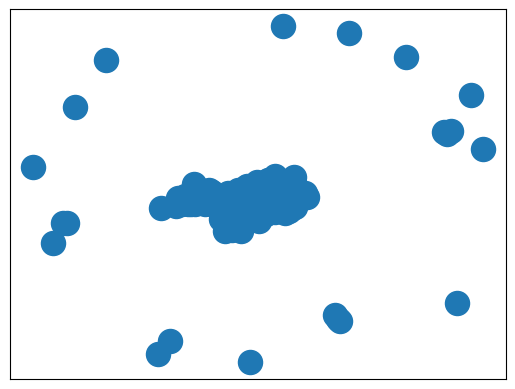

In [12]:
nx.draw_networkx(training_graph, with_labels = False)

In [13]:
def test(template, nexamples):

    count = 0
    lv1TP = 0
    lv1FN = 0
    lv1FP = 0
    lv2TP = 0
    lv2FN = 0
    lv2FP = 0

    for i in range(len(df_test)):

        subgraph_radius = 65.73/2              #SET MANUALLY, on the training set, on average these yield a subgraph of size (N*50)**0.5

        query = 'Text: '+ df_test.iloc[i]['text']+'\n'+'label = '

        test_graph = training_graph.copy()     

        for j in range(len(training_graph)):
            if euclid(df_train.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > subgraph_radius:
                test_graph.remove_node(j)


        while(len(test_graph)) < nexamples:     #If the subgraph doesn't have enough nodes, increment the radius
            subgraph_radius *= 1.1
            test_graph = training_graph.copy()
            for j in range(len(training_graph)):
                if euclid(df_train.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > subgraph_radius:
                    test_graph.remove_node(j)
            #print(subgraph_radius)






        
        selected_nodes = []
        communities = nx.community.louvain_communities(test_graph, seed = random_state)
        sorted_communities = sorted(communities, key = lambda x: len(x), reverse = True)
        #print(sorted_communities)
        #print(len(sorted_communities))



        if len(sorted_communities) >= nexamples:    #If there are enough communities:
            for l in range(nexamples):
                subgraph = test_graph.subgraph(sorted_communities[l])
                selected_nodes.append(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True )[0][0])
                #print(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True ))
        else:                                       #If there are less communities than nodes to choose:
            numberofelements = 2
            while len(selected_nodes) < nexamples:
                selected_nodes = []
                for element in sorted_communities:
                    subgraph = test_graph.subgraph(element)
                    selected_nodes += [foo[0] for foo in sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True )][:numberofelements]
                    numberofelements += 1

        
        selected_nodes = selected_nodes[:nexamples]     #The final chosen demonstrations
        print('Selected Nodes:', selected_nodes)

        examples_text = []
        
        for el in list(range(nexamples)):
            if df_train.iloc[selected_nodes[el]]['Level'] == '1':
                examples_text.append('Text: '+ df_train.iloc[selected_nodes[el]]['text'] + '\n' + 'label = '+ 'sufficiently informative'+'\n\n')
            else:
                examples_text.append('Text: '+ df_train.iloc[selected_nodes[el]]['text'] + '\n' + 'label = '+ 'insufficiently informative'+'\n\n')

        random.shuffle(examples_text)

        examples_text = examples_text[:nexamples]

        text_examples = ''      #Building text examples

        for el in examples_text:
            text_examples += el
        
        print('query:\n'+ query,'\n')
        print('retrieved examples:\n\n'+ text_examples,'\n\n')

        messages = [{'role': 'system', 'content': template},{"role": "user", "content": text_examples},{"role": "user", "content": query}]

        outputs = pipeline(
            messages,
            max_new_tokens=10,
            do_sample = False
        )
        final_output = outputs[0]['generated_text'][-1]['content']
        print('LLM output:', final_output)
        if df_test.iloc[i]['Level'] == '1':
            gt = 'sufficiently informative'
        else:
            gt = 'insufficiently informative'
        print('ground truth:', gt)
        print(200*'-')

        if 'insufficiently' in final_output and df_test.iloc[i]['Level'] == '2':
            lv2TP += 1
        if 'insufficiently' in final_output and df_test.iloc[i]['Level'] == '1':
            lv2FP += 1
        if 'insufficiently' not in final_output and df_test.iloc[i]['Level'] == '2':
            lv2FN += 1
        
        if  final_output == 'sufficiently informative' and df_test.iloc[i]['Level'] == '1':
            lv1TP += 1
        if final_output == 'sufficiently informative' and df_test.iloc[i]['Level'] == '2':
            lv1FP += 1
        if final_output != 'sufficiently informative' and df_test.iloc[i]['Level'] == '1':
            lv1FN += 1
        
    lv1PREC = lv1TP/(lv1TP+lv1FP)
    lv1REC = lv1TP/(lv1TP+lv1FN)
    lv2PREC = lv2TP/(lv2TP+lv2FP)
    lv2REC = lv2TP/(lv2TP+lv2FN)

    lv1F1 = 2/((1/lv1PREC)+(1/lv1REC))
    lv2F1 = 2/((1/lv2PREC)+(1/lv2REC))

    print('lv1 F1:', lv1F1)
    print('lv2 F1:', lv2F1)

    print('macro F1:', (lv1F1+lv2F1)/2 )
            


In [14]:
template = '''You will be given as input a sentence from a privacy policy that contains information about what data the service collects about the user. You have to classify the sentence into one of the following classes: "sufficiently informative" or "insufficiently informative".

In doing so, consider that GDPR, and the EDPB's Guidelines, contain a certain inherent tension, namely that between requiring that the information is provided in as easy a way to understand as possible (comprehensibility) and that it is concrete and definitely (comprehensiveness).
Sometimes, using open-ended qualifiers like “for example” or “such as” might actually facilitate understanding by the data subject, especially when terms not often used in the natural language (e.g. “device information” or “geolocation information”) are concerned. For this reason, we differentiate between:
*	Abstract terms (e.g. usage information) vs. concrete terms (e.g. geolocation information)
*	Open-ended qualifications (“for example”, “such as”, etc.) vs. closed-catalogues (“meaning”, “understood as” ).

A sentence containing an abstract term, UNLESS followed by a comprehensive enumeration, should be judged as "insufficiently informative".
A sentence containing a concrete term, even if followed by an open-ended qualifier, should be judged as "sufficiently informative".

Avoid explanations. Only reply with "insufficiently informative" or "sufficiently informative".

Here are some examples:'''

In [15]:
test(template, 5)

C:\Users\alfio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
C:\Users\alfio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\generation\configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [42, 119, 185, 200, 273]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: Account and Device Activation: When you activate your Device, you will be asked to download the App and create an account, where you enter information about yourself, such as username, password 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [215, 217, 21, 237, 167]
query:
Text: User Content.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 45, 408, 73, 315]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: This includes usage information (information about how you interact with our Services — for example, which Lenses you view and apply, Stories you watch, and how often you communicate with other Snapchatters) and content information (information about content you create or provide, your engagement with the camera and creative tools, your interactions with My AI, and metadata — for example, information about the content itself like the date and time it was posted and who viewed it).
label = insufficiently informative

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 161, 36, 390, 268]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [44, 54, 12, 222, 229]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: Location data, including your general location data (e.g. IP address) and, with your permission, the precise location data of your mobile device.
label = sufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have grant

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 163, 237, 191]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Other Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [50, 97, 68, 271, 390]
query:
Text: If you communicate with others using direct messages, we collect the content of the message and the associated metadata (such as the time the message was sent, received and/or read, as well as the participants in the communication).
label =  

retrieved examples:

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 195, 261, 262, 277]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: We also collect informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [417, 237, 8, 163, 188]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: Other Information, With Your Permission
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [49, 175, 261, 262, 15]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Contacts: You can invite others to join or become your friend on Yelp by providing us with their contact information, or by allowing us to access contacts from your computer, mobile device, or third party sites to select which individuals you want to invite.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with thr

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [49, 80, 418, 66, 303]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Contacts: You can invite others to join or become your friend on Yelp by providing us with their contact information, or by allowing us to access contacts from your computer, mobile device, or third party sites to select which individuals you want to invite.
label = insufficiently informative

Text: If you choose to invite a family member or another person to view or edit your family tree, we will ask you for the individual's email address and name.
label = insufficiently informative

Text: Social Media: You may decide to share informatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 237, 167, 215, 217]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [9, 57, 132, 185, 262]
query:
Text: When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our pay

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [59, 209, 304, 38, 207]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Your Survey Answers: If you voluntarily participate in any Surveys or questionnaires on the Service, we will collect the information you provide.
label = insufficiently informative

Text: We may also collect information from you if you interact with Dropbox representatives at an event, download marketing or edu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [8, 144, 253, 389, 412]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: When You Contact Us.
label = sufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 38, 36, 37, 54]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Your Communications: Your communications with other users through the Service’s features (e.g., MyHeritage Inbox), as well as information you provide us in communications with our customer support team (e.g., support tickets), or other representatives and/or information you provide while interact

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [138, 412, 237, 394, 144]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 237, 242, 167, 176]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [192, 211, 176, 242, 237]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [40, 70, 12, 129, 166]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can reset by going into your device’ settings and, in some cases, disable entirely), and identifiers associated with cookies or other technologies that may uniquely identify a device or browser.
label = insufficiently informative

Text: When you visit our Website, we may automatically collect non-personal information about you, such as the website from which you have come to our Website, your computer type, screen resolution, Operating 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 261, 196, 166, 332]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: Information we receive through device settings that you choose, such as your photos or audio content;
label = insufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: Such as 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 68, 198, 268, 385]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We also collect information on how you int

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [33, 26, 260, 315, 407]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: We collect content that you create using Meta VR Products, such as your avatar, a picture that you post or an object that you sculpt, and information about this content, such as the date and time that you created the content.
label = insufficiently informative

Text: Content information includes information based on the content of the image, video, or audio — so if you post a Spotlight of a basketball game, we may use that information to show you more content on Spotlight about basketball.
label = insufficiently informative

Text: For research and development purposes, we may use datasets such a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [176, 237, 394, 388, 103]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 418, 344, 343, 281]
query:
Text: We infer your attributes (such as age-range and gender) and interests based on the information we have about you.
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: For example, if you purchase products or services related to wellness and beauty, we m

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [66, 80, 175, 185, 304]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Instagram or Spotify).
label = insufficiently informative

Text: If you link, connect, or login 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [55, 56, 189, 356, 401]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: When you set up your profile, you’ll also provide us with profile details (like your Bitmoji and profile picture).
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: You can also share additional information with us, such as details on your bio and your interests, as well as content such as photos and videos.
label = insufficiently informative

Text: When you complete your profile, you have the option to share your sexual orientation with us.
label = insufficiently informative

Text: To add certain content, like pictures or videos, you may allow us to ac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [164, 21, 136, 365, 351]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [96, 112, 194, 212, 224]
query:
Text: This information includes your device model, operating system, keystroke patterns or rhythms, IP address, and system language.
label =  

retrieved examples:

Text: This includes access dates and times, app features or pages viewed, browser type, and app crashes and other system activity.
label = insufficiently informative

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed pages within our Services, your language settings and your weblog information.
label = insufficiently informative

Text: In addition, your web browser or client software may transmit certain geographic information or information regarding your computer (capabilities, game data processing, hardware of software information, cookie information, etc.)
label = insufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 65, 183, 281, 302]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they ma

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [65, 235, 281, 418, 320]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 77, 100, 105, 127]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Device identifiers: In the course of using a mo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [183, 304, 65, 386, 161]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: Like many websites, we use cookies and other unique identifiers and we obtain certain types of information when your web browser or device accesses Amazon Services and other content served by or on behalf of Amazon Europe on other websites.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Pri

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 61, 97, 116, 181]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We may also collect details in relation to transactions you make on Blizzard website, and/or information that are necessary to facilitate the licensing and purchasing of our products and services.
label = sufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 146, 151, 155, 156]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informative

Text: We may process the following personal data for marketing purposes:

Na

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [44, 189, 96, 91, 84]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: This includes access dates and times, app features or pages viewed, browser type, and app crashes and other system activity.
label = insufficiently informative

Text: This also includes vehicle or insurance information of drivers and delivery persons, emergency contact information, user settings, and evidence of health or fitness to provide services using Uber apps.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 53, 77, 100, 105]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 44, 418, 194, 170]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device eve

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 84, 365, 100, 169]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
-------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 148, 136, 365, 351]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: This information includes:

Contac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 148, 365, 351, 136]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: This information may include:



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 151, 136, 365, 351]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: We ma

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [392, 285, 160, 384, 148]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: We may process the following personal data for campaigning purposes:

Name

Contact data

Order and transaction data (optional)

Campaign data (optional)
label = insufficiently informative

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [44, 62, 158, 277, 157]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: Data processed for cookie purposes defer per purpose (functional, analytical or marketing) and depend on the preferences set by you.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: JET uses your personal data to be able to improve our website and our range of products and Services and to be able meet our reporting obligations towards third parties which may also include advertisers.
label = insufficiently informative

Text: We also store and use any preferences you provide to personalize your user experience, including di

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 54, 161, 286]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [249, 413, 298, 240, 150]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Data We Receive From Others
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 298, 300, 379]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 21, 249, 298, 154]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Customer research
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [104, 129, 131, 384, 23]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 74, 92, 230, 103]
query:
Text: Additional data
label =  

retrieved examples:

Text: Other information with your consent:
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [194, 261, 97, 102, 50]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: If you exchange messages with others through the Service, we may store them in order to process and deliver them, allow you to manage them, and we may review and disclose them in connection with investigations related to use of the Service, as well as our efforts to improve the Service.
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: We may also collect the content of phone

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 65, 70, 129, 170]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and chara

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [168, 189, 261, 320, 336]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Such as the pages or content you view, searches for Listings, bookings you have made, additional services you have added, and other actions on the Airbnb Platform.
label = insufficiently informative

Text: For example, we receive informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [211, 217, 167, 240, 370]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 105, 127, 302, 385]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [410, 78, 101, 112, 212]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: Device data: We collect data about the devices used to access our services, including the hardware models, device IP address or other unique device identif

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 237, 242, 167, 176]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 412, 237, 394, 164]
query:
Text: Information from Cookies and Other Technologies.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [298, 300, 237, 114, 163]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 65, 129, 68, 358]
query:
Text: We collect information when you access content, advertising, sites, interactive widgets, applications, and other products (both on and off of our Services) where Yahoo data collection technologies (such as web beacons, development tools, cookies and other technologies, etc.) are present.
label =  

retrieved examples:

Text: Information collected by cookies and similar technologies: We use and may allow others to use cookies and similar technologies (e.g., web beacons, pixels, SDKs) to recognize you and/or your device(s).
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 225, 235, 263]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: We may also track your actions in response to the messages you receive from us or through the Service, such as whether you deleted, opened, or forwarded such messages, and share that information with other parties to your messages (for example, to let them know if you have viewed their message).
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access date

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [174, 181, 352, 66, 175]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We collect personal information from other sources, such as:

Third-Party Services.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Social Media: You may decide to share info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [336, 403, 248, 258, 364]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: This may include health information if you choose to share it with us.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
---------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [109, 282, 64, 258, 195]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: Information collected from third parties (our vendors, affiliates, and business partners).
label = insufficiently informative

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [183, 320, 336, 416, 418]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experiences and interactions from our partners.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Gu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 249, 240, 391]
query:
Text: General Data
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Automatic Information
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 54, 272, 304]
query:
Text: Certain categories of information collected by Yahoo are necessary to use our Services, such as the information you must provide when registering for some Services.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 54, 57, 165, 185]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: When you use the Airbnb Platform and Payment Services, we automatically collect personal and other information.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [394, 21, 164, 173, 110]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [71, 100, 139, 308, 195]
query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Precise geolocation data: If you give us your consent, we can collect your precise geolocation (latitude and longitude) from your device.
label = sufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [255, 82, 173, 389, 412]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [40, 78, 129, 285, 392]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and duration of visits, the links on which you click and other actions you take as part of your use of our Services and in advertising and email content.
label = insufficiently informative

Text: When you visit our Website, we may automatically collect non-personal information about you, such as the website from 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 221, 258, 320, 403]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
---------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [92, 95, 237, 417, 163]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [9, 185, 131, 373, 341]
query:
Text: Depending on the Services you choose, we will collect your name, mailing address, email, income,
telephone number, tax ID, Payment Information, profession, employment or business information, and other information necessary to
establish an account and use our Services.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: If you don’t provide this, we may not be able to pro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 288, 373, 126, 200]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on other sites).
label = ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 388, 237, 140]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Examples of Information Collected
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [215, 217, 167, 171, 186]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 115, 132, 126, 219]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: Data about your billing address and method of payment, such as bank details,
credit, debit, or other payment card information
label = sufficiently informative

Text: The transaction related information include: name, phone number, address, credit card number, expiration date, email address, bank name, bank account number and/or bank account owner’s name.
label = sufficiently informative

Text: To fulfil our contractual obligations to facilitate transactions we may need some of this information to enable Sellers to deliver products to you, such as your postal address to deliver physical products and your email address to send you vouchers, an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [104, 126, 131, 349, 373]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on other sites

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [114, 298, 138, 21, 394]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [373, 131, 200, 126, 137]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details, contact 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [19, 114, 301, 63, 289]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: Information you provide to us directly
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [211, 217, 167, 240, 370]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Device information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 25, 298, 379]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [298, 300, 301, 114, 92]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [215, 217, 167, 240, 192]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [104, 288, 341, 261, 175]
query:
Text: If you choose to connect non-financial or financial account such as your personal
email, social media, or bank or credit accounts, we will collect information consistent with the disclosed purpose for which it was linked.
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [177, 181, 341, 126, 216]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on other sites).
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 181, 146, 373, 341]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: If you don’t provide this, we may not be able to 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 170, 129, 137, 175]
query:
Text: Information from others from your use of third-party applications, such as the Apple App Store or Google Play
Store, social networking sites, such as name, your social network ID, Location Information, email, device ID, browser ID, and profile picture.
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: Such as your first name, last name, phone number, postal address, email address, date of birth, and profile photo, some of which will depend on the features you use.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicke

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [95, 300, 379, 114, 298]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Information collected from you.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [92, 95, 237, 417, 163]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [241, 285, 128, 392, 224]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed pages within our Services, your language settings and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [344, 343, 162, 205, 260]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: We create audiences based on parameters such as gender, age, and location (e.g. males aged 25-35 in your city), and if your personal data matches those audiences, you’ll be assigned to it. This is to help you receive relevant offers; and
Activity information.
label = insufficiently informative

Text: In some cases: age, gender, country of birth, nationality, country of residence, employment status, family status, interests and preferences.
label = insufficiently informative

Text: For research and development purposes, we may use datasets such as those that contain images, voices,
or other data that could be associated with an identifiable person.
label = insufficiently informative

Text: For example, if you pur

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 71, 129, 166, 222]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: Precise geolocation data: If you give us your consent, we can collect your precise geolocation (latitude and longitude) from your device.
label = sufficiently informative

Text: Location data, inc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [77, 105, 318, 386, 36]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 54, 384, 104, 360]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: Here are the types of personal informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [109, 181, 126, 131, 174]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on other sites).
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 59, 139, 272, 308]
query:
Text: We collect your information when you interact with us or use our services, such as when you use our Sites to place an order.
label =  

retrieved examples:

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [100, 106, 44, 158, 383]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: JET uses your personal data to be able to improve our website and our range of products and Services and to be able meet our reporting obligations towards third parties which may also include advertisers.
label = insufficiently informative

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: We collect your personal information in order to provide and continually improve our products and services.
label = insufficiently informative

Text: When you see our ads outside of our Services, we may collect information about your interactions with those ads.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 144, 173, 287, 389]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [9, 119, 185, 200, 262]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [59, 60, 67, 139, 195]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

 


LLM output: sufficiently informative
ground

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [143, 341, 44, 398, 304]
query:
Text: We will also collect your date of birth to verify your age when you purchase age restricted items.
label =  

retrieved examples:

Text: If a copy of your ID is provided to us, we may scan, use, and store information contained in your ID to verify your identity and for security purposes.
label = sufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficient

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 37, 127, 183]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: Your Communications: Your communications with other users through the Service’s features (e.g., MyHeritage Inbox), as well as information you provide us in communications with our customer support team (e.g., support tickets), or other representatives and/or information you provide while interacting and communicating with our automated virtual assistant, will be collected and recorded by us and, with respect to our automated virtual assistant, recorded by our service provider Cognigy.AI.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [60, 97, 264, 361, 362]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We may collect personal data under call recordings to provide customer support, including to investigate and address user concerns and to monitor and improve our customer support responses and processes.
label = insufficiently informative

Text: When you contact our customer services support, we will use the personal data you provide to answer your question or handle your complaint.
label = insufficiently informative

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: Any of our communications with you, including any 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 135, 130, 132, 262]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform and complete its Services if you do not cooperate for the required verification procedure.
label = sufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take pay

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 70, 78, 105, 112]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can reset by going into your device’ settings and, in some cases, disable entirely), and identifiers associated with cookies or other technologies that may uniquely identify a device or browser.
label = insufficiently informative

Text: In addition, your web browser or client software may transmit certain geographic information or information regarding your computer (capabilities, game data processing, hardware of software info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 170, 70, 393, 269]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can reset by going into your device’ settings and, in some cases, disable entirely), and identifiers associated with cookies or other technologies that may uniquely identify a device or browser.
label = insufficiently informative

Text: We may also use device identifiers, cookies, and other technologies on devices, appl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [59, 60, 149, 350, 133]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We may collect these additional personal details for the purposes of building a profile for you to better understand customer behaviour and enable us to display more relevant offerings to you, as it is in our legitimate interest to promote offerings you are more likely to buy;
Contact details (e.g. your postal address, telephone number, and email address).
label = sufficiently informative

Text: Other data that we are required 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 124, 144, 412, 382]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 66, 79, 80, 175]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 282, 335, 337, 416]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We also receive information about you from third parties, including third-party apps, developers,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 256, 282, 335, 414]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We also receive information about you from third parties, including third-party apps, developers, other online content providers and marketing partners that provide us with information.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affili

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 44, 131, 262, 272]
query:
Text: If you consent during the creation of an account, we will process your User Data listed below in order to be able to provide our services.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 25, 298, 417]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 195, 69, 323, 301]
query:
Text: What information does Adobe collect about me?
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 57, 23, 36, 47]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Sensitive Personal Informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [152, 185, 146, 131, 126]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);
Types of Services and Software of interest.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [126, 214, 390, 12, 78]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on other sites).
label = insufficiently informative

Text: As a result of those

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 176, 394, 388, 103]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Examples of Information Collected
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [320, 64, 418, 317, 189]
query:
Text: For example, the size, industry and other information about the company you work for (where you have provided company name) will be obtained from sources including, professional networking sites and information service providers
label =  

retrieved examples:

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: This can inclu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 36, 47, 185, 304]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Servi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 77, 105, 127, 197]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and device identifiers of devices you use to view the content.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [137, 189, 400, 162, 401]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: To do this, we ask you to provide us with account details (information about you, like your name, username, email address, birthday, and phone number).
label = sufficiently informative

Text: Such as gender, preferred language(s), city, and personal description.
label = insufficiently informative

Text: When you set up your profile, you’ll also provide us with profile details (like your Bitmoji and profile picture).
label = insufficiently informative

Text: Such as your first name, last name, phone number, postal address, email address, date of birth, and profile photo, some of which will depend on the features you use.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collabora

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [70, 78, 410, 40, 241]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved examples:

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [20, 129, 33, 54, 72]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: Photo Verification data: If you choose to participate in our Photo Verification feature, we collect your face geometry data, which may be considered biometric data in some jurisdictions, to verify that you’re the real you.
label = sufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: When providing these Products, AVA collects both personally identifiable information (“PII”), which ca

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 68, 416, 390, 268]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response to such requests.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other peopl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 78, 129, 170, 185]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 262, 129, 386, 385]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 268, 271, 285]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: Cookies may transmit informatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 302, 390, 200, 119]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: For some activities, we may ask you to create a username and password and/or to provide other personal and non-personal information including but not limited to your age, date of birth, gender, and/or game and platform preferences; we may combine such information with other personal and/or non-personal information.
label = insufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: Automatic informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 36, 96, 320, 324]
query:
Text: In addition, when you see or interact with these buttons, tools or content or view an Adobe web page or app containing them, some information from your browser may automatically be sent to the other company.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: This includes access dates and times, app features or pages viewed, browser type, and app crashes and other system activity.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: For example, we receive information about your Meta Quest Browser usage, such as interactions with recommended 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 36, 100, 105, 183]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [224, 197, 385, 12, 302]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed pages within our Services, your language settings and your weblog information.
label = insufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [43, 61, 352, 363, 107]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: If you register an account using your Facebook credentials, the following information may be collected: (1) your first and last name and other information made publicly available by you, (2) your friends list, and (3) the email address associated with your account.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: User profile information: We collect data when user

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 67, 36, 66, 73]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Instagram or Spotify).
label = insufficiently informative

Text: Sensitive Personal Information: In the co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 352, 66, 390]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Instagram or Spotify).
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 356, 72, 33, 26]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: Biometric Information: If you choose to use our Photo Tagger feature, it uses facial recognition technology, to create facial recognition models (i.e., biometric information) of you and your deceased relatives, in order to help you tag people in your photos quickly and easily.
label = insufficiently informative

Text: If you choose to use our Photo Tagger feature, it identifies faces in your photos and creates facial recognition models (i.e., biometric information).
label = insufficiently informative

Text: Pho

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 144, 287, 289, 396]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information You Can Access
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 176, 167, 215, 217]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [73, 312, 363, 408, 76]
query:
Text: When you use our Services to communicate with others or post, upload or store content (such as comments, photos, voice inputs, videos, emails, messaging services and attachments).
label =  

retrieved examples:

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communicati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 106, 320, 418, 258]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: When you see our ads outside of our Services, we may collect information about your interactions with those ads.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 47, 60, 139, 272]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [302, 12, 224, 170, 78]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed pages within our Services, your language settings and your weblog information.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Such Traffic Data includes

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [211, 240, 394, 237, 388]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [57, 116, 132, 181, 265]
query:
Text: We receive information about you from merchants as well as payment and transaction fulfillment providers, such as payment confirmation details, and information about the delivery of products you have purchased through our shopping features.
label =  

retrieved examples:

Text: Transactions: If you initiate a transaction through the Service, such as making a reservation, joining a waitlist, making an appointment, or making a purchase, we will collect and store information you provide associated with your transaction, such as your name, phone number, address, email, and payment information, as well as any other information you provide relating to the transaction or request, in order to process your transaction, send you communications related to the transaction, and to facilitate future transactions.
label = sufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 37, 47, 67, 97]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: Your Communications: Your communications with other users through the Service’s features (e.g., MyHeritage Inbox), as well as information you provide us in communications with our customer support team (e.g., support tickets), or other representatives and/or information you provide while interacting and communicating with our automated virtual assistant, will be collected and recorded by us and, with respect to our automated virtual assistant, recorded by our 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [4, 78, 128, 129, 392]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: Internet or other electronic network activity information	IP address, device mode, device ID, OS version, device language, operating system, browser type, browsing history, search history, and information regarding a consumer’s interaction with an Internet Web site, application, or advertisement.
label = insufficiently informative

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: Examples of such i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 237, 242, 167, 176]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [152, 310, 216, 204, 219]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: Data that is generated as part of one of your transactions (e.g. as relating to bids, purchases, sales, fees) or that is linked to your eBay account as a result of a transaction in which you are involved, such as transaction amounts, time and location of transactions and form of payment or payout method.
label = sufficiently informative

Text: Delivery, billing, and other information you provide, as well as information required for customs clearance (such as tax identification numbers or other identification numbers) and relevant delivery information (such as shipment numbers and tracking information) if sent through one of our programmes.
label = sufficiently informative

Text: If you 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [254, 259, 309, 131, 341]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: For example,
you may direct your mobile carrier to share data about your carrier account with Apple for account
activation, or for your loyalty program to share information about your participation so that you can earn
rewards for Apple purchases.
label = insufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: Details such as the content of your communications with Apple,
including interactions with customer support and contacts through social media channels
label = sufficiently informative

Text: For example:

When you register to use Meta VR Products, we ask for information such as your n

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 47, 104, 131, 174]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect the inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 104, 131, 139, 272]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [114, 300, 379, 95, 74]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: Other information with your consent:
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [104, 130, 131, 146, 349]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [85, 248, 258, 317, 364]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: This may include health information if you choose to share it with us.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
---------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [132, 216, 341, 181, 261]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: Data about your billing address and method of payment, such as bank details,
credit, debit, or other payment card information
label = sufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demogr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 277, 261, 44, 338]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails reg

In [16]:
test(template, 10)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [9, 42, 119, 131, 137, 185, 200, 273, 352, 373]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: If you choose to buy a Product on our Site, we require you to provide various PII, such as your e-mail address, first name, last name, and credit card information including the zip code and cv number.
label = sufficiently informative

Text: For some activities, we may ask you to create a username and password and/or to provide other personal and non-personal information including but not limited to your age, date of birth, gender, and/or game and platform preferences; we may combine such information with other personal and/or non-personal information.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [215, 217, 240, 192, 211, 171, 21, 237, 167, 150]
query:
Text: User Content.
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [66, 73, 193, 385, 36, 390, 363, 312, 85, 405]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Instagram or Spotify).
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 161, 195, 100, 332, 36, 390, 268, 80, 185]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [44, 54, 189, 235, 262, 268, 12, 222, 229, 166]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: Location data, including your general location data (e.g. IP address) and, with your permission, the precise location data of your mobile device.
label = sufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 186, 211, 370, 346, 163, 237, 191, 188]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Other Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [50, 97, 122, 185, 262, 263, 68, 271, 390, 415]
query:
Text: If you communicate with others using direct messages, we collect the content of the message and the associated metadata (such as the time the message was sent, received and/or read, as well as the participants in the communication).
label =  

retrieved examples:

Text: This includes linked third-party service data (information we get when you link your Snapchat account to another service), data from advertisers (information from advertisers, app developers, publishers, and other third parties to help target or measure the performance of ads), contact info from other Snapchatters or third parties (if another Snapchatter uploads their contact list which includes your information, we may combine that with other information we have about you to better understand who you may want to communicate with.
label = insufficiently informative

Text: As a result of those actions, you might supply us with such information a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 195, 261, 262, 277, 304, 312, 406, 36, 47]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: If you choose to do 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 417, 394, 298, 300, 8, 163, 217, 242, 215]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [49, 175, 304, 352, 390, 415, 261, 262, 15, 51]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Contacts: You can invite others to join or

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [49, 80, 107, 175, 261, 304, 418, 66, 303, 401]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: Contacts: You can invite others to join or become your friend on Yelp by providing us with their contact information, or by allowing us to access contacts from your computer, mobile device, or third party sites to select which individuals you want to invite.
label = insufficiently informative

Text: If you register an account using your Facebook credentials, the following information may be collected: (1) your first and last name and other information made publicly available by you, (2) your friends list, and (3) the email address associated with your account.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 242, 167, 215, 217, 192, 163, 176, 213, 417]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [57, 265, 310, 132, 142, 185, 352, 36, 363, 268]
query:
Text: When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: If you are not an Airbnb user, we may receive payment information relating to you, such as when an Airbnb user provides your payment card to complete a booking.
label = sufficiently informative

Text: Such as when you fill in a form, add information 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 38, 47, 59, 60, 67, 416, 352, 73, 297]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: For example, information that you enter when you sign up for the Service, create a family tree or do your family history research using the Service, communicate with our customer support staff and our automated virtual assistant, fill in a questionnaire or survey on our Website, and so on.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [144, 253, 389, 138, 164, 8, 21, 399, 412, 413]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

 


LLM output: sufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 38, 47, 67, 139, 262, 36, 37, 54, 60]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting wi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [138, 144, 164, 389, 412, 413, 417, 394, 237, 25]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Data We Receive From Others
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information You Choose to Give Us.
label = ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 176, 237, 394, 417, 192, 217, 167, 215, 242]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 167, 242, 163, 176, 247, 240, 211, 215, 217]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Fitness Information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [40, 70, 78, 105, 112, 269, 12, 129, 166, 222]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: In addition, your web browser or client software may transmit certain geographic information or information regarding your computer (capabilities, game data processing, hardware of software information, cookie information, etc.)
label = insufficiently informative

Text: Location data, including your general location data (e.g. IP address) and, with your permission, the precise location data of your mobile device.
label = sufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 261, 418, 53, 129, 170, 196, 166, 332, 336]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Information we receive through device settings that you choose, such as your photos or audio content;
label = insufficiently informative

Text: This may include data about your location. With r

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [100, 197, 268, 271, 385, 105, 225, 68, 324, 198]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: We also collect information on how you interact with the viewed content, such as the date and time y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [225, 235, 356, 407, 189, 33, 72, 312, 390, 328]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or enjoyed, information about the advertisements you have been shown or clicked on, etc.).
label = insufficiently informative

Text: As a result of those a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 21, 138, 413, 167, 240, 211, 217, 192]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 418, 326, 194, 100, 344, 343, 281, 348, 235]
query:
Text: We infer your attributes (such as age-range and gender) and interests based on the information we have about you.
label =  

retrieved examples:

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or enjoyed, information about the advertisements you have been shown or clicked on, etc.).
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: We may use the data we collect to infer other data, for exam

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 175, 185, 235, 261, 304, 310, 312, 352, 363]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [10, 303, 401, 55, 403, 189, 356, 336, 85, 84]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

Text: When you complete your profile, you have the option to share your sexual orientation with us.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: You may also provide AVA with certain optional information at your sole discretion.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insuff

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [164, 21, 110, 173, 389, 169, 136, 365, 351, 318]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Log Data and Devic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [96, 112, 194, 212, 224, 227, 326, 333, 410, 78]
query:
Text: This information includes your device model, operating system, keystroke patterns or rhythms, IP address, and system language.
label =  

retrieved examples:

Text: Technical system information such as crash logs, which may contain your user ID, the device ID, the IP address, the local computer file path, the feature quality, the amount of time it takes to load a feature and whether you use a certain feature.
label = sufficiently informative

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones conn

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 65, 183, 281, 302, 311, 416, 235, 263, 415]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [65, 235, 302, 345, 348, 416, 281, 418, 320, 336]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: We also create profiles about you based on the personal data you provide to us or that is collected about you, as described above and including personal data that we receive from Business Partners.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or enjoyed, information about the advertisements you have be

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 54, 77, 100, 127, 129, 386, 385, 70]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: Usage data: We collect data about how us

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [183, 304, 311, 316, 337, 414, 65, 386, 161, 263]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experiences and interactions from our partners.
label = insufficiently informative

Text: We also collect content and information that other people provide when they use Meta VR Products.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 61, 97, 116, 181, 282, 304, 345, 414, 416]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: We may also collect details in relation to transactions you make on Blizzard website, and/or information that are necessary to facilitate the licensing and purchasing of our products and services.
label = sufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insuffic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [148, 151, 153, 155, 156, 160, 131, 392, 146, 349]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: Examples of the information we collect and analyse include:

the Internet protocol (IP) address used to connect your computer to the Internet;
login; e-mail address; password;
the location of your device or computer;
content interaction information, such as content downloads, streams, and playback details including duration and number of simultaneous streams and downloads, and network details for streaming and download quality, including information about your internet service provider;
device metrics such as w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 44, 194, 189, 96, 84, 336, 221, 317, 418]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 418, 195, 100, 261, 127, 129, 386, 197, 40]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: Like many websites, we use cookies and other unique identifiers and we obtain certain types of information when your web browser or device accesses Amazon Services and other content served by or on behalf of Amazon Europe on other websites.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 44, 133, 281, 348, 416, 418, 194, 170, 302]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about po

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 161, 84, 221, 95, 365, 351, 136, 307, 100]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: This informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 148, 151, 153, 155, 156, 160, 373, 136, 365]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: We may process following personal data for fraud prevention purposes:

Name

Order and transaction data

Payment data

Device information

IP address

Browser information
label = insufficiently informative

Text: We may process the following personal data for marketing purposes:

Name

Address data

Contact data

Order an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 148, 151, 153, 155, 365, 351, 136, 307, 384]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: We may process the following personal data for marketing purposes:

Name

Address data

Contact data

Order and transaction data

Review(s) 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 151, 148, 153, 155, 156, 160, 397, 136, 365]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [392, 285, 146, 126, 128, 160, 384, 148, 373, 151]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: We may process the following personal data for campaigning purposes:

Name

Contact data

Order and transaction data (optional)

Campaign data (optional)
label = insufficiently informative

Text: Examples of the information we collect and analyse include:

the Internet protocol (IP) address used to connect your computer to the Internet;
login; e-mail a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [282, 61, 181, 277, 60, 320, 418, 336, 189, 67]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behal

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [282, 308, 312, 352, 414, 47, 161, 195, 100, 36]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [249, 237, 413, 287, 388, 298, 300, 103, 394, 240]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 298, 300, 379, 412, 413, 255, 366, 136]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

 


LLM output: insufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 21, 413, 287, 249, 237, 244, 247, 298]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
----------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [373, 131, 341, 152, 384, 161, 129, 100, 36, 105]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 74, 22, 191, 92, 230, 103, 93, 186, 370]
query:
Text: Additional data
label =  

retrieved examples:

Text: The data we collect
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
-----------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [194, 261, 390, 263, 312, 97, 102, 50, 51, 122]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: You understand that users should have no expectation of privacy concerning the transmission of any user generated content or communications, including without limitation chat text or voice communications, and you hereby acknowledge and agree that we will monitor and record such communications as described in this Privacy Policy.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: Communications data: We collect data regarding phone, text or in-app communications between users that are enabled through Uber’s apps.
label = insufficiently

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 65, 70, 129, 170, 271, 281, 358, 386, 393]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [168, 189, 261, 320, 336, 96, 170, 84, 406, 268]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Such as the pages or content you view, searches for Listings, bookings you have made, additional services you have added, and other actions on the Airbnb Platform.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Activity: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 242, 167, 163, 176, 217, 215, 186, 370, 192]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Account information.
label = sufficiently informative

Text: Device information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 65, 80, 100, 105, 129, 68, 70, 410]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and micro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [410, 78, 101, 112, 212, 224, 227, 326, 70, 269]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your wireless and mobile connections), location information (IP address), information collected by cookies and similar technologies, depending on your settings, (cookies, web beacons (small graphic data that recognize user activity, such as if and how often a user has visited a we

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 176, 237, 394, 417, 192, 217, 167, 215, 242]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [164, 413, 412, 144, 389, 255, 237, 379, 298, 114]
query:
Text: Information from Cookies and Other Technologies.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 167, 394, 163, 417, 176, 298, 300, 379, 92]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
-------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 65, 77, 80, 105, 127, 129, 68, 358, 70]
query:
Text: We collect information when you access content, advertising, sites, interactive widgets, applications, and other products (both on and off of our Services) where Yahoo data collection technologies (such as web beacons, development tools, cookies and other technologies, etc.) are present.
label =  

retrieved examples:

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can reset by going into your device’ settings and, in some cases, disable entirely), and identifiers associated with cookies or other technologies that may uniquely identify a device or browser.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may coll

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 268, 271, 385, 194, 416, 65, 386, 36]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages with them).
label = insufficiently informative

Text: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [174, 181, 282, 414, 256, 308, 352, 66, 175, 304]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Instagram or Spotify).
label = insufficiently informative

Text: We collect the information that you (and others) give us wh

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [336, 403, 284, 317, 381, 62, 248, 258, 364, 221]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [109, 282, 387, 414, 174, 335, 64, 258, 195, 418]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informative

Text: We also receive information about you from third parties, including third-party apps, develope

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 36, 65, 80, 183, 262, 387, 336, 320, 416]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [211, 217, 163, 417, 176, 21, 413, 287, 394, 249]
query:
Text: General Data
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: sufficiently informative
-------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [267, 272, 406, 23, 161, 352, 66, 131, 390, 262]
query:
Text: Certain categories of information collected by Yahoo are necessary to use our Services, such as the information you must provide when registering for some Services.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Social Media: You may decide to share information with us through your social media account, for instance i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 54, 57, 165, 185, 262, 265, 272, 304, 310]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: When you use the Airbnb Platform and Payment Services, we automatically collect personal and other information.
label = insufficiently informative

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: Transactions: If you initiate a transaction through the Service, such as making a reservation, joining a waitlist, making an appointment, or making a purchase, we will collect and store information you provide associated with your transaction, such as your name, phone number, address, email, and payment information, as well as any other information you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 21, 394, 287, 413, 164, 389, 173, 144, 82]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

 


LLM output: ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 386, 139, 308, 54, 196, 15, 166, 12, 129]
query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “devic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [255, 82, 173, 389, 412, 366, 144, 382, 253, 124]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Data We Collect
l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [70, 78, 101, 105, 269, 271, 128, 129, 392, 104]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [139, 414, 161, 304, 308, 258, 403, 418, 317, 67]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [92, 95, 103, 298, 300, 379, 237, 417, 163, 192]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
---------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [9, 185, 200, 390, 119, 199, 131, 373, 341, 152]
query:
Text: Depending on the Services you choose, we will collect your name, mailing address, email, income,
telephone number, tax ID, Payment Information, profession, employment or business information, and other information necessary to
establish an account and use our Services.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: If you use our Services as a seller, additional identification data, such as, government-issued ID (e.g. social security number), date of birth, tax identification numbers (such as VAT identification number), identification documents and information contained on IDs, selfie photos, and other information (such as bank account number) that you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 152, 373, 384, 341, 104, 199, 200, 9, 185]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: If you use our Services as a seller, additional identification data, such as, government-issued ID (e.g. social security number), date of birth, tax identification numbers (such as VAT identification number), identification documents and information contained on IDs, selfie photos, and other information (such as bank account number) that you provide when using our payment and other services as a seller.
label = sufficiently informative

Text: We will collect the followin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [394, 237, 417, 298, 300, 25, 215, 217, 240, 171]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
---------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 217, 163, 242, 249, 215, 171, 140, 346, 186]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
-------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 115, 172, 354, 203, 132, 126, 219, 199, 373]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: The transaction related information include: name, phone number, address, credit card number, expiration date, email address, bank name, bank account number and/or bank account owner’s name.
label = sufficiently informative

Text: If you use our Services as a seller, additional identification data, such as, government-issued ID (e.g. social security number), date of birth, tax identification numbers (such as VAT identification number), identification documents and information contained on IDs, selfie photos, and other information (such as bank account number) that you provide when using our payment and other services

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 349, 126, 104, 373, 185, 175, 131, 390, 363]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: The personal data we receive from Business Partners includes basic personal d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [114, 298, 300, 237, 138, 21, 394, 217, 186, 167]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
---------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [126, 130, 152, 373, 384, 104, 200, 131, 273, 119]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Account and Device Activation: When you activate your Device, you will be asked to download the App and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [301, 340, 139, 308, 60, 389, 19, 63, 69, 114]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: Information we receive from others
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: Information generated or automatically collected when you use our 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 242, 167, 163, 176, 217, 215, 186, 370, 192]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
----------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 298, 300, 394, 237, 144, 412, 413, 255, 138]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

 


LLM output: sufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [298, 300, 237, 25, 379, 301, 114, 92, 323, 63]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

 



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [215, 217, 237, 242, 249, 186, 167, 240, 192, 211]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Financial Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
-------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [104, 288, 368, 373, 131, 384, 341, 261, 175, 304]
query:
Text: If you choose to connect non-financial or financial account such as your personal
email, social media, or bank or credit accounts, we will collect information consistent with the disclosed purpose for which it was linked.
label =  

retrieved examples:

Text: This includes:

When you create an account, you provide us with at least your phone number and email address, as well as some basic details necessary for the service to work, such as your gender, date of birth, and who you’d like to connect with.
label = sufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Goog

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 373, 341, 64, 177, 216, 132, 199, 219, 256]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: Data that is generated as part of one of your transactions (e.g. as relating to bids, purchases, sales, fees) or that is linked to your eBay account as a result of a transaction in which you are involved, such as transaction amounts, time and location of transactions and form of payment or payout method.
label = sufficiently informative

Text: Here are the types of personal 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [341, 416, 120, 200, 177, 143, 384, 131, 373, 130]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communication with us, as it is in our legitimate interest to receive customer feedback, be able to respond to customers and analyze the quality of responses.
label = sufficiently informative

Text: In specific cases, we may ask you to provide a copy of a document or government-issued ID to 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 170, 241, 285, 128, 212, 129, 137, 175, 332]
query:
Text: Information from others from your use of third-party applications, such as the Apple App Store or Google Play
Store, social networking sites, such as name, your social network ID, Location Information, email, device ID, browser ID, and profile picture.
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and duration of visits, the links on which you click and other actions you take as part of your use of our Services and in advertising and email content.
label = insufficiently informative

Text: Information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [92, 95, 379, 114, 301, 323, 394, 298, 300, 103]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

 


LLM output: sufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [92, 95, 103, 298, 300, 379, 237, 417, 163, 192]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
---------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 78, 170, 194, 224, 271, 128, 129, 392, 241]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: Data about your activity on and use of our offerings, such as app launches within our
services, including browsing history; search history; product interaction; crash data, performance and
other diagnostic data; and other usage data
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [235, 281, 418, 64, 18, 189, 137, 166, 162, 245]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or enjoyed, information about the advertisements you have been shown or clicked on, etc.).
label = insufficiently informative

Text: Such as your first name, last name, phone number, postal address, email address, date of birth, and profile photo, some of which will depend on the features you use.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Such as gender, preferred lan

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 71, 328, 222, 229, 212, 129, 99, 332, 166]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: Location-related information, which can be derived from information such as your device's IP address.
label = sufficiently informative

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Tex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [77, 105, 129, 131, 285, 385, 318, 386, 36, 302]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 54, 131, 208, 286, 340, 384, 104, 360, 174]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: Personal data we collect automatically when you use our Services or create an eBay account
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Personal data we collect in connection with the use of cookies and similar technologies
label = insufficiently informative

Text: We may process the follow

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [109, 181, 256, 282, 335, 414, 126, 131, 174, 152]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: We also receive information about you from third parties, including third-party apps, developers, other online content providers and marketing partners that provide us with information.
label = insufficiently informative

Text: We collect personal information from othe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 59, 60, 67, 127, 139, 161, 185, 195, 262]
query:
Text: We collect your information when you interact with us or use our services, such as when you use our Sites to place an order.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 44, 67, 403, 387, 386, 281, 411, 416, 161]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including websit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [287, 412, 413, 21, 124, 173, 389, 399, 144, 110]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Information You Provide
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
----

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [9, 119, 185, 200, 262, 265, 374, 132, 131, 57]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: For some activities, we may ask you to create a username and password and/or to provide other personal and non-personal information including but not limited to your age, date of birth, gender, and/or game and platform preferences; we may combine such information with other personal and/or non-personal information.
label = insufficiently informative

Text: If you choose to buy a Product on our Site, we require you to provide various PII, such as your e-mail address, first name, last name, and credit card information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [59, 60, 67, 139, 195, 262, 304, 308, 363, 406]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [143, 341, 374, 9, 59, 61, 44, 398, 304, 272]
query:
Text: We will also collect your date of birth to verify your age when you purchase age restricted items.
label =  

retrieved examples:

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = suffi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 139, 209, 268, 308, 37, 127, 183, 207]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: We may also collect information from you if you interact with Dropbox representatives at an event, download marketing or educational materials from our website, or contact a Dropbox representative.
label = insufficiently informative

Text: Your Communications: Your communications with other users through the Service’s features (e.g., MyHeritage Inbox), as well as information you provide us in communications with our customer support team (e.g., support tickets), or other representatives and/or information you provide while interacting and communicating with our automated virtual assistant, will be collected and recorded by us and, with respect to our automa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [361, 416, 60, 61, 97, 7, 264, 130, 278, 313]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: Personal correspondence, such as emails or letters, or third party correspondence about you may go into a file specific to you will only be stored for as long as it is necessary for the execution of the contractual relationship between you and us.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: When you contact our customer services support, we will use the personal data you provide to answer your question or handle your complaint.
label = insufficiently informative

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 135, 341, 361, 120, 143, 130, 132, 262, 338]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform and complete its Services if you do not cooperate for the required verification procedure.
label = sufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: When you contact our customer services support, we will use the personal data you provide to answer your question or handle your complaint.
label = insufficiently informative

Text: To fulfil our contractual obligations to f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 70, 78, 105, 112, 129, 194, 224, 269, 40]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 170, 224, 268, 410, 96, 70, 393, 269, 15]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whet

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [59, 60, 61, 313, 347, 361, 149, 350, 133, 184]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: We may receive health information, including but not limited to, health information related to contagious diseases.
label = insufficiently informative

Text: As part of our Services we may sell products that may reveal sensitive personal data, such as health-related information (allergies or dietary requirements), information about your religion (such as if you only eat halal food), information about your medical condition (e.g. drugs, medicines, medical devices, medicated creams, food supplements or herbal/homoeopathic products) or about your sexual orientation via our Partners. We will collect and process this data with your consent as part of your order.
label = insufficiently informative

Text: When you cont

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 287, 412, 413, 399, 389, 144, 382, 173, 253]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

 


LLM output: insufficiently informative
gr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 268, 304, 312, 352, 36, 416, 311, 183, 316]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [64, 181, 182, 256, 282, 387, 416, 65, 266, 335]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: For example, we may receive background check results or fraud warnings from identity verification service providers for use in our fraud prevention, security investigation, and risk assessment efforts.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 181, 282, 337, 345, 174, 256, 398, 133, 335]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: We collect personal information from other sources, such as:

Third-Party Services.
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: We also receive information about you from third parties, including third-party apps, developers, other online content providers and marketing partners that provide us with information.
label = insufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 44, 59, 60, 67, 116, 131, 262, 272, 338]
query:
Text: If you consent during the creation of an account, we will process your User Data listed below in order to be able to provide our services.
label =  

retrieved examples:

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: Your information (s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 413, 21, 253, 138, 298, 394, 300, 25, 379]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

 


LLM output: insufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 195, 139, 414, 100, 69, 323, 301, 114, 318]
query:
Text: What information does Adobe collect about me?
label =  

retrieved examples:

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: W

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 57, 76, 80, 209, 368, 23, 36, 47, 165]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: When you use the Airbnb Platform and Payment Services, we automatically collect personal and other information.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 126, 416, 37, 277, 390, 200, 216, 185, 224]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);
Types of Services and Software of interest.
label =  

retrieved examples:

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 129, 194, 170, 78, 131, 373, 390, 341, 185]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 417, 298, 300, 379, 240, 211, 217, 192, 394]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [320, 64, 387, 406, 416, 336, 418, 317, 189, 56]
query:
Text: For example, the size, industry and other information about the company you work for (where you have provided company name) will be obtained from sources including, professional networking sites and information service providers
label =  

retrieved examples:

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: You can also share additional information with us, such as details on your bio and your interests, as well as content such as photos and videos.
label = insufficiently informative

Text: For example, we receive information about in-app purch

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 37, 54, 66, 73, 80, 23, 47, 104, 127]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Instagram or Spotify).
label = insufficiently informative

Text: Your Use of the Service: While you use our Servic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 77, 80, 100, 127, 185, 263, 268, 302, 304]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: We may also track your actions in response to the messages you receive from us or through the Service, such as whether you deleted, opened, or forwarded such messages, and share that information with other parties to your messages (for example, to let them know if you have viewed their message).
label =

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 416, 400, 189, 67, 363, 48, 66, 235, 233]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: Your account profile (e.g., first name, last initial, city, neighborhood, the month and year you created your Yelp account, profile photos and list of friends on Yelp) is also intended for public consumption, as is some of your other activity through the Service, like how you vote on other people’s contributions (e.g., useful, funny, cool, helpful, or not helpful), which contributions you like, where you check-in (including when friends on Yelp tag you in the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [70, 78, 410, 40, 241, 269, 224, 35, 197, 393]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved examples:

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 15, 181, 416, 131, 200, 354, 390, 398, 54]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; and dev

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 68, 197, 385, 312, 332, 416, 390, 268, 207]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response to such requests.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted wit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 78, 101, 112, 224, 227, 129, 170, 185, 197]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: Model or device type, operating system and version, browser type and settings, device ID or individual device identifier, advertisement ID, individual device token, and cooki

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 262, 263, 416, 47, 129, 386, 385, 393, 12]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: Like many websites, we use cookies and other unique identifiers and we obtain certain types of information when your web browser or device accesses Amazon Services and other content served by or on behalf of Amazon Europe on other websites.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 268, 271, 285, 302, 385, 35, 12, 77]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and duration of visits, the links on which you click and other actions you take as part of your use of our Services and in advertising and email content.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Servi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 302, 390, 200, 119, 416, 97, 37, 7, 352]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: Your Communications: Your communications with other users through the Service’s features (e.g., MyHeritage Inbox), as well as information you provide us in communications with our customer support team (e.g., support tickets), or other representatives and/or information you provide while interacting and communicating with our automated virtual assistant, will be collected and recorded by us and, with respect to our automated virtual assistant, recorded by our service provider Cognigy.AI.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 36, 80, 106, 127, 96, 320, 324, 100, 168]
query:
Text: In addition, when you see or interact with these buttons, tools or content or view an Adobe web page or app containing them, some information from your browser may automatically be sent to the other company.
label =  

retrieved examples:

Text: For example, we receive information about your Meta Quest Browser usage, such as interactions with recommended Pages, which browser features you use, crash reporting data and other statistics related to your Meta Quest Browser.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Such as the pages or content you view, searches for Listings, bookings you have made, additional services you have a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 36, 100, 105, 183, 235, 263, 268, 271, 302]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: We may also automatically collect information about your use of th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [224, 197, 170, 78, 212, 385, 12, 302, 281, 100]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed pages within our Services, your language settings and your weblog information.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: When you use the DocSend or Dropbox analytics po

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [43, 61, 67, 73, 181, 185, 352, 363, 107, 398]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: If you register an account using your Facebook

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 67, 116, 261, 304, 414, 36, 66, 73, 80]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 73, 116, 127, 337, 352, 66, 390, 43]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: We may also get information from companies or organisations that provide content such as videos, photos and audio.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Ube

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [235, 281, 68, 170, 311, 189, 356, 26, 261, 6]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: If you choose to use our Photo Tagger feature, it identifies faces in your photos and creates facial recognition models (i.e., biometric information).
label = insufficiently informative

Text: We collect information about the people, content and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 144, 399, 19, 389, 289, 412, 413, 287, 388]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Data We Receive From Others
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
----------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 242, 176, 163, 213, 192, 167, 240, 211, 215]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 73, 352, 161, 54, 37, 363, 36, 268, 408]
query:
Text: When you use our Services to communicate with others or post, upload or store content (such as comments, photos, voice inputs, videos, emails, messaging services and attachments).
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: User profile information: We collect data when users create or up

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 106, 183, 195, 304, 311, 320, 418, 258, 336]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: When you see our ads outside of our Services, we may collect information about your interactions with those ads.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: For example, we receive informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 59, 60, 67, 127, 272, 161, 359, 139, 304]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insuf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [302, 12, 385, 15, 77, 266, 224, 170, 78, 197]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and device identifiers of devices you use to view the content.
label = insufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: Automatic informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [211, 240, 217, 167, 192, 169, 394, 237, 388, 413]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [310, 216, 57, 265, 132, 219, 416, 387, 262, 116]
query:
Text: We receive information about you from merchants as well as payment and transaction fulfillment providers, such as payment confirmation details, and information about the delivery of products you have purchased through our shopping features.
label =  

retrieved examples:

Text: Data that is generated as part of one of your transactions (e.g. as relating to bids, purchases, sales, fees) or that is linked to your eBay account as a result of a transaction in which you are involved, such as transaction amounts, time and location of transactions and form of payment or payout method.
label = sufficiently informative

Text: Transactions: If you initiate a transaction through the Service, such as making a reservation, joining a waitlist, making an appointment, or making a purchase, we will collect and store information you provide associated with your transaction, such as your name, phone number, address, email, and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 37, 47, 67, 97, 207, 277, 304, 312, 406]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: You may provide us with additional information through 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [4, 78, 112, 212, 224, 227, 128, 129, 392, 241]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: Data about your activity on and use of our offerings, such as app launches within our
services, including browsing history; search history; product interaction; crash data, performance and
other diagnostic data; and other usage data
label = insufficiently informative

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 176, 237, 394, 417, 192, 217, 167, 215, 242]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [152, 310, 338, 380, 390, 216, 204, 219, 355, 172]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: Data about your billing address and method of payment, such as bank details,
credit, debit, or other payment card information
label = sufficiently informative

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: Transaction information: We collect transaction information related to the use of our services, including the type of services requested or provided; trip or order details (such as date and time, requested pick-up and drop off addresses, distance traveled and items ordered); and payment transaction information (such as a restaurant’s or mer

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [104, 131, 152, 373, 384, 368, 341, 309, 310, 254]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: When you create an Apple ID, apply for commercial credit, purchase and/or activate a product or device,
download a software update, register for a class at an Apple Store, connect to our services, contact us
(including by social media), participate in an online survey, or otherwise interact with Apple, we may collect
a variety of information, including:
• Account Information.
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Servic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 54, 80, 105, 161, 384, 23, 174, 104]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: We collect personal information from other sources, such as:



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 104, 131, 139, 272, 304, 308, 384, 47, 373]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: We may collect, transmit, and store information about you in connection with you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [417, 237, 298, 300, 163, 114, 95, 379, 92, 323]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

 


LLM output: sufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [126, 130, 131, 146, 152, 349, 128, 241, 254, 392]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: Details such as the content of your communications with Apple,
including interactions with customer support and contacts through social media channels
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [85, 248, 258, 317, 364, 403, 418, 30, 56, 67]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: Such records may contain personal information relating to you.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: You can also share additional information with us, such as details on your bio and your interests, as well as content such as photos and videos.
label = insufficiently informative

Text: Additionally, there

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [132, 216, 293, 310, 380, 390, 341, 181, 261, 142]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; and device log files and conf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 277, 304, 350, 143, 158, 261, 44, 338, 116]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: We may also collect details in relation to transactions you make on Blizzard website, and/or information that are necessary to facilitate the licensing and purchasing of our products and services.
label = sufficiently informative

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: JET uses your personal data to be able to improve ou

In [17]:
test(template, 15)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [119, 185, 200, 42, 273, 9, 390, 137, 262, 363, 47, 272, 304, 59, 60]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: Account and Device Activation: When you activate your Device, you will be asked to download the App and create an account, where you enter information about yourself, such as username, password and e-mail address, first name, gender, age, menstrual cycle, height, weight, fertility history and other information generally affecting conception and your fertility.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 144, 389, 413, 173, 253, 237, 300, 394, 163, 417, 114, 176, 249]
query:
Text: User Content.
label =  

retrieved examples:

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [66, 73, 76, 80, 185, 47, 193, 385, 36, 197, 198, 68, 268, 390, 363]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-ma

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 161, 195, 100, 332, 36, 390, 268, 80, 185, 66, 356, 73, 312, 189]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; and devic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [44, 54, 189, 235, 262, 268, 363, 390, 12, 222, 229, 166, 71, 129, 99]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 237, 138, 394, 163, 242, 247, 176, 92, 300, 103, 150, 251, 391]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Customer Accounts
label = sufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Automatic Information
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [50, 97, 122, 185, 262, 263, 312, 416, 68, 271, 390, 415, 235, 268, 408]
query:
Text: If you communicate with others using direct messages, we collect the content of the message and the associated metadata (such as the time the message was sent, received and/or read, as well as the participants in the communication).
label =  

retrieved examples:

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 195, 261, 262, 277, 304, 312, 406, 36, 47, 116, 310, 363, 390, 62]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your payment information, purchase activity, and delivery and contact details.
label = sufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 417, 394, 298, 300, 8, 412, 188, 163, 217, 242, 215, 167, 191, 346]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Contacts.
label = i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 363, 262, 352, 390, 129, 15, 170, 332, 80, 127, 26, 261, 312, 73]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 352, 66, 390, 235, 261, 363, 303, 304, 401, 56, 320, 418, 67, 262]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: When you set up your profile, you’ll also provide us with profile details (like your Bitmoji and profile picture).
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 417, 394, 21, 253, 138, 215, 217, 192, 167, 240, 211, 186, 163, 213]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Account information.
label = sufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [57, 265, 310, 132, 142, 185, 293, 9, 352, 36, 363, 268, 47, 80, 116]
query:
Text: When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: Transactions: If you initiate a transaction through the Service, such as making a reservation, joining a waitlist, making an appointment, or making a purchase, we will collect and store info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 38, 47, 59, 60, 67, 127, 262, 416, 352, 73, 297, 363, 76, 207]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: You may provide us with additional information through a web form or by updating or adding information to your eBay account, by participating in community discussions, member chats, surveys, enquiries, dispute resolution, customer service calls recorded with your consent, or if you contact us for any other reason regarding our Services.
label = insufficiently informative

Text: User-provided Information: When you register for Twitch Services; upload, purchase, view, or download certain content or products from the Twitch Services; enter contests or sweepstakes; register for or attend a live (in-person) event; or otherwise use the features and functionality of the Twitch Services, you may pr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [164, 389, 173, 366, 82, 21, 399, 144, 19, 287, 396, 417, 237, 394, 138]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 38, 47, 67, 139, 262, 272, 277, 36, 37, 54, 60, 61, 131, 181]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service prov

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [164, 412, 413, 255, 173, 366, 144, 21, 389, 253, 399, 8, 138, 394, 237]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information We Collect.
label = i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [215, 217, 192, 167, 240, 237, 394, 417, 298, 300, 249, 163, 213, 176, 242]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 167, 242, 163, 176, 247, 249, 21, 240, 211, 215, 217, 171, 192, 169]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Financial Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [271, 12, 40, 268, 105, 78, 170, 194, 71, 329, 166, 15, 129, 70, 229]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: Device information: We collect information from and about the devi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [196, 166, 129, 194, 12, 332, 70, 170, 336, 261, 80, 189, 320, 418, 161]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: Information we receive through device settings that you choose, such as your photos or audio content;
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [100, 197, 268, 271, 385, 105, 302, 127, 225, 68, 324, 198, 36, 408, 170]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: For example, we receive information about your Meta Quest Browser usage, such as interactions with recommended Pages, which browser features you use, crash reporting data and other statistics related to your Meta Quest Browser.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applicati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [225, 235, 311, 408, 281, 345, 356, 407, 189, 85, 405, 26, 223, 33, 72]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insufficiently informative

Text: If you choose to use our Photo Tagger feature, it identifies faces in your photos and creates facial recognition models (i.e., biometric information).
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 21, 138, 413, 167, 240, 211, 217, 192, 163, 298, 300, 379, 25]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Other Information.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information from our Photo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 418, 326, 194, 100, 344, 343, 281, 348, 235, 44, 400, 416, 261, 137]
query:
Text: We infer your attributes (such as age-range and gender) and interests based on the information we have about you.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: To do this, we ask you to provide us with account details (information about you, like your name, username, email address, birthday, and phone number).
label = sufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 175, 185, 235, 261, 304, 310, 312, 352, 363, 415, 416, 68, 66, 65]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages with them).
label = insufficiently informative

Text: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [10, 303, 401, 55, 403, 261, 363, 43, 189, 356, 336, 85, 84, 26, 6]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: When you complete your profile, you have the option to share your sexual orientation with us.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: You may also provide AVA with certain optional information at your sole discretion.
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: This may include photographs, or audio or video recordings su

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 255, 164, 389, 173, 82, 340, 23, 131, 384, 174, 77, 290, 21, 287]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Here are the types

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 101, 170, 194, 224, 227, 269, 410, 96, 196, 326, 166, 333, 112, 276]
query:
Text: This information includes your device model, operating system, keystroke patterns or rhythms, IP address, and system language.
label =  

retrieved examples:

Text: Model or device type, operating system and version, browser type and settings, device ID or individual device identifier, advertisement ID, individual device token, and cookie-related data (e.g. cookie ID).
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: This includes access dates and times, app features or pages viewed, browser type, and app crashes and other system activity.
label = insufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP addr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 65, 183, 281, 302, 311, 416, 235, 263, 415, 225, 268, 271, 345, 170]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: This includes linked third-party service data (information we get when you link your Snapchat account to another service), data from advertisers (information from advertisers, app developers, publishers, and other third parties to help target or measure the pe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [65, 235, 302, 345, 348, 416, 415, 36, 281, 418, 320, 336, 189, 170, 414]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 54, 77, 100, 127, 139, 161, 129, 386, 385, 70, 40, 393, 105]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Device information: We collect information from and abo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [183, 304, 311, 316, 337, 414, 416, 418, 65, 386, 161, 263, 170, 77, 302]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 390, 36, 54, 312, 65, 345, 335, 337, 181, 183, 416, 97, 387, 132]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: We may also get information from companies or organisations that provide content such as videos, photos and audio.
label = insufficiently informative

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: To fulfil our contractual obligations to facilitate transactions we may need some of this information to enable Sellers to deliver products to you, such as your postal address to deliver physical products and your email address to send you vouchers, and won’t be able to carry out these services if you don’t provide it;
Payment details (e.g. your credit card details or payment tokens from

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 146, 148, 151, 152, 153, 155, 156, 104, 349, 285, 126, 129, 392, 128]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: We may process the following personal data for customer account purposes:

Name

A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 44, 363, 406, 348, 380, 194, 189, 96, 170, 326, 390, 332, 84, 336]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: We also generate tokens to remember your subscription and purchase histories, and any loyalty numbers you may have obtained;
Marketing segment information
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: This includes things lik

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 418, 195, 100, 261, 127, 129, 386, 197, 40, 105, 170, 112, 212, 194]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: When you visit our Website, we may automatically collect non-personal information about you, such as the website from which you have come to our Website, your computer type, screen resolution, Operating System version, mobile device details (if applicable) and Internet browser.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [387, 181, 304, 282, 116, 271, 170, 194, 385, 100, 281, 416, 44, 320, 418]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Automatic information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 161, 340, 165, 131, 174, 152, 84, 221, 95, 323, 92, 325, 243, 254]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: We collect personal information from other sources, such as:

Third-Party Services.
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Addres

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 151, 126, 160, 290, 360, 131, 384, 341, 288, 373, 309, 395, 365, 351]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Si

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 413, 104, 384, 341, 131, 151, 152, 153, 365, 351, 136, 307, 0, 6]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informative

Text: User Generated Content	You may use your mobile device to add notes, tags, or voice memos to EKG recording you make with our Devices.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [160, 384, 290, 360, 148, 373, 128, 392, 146, 126, 397, 125, 368, 131, 395]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: Examples of information you can access through Amazon Services include:

status of recent orders (incl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [392, 285, 146, 126, 128, 353, 125, 397, 160, 384, 148, 373, 151, 152, 153]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [282, 61, 181, 277, 60, 320, 418, 336, 189, 67, 403, 100, 416, 302, 304]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that serv

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [282, 308, 312, 352, 414, 47, 67, 73, 161, 195, 100, 36, 301, 304, 54]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Websit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [249, 237, 413, 287, 388, 298, 300, 103, 394, 240, 217, 211, 150, 251, 391]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Automatic Information
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information From Oth

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 171, 237, 240, 192, 298, 300, 379, 394, 103, 25, 92, 412, 413]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 21, 413, 287, 249, 237, 244, 247, 298, 92, 300, 103, 154, 150]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Data from other sources.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Customer research
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Usage Information.
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [373, 131, 341, 152, 384, 161, 129, 100, 36, 105, 12, 104, 392, 349, 285]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: This may include data about your location. With

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 192, 211, 186, 370, 167, 346, 92, 95, 103, 300, 230, 114, 93]
query:
Text: Additional data
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Account details.
label = sufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [194, 261, 390, 263, 312, 189, 97, 102, 50, 51, 122, 416, 277, 342, 278]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: If you exchange messages with others through the Service, we may store them in order to process and deliver them, allow you to manage them, and we may review and disclose them in connection with investigations related to use of the Service, as well as our efforts to improve the Service.
label = insufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [235, 281, 302, 416, 65, 345, 348, 263, 15, 70, 410, 129, 12, 170, 112]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 268, 170, 68, 100, 189, 418, 336, 85, 304, 320, 416, 262, 363, 338]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 242, 167, 163, 176, 21, 413, 247, 217, 215, 186, 370, 192, 211, 346]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Account detai

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 65, 80, 100, 105, 127, 181, 129, 68, 70, 410, 393, 170, 302]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [70, 78, 101, 112, 129, 194, 224, 269, 96, 227, 166, 326, 170, 12, 333]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: In addition, your web browser or client software may transmit certain geographic information or information regarding your computer (capabilities, game data processing, hardware of software information, cookie information, etc.)
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with befor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [215, 217, 192, 167, 240, 237, 394, 417, 298, 300, 249, 163, 213, 176, 242]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information From Other Sources


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [164, 413, 412, 144, 389, 255, 173, 21, 237, 379, 298, 114, 25, 394, 301]
query:
Text: Information from Cookies and Other Technologies.
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Personal Data Apple Receives from Other 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 167, 394, 163, 417, 176, 217, 21, 298, 300, 379, 92, 103, 114, 25]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Data from other sources.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Other

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 65, 77, 80, 105, 127, 268, 281, 129, 68, 358, 70, 393, 302, 15]
query:
Text: We collect information when you access content, advertising, sites, interactive widgets, applications, and other products (both on and off of our Services) where Yahoo data collection technologies (such as web beacons, development tools, cookies and other technologies, etc.) are present.
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected fr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 268, 271, 385, 194, 198, 410, 416, 65, 386, 36, 262, 263, 235]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [174, 181, 282, 414, 256, 308, 104, 131, 352, 66, 175, 304, 80, 79, 185]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: We may also obtain information from third-party services (such as Riot or Steam) regarding your use of such services, including about your use of the content you choose to broadcast through the Twitch Services.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 403, 84, 336, 98, 95, 379, 301, 221, 250, 317, 30, 364, 248, 74]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: This may include health information if you choose to share it with us.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [387, 81, 308, 414, 174, 406, 317, 320, 418, 258, 195, 282, 61, 161, 67]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third par

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 36, 65, 80, 183, 262, 263, 281, 387, 336, 320, 416, 418, 85, 406]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [211, 217, 163, 417, 176, 21, 413, 287, 394, 249, 244, 237, 247, 92, 300]
query:
Text: General Data
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Device Information.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [267, 272, 406, 23, 161, 352, 66, 131, 390, 262, 200, 416, 414, 36, 304]
query:
Text: Certain categories of information collected by Yahoo are necessary to use our Services, such as the information you must provide when registering for some Services.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We will collect the 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 54, 67, 139, 161, 165, 195, 402, 310, 185, 57, 262, 9, 293]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to all

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 21, 394, 287, 413, 164, 389, 173, 144, 82, 412, 215, 171, 217, 240]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information We Generate

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 386, 139, 308, 54, 196, 15, 166, 12, 129, 332, 336, 221, 414, 161]
query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: Such as precise or 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [82, 144, 164, 173, 255, 382, 389, 253, 366, 21, 412, 413, 388, 138, 124]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Per

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [70, 78, 101, 105, 269, 271, 410, 40, 128, 129, 392, 104, 241, 285, 349]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your wireless and mobile connections), location information (IP address)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [139, 414, 161, 304, 308, 258, 403, 418, 317, 67, 248, 320, 168, 336, 69]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Such as the pages or content you view, searches for Listings, bookings you have made, additional services you have added, and other actions on the Airbnb Platform.
label = insufficiently informative


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [95, 379, 92, 300, 323, 298, 103, 84, 417, 237, 163, 394, 176, 74, 22]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [9, 185, 200, 390, 119, 199, 216, 354, 131, 373, 341, 152, 126, 153, 133]
query:
Text: Depending on the Services you choose, we will collect your name, mailing address, email, income,
telephone number, tax ID, Payment Information, profession, employment or business information, and other information necessary to
establish an account and use our Services.
label =  

retrieved examples:

Text: For some activities, we may ask you to create a username and password and/or to provide other personal and non-personal information including but not limited to your age, date of birth, gender, and/or game and platform preferences; we may combine such information with other personal and/or non-personal information.
label = insufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informativ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 152, 373, 384, 341, 104, 126, 288, 199, 200, 9, 185, 354, 132, 273]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: This includes:

When you create an account, you provide us with at least your phone number and email address, as well as some basic details necessary for the service to work, such as your gender, date of birth, and who you’d like to connect with.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: The personal data we re

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [394, 237, 417, 298, 300, 25, 413, 138, 215, 217, 240, 171, 211, 167, 192]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 217, 163, 242, 249, 21, 215, 171, 140, 346, 186, 192, 240, 211, 167]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 310, 265, 132, 219, 373, 131, 152, 288, 126, 349, 137, 400, 354, 121]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your payment information, purchase activity, and delivery and contact details.
label = sufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: To fulfil our contractual obliga

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 349, 126, 104, 373, 185, 175, 131, 390, 363, 273, 256, 130, 368, 129]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [144, 21, 412, 389, 413, 164, 379, 300, 298, 114, 95, 92, 301, 217, 215]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Data created during use 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [126, 130, 152, 373, 384, 104, 146, 349, 200, 131, 273, 119, 137, 400, 185]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 19, 289, 389, 144, 301, 161, 195, 139, 208, 340, 308, 23, 258, 67]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: Information we receive wh

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 242, 167, 163, 176, 21, 413, 247, 217, 215, 186, 370, 192, 211, 346]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Usage information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Account informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 298, 300, 394, 237, 144, 412, 413, 255, 138, 21, 140, 249, 217, 171]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Transaction Informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [221, 84, 258, 248, 69, 250, 394, 417, 237, 298, 300, 379, 25, 92, 114]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Details including salary, income, and assets information where collected, and
information related to Apple-branded financial offerings
label = insufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 346, 186, 171, 249, 163, 167, 237, 176, 242, 192, 211, 240, 370]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Location Information.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 185, 262, 304, 310, 390, 261, 54, 373, 104, 384, 131, 130, 288, 341]
query:
Text: If you choose to connect non-financial or financial account such as your personal
email, social media, or bank or credit accounts, we will collect information consistent with the disclosed purpose for which it was linked.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 373, 126, 146, 131, 151, 341, 64, 177, 416, 282, 181, 182, 216, 132]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include agg

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [341, 416, 120, 200, 177, 143, 181, 387, 384, 131, 373, 130, 349, 152, 126]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: We may process the following data relating to you:

        your name, email address, or other contact information if you have provided them to us (for example, when creating an account with us or subscribing to our communications),
        your age or information about when you were born,
        online identifiers such as your in-game alias, IP address, identifiers we assign to your account, or hardware or operating system based identifiers including your Advertising ID,
        technical information about the device you use to play our Games or use our other Services (for example, information about its ty

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 189, 390, 352, 416, 12, 410, 170, 78, 212, 224, 131, 104, 349, 129]
query:
Text: Information from others from your use of third-party applications, such as the Apple App Store or Google Play
Store, social networking sites, such as name, your social network ID, Location Information, email, device ID, browser ID, and profile picture.
label =  

retrieved examples:

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [92, 95, 379, 323, 114, 301, 103, 230, 417, 394, 237, 163, 298, 300, 25]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Information collected from you.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information About Others.
label = insufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [95, 379, 92, 300, 323, 298, 103, 84, 417, 237, 163, 394, 176, 74, 22]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 78, 170, 194, 224, 271, 35, 68, 268, 212, 128, 129, 392, 241, 285]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [235, 281, 416, 345, 344, 343, 418, 64, 18, 85, 341, 250, 317, 189, 137]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: We create audiences based on parameters such as gender, age, and location (e.g. males aged 25-35 in your city), and if your personal data matches those audiences, you’ll be assigned to it. This is to help you receive relevant offers; and
Activity information.
label = insufficiently informative

Text: Details including salary, income, and assets information where collected, and
information related to Apple-branded financial offerings
label = insufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 268, 12, 170, 385, 71, 166, 229, 222, 329, 15, 78, 112, 212, 194]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: Automatic informatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [77, 105, 129, 131, 285, 385, 12, 104, 318, 386, 36, 302, 208, 286, 127]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: Personal data we collect automatically when you use our Services or create an eBay account
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, fr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 38, 47, 54, 161, 308, 352, 414, 384, 131, 360, 373, 23, 151, 153]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: Your Survey Answers: If you voluntarily participate in any Surveys or questionnaires on the Service, we will collect the information you provide.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [130, 373, 384, 104, 131, 282, 414, 416, 181, 65, 256, 132, 390, 199, 200]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 59, 60, 67, 127, 139, 161, 185, 195, 262, 272, 304, 308, 313, 352]
query:
Text: We collect your information when you interact with us or use our services, such as when you use our Sites to place an order.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: When you communicate with us, you provide us with information such as your email addre

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 44, 67, 403, 387, 386, 281, 411, 416, 161, 36, 195, 38, 11, 139]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [82, 173, 255, 389, 412, 164, 366, 413, 21, 287, 289, 399, 144, 19, 396]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Information you give us
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information You Can Access
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information You Choo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [132, 390, 130, 126, 152, 131, 265, 310, 57, 9, 402, 374, 142, 352, 262]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: If you choose to buy a Product on our Site, we require you to provide various PII, such as your e-mail address, first name, last name, and credit card information including the zip code and cv number.
label = sufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transacti

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 161, 277, 304, 406, 352, 36, 262, 73, 363, 207, 361, 59, 139, 44]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [143, 341, 374, 9, 59, 61, 120, 10, 44, 398, 304, 272, 338, 116, 347]
query:
Text: We will also collect your date of birth to verify your age when you purchase age restricted items.
label =  

retrieved examples:

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: If you purchase a subscription or another product, we will need to know your postal address, phone number and payment details to facilitate payment and fulfillment.
label = sufficiently informative

Text: In specific cases, we may ask you to provide a copy of a document or government-issued ID to verify your identity, location, and/or account ownership.
label = insufficiently infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 363, 416, 37, 47, 207, 262, 127, 385, 139, 282, 414, 36, 304, 308]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: You may provide us with additional information through a web form or by updating or adding information to your eBay account, by participating in community discussions, member chats, s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 97, 262, 263, 47, 361, 398, 304, 181, 60, 61, 18, 277, 342, 278]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: We may also track your actions in response to the messages you receive from us or through t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 416, 406, 262, 85, 60, 61, 304, 341, 361, 131, 200, 9, 132, 143]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: If a copy of your ID is provided to us, we may scan, use, and store information contained in your ID to verify your identity and for security purposes.
label = sufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 70, 78, 105, 112, 129, 194, 224, 269, 40, 212, 101, 322, 410, 127]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: We also store information that your computer or mobile device may provide to us in connection with your use of the Service, such as your browser type, type of computer or mobile device, browser language, IP address, WiFi information such as SSID, mobile carrier, phone number, unique device identifier, advertising identifier, location (including geolocation, beacon based location, and GPS location), and requested and referring URLs and mobile applications.
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 68, 197, 36, 105, 212, 410, 224, 170, 78, 112, 129, 99, 332, 70]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and device identifiers of devices you use to view the content.
label = insufficiently informative

Text: In addition, your web browser or client software may transmit certain geographic information or informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 313, 139, 59, 47, 418, 181, 341, 61, 18, 177, 97, 132, 133, 398]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as r

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 287, 412, 413, 399, 124, 396, 388, 389, 144, 382, 173, 253, 8, 366]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: Personal Data We Collect
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Personal Information We Collect from Third 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 268, 304, 312, 352, 36, 80, 127, 416, 311, 183, 316, 65, 337, 235]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (fo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 116, 127, 209, 304, 337, 345, 64, 416, 387, 181, 414, 61, 282]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [65, 181, 414, 387, 335, 390, 282, 133, 119, 131, 97, 416, 37, 102, 47]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informative

Text: We also receive information about you from third parties, including third-party apps, developers, other online content providers and marketing partners that provide us with information.
label = insufficiently informative

Text: Your Communications: Your communications with other users through the Service’s features (e.g., MyHeritage Inbox), as well as inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 44, 59, 60, 67, 116, 304, 383, 131, 262, 272, 338, 341, 313, 347]
query:
Text: If you consent during the creation of an account, we will process your User Data listed below in order to be able to provide our services.
label =  

retrieved examples:

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: We collect your personal information in order to provide and continually improve our products and services.
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 413, 21, 253, 138, 298, 394, 300, 25, 379, 417, 237, 242, 247, 163]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from related companies and third parties.
label = in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 195, 139, 414, 100, 69, 323, 301, 114, 318, 379, 339, 147, 208, 286]
query:
Text: What information does Adobe collect about me?
label =  

retrieved examples:

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: What personal data we process and why
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insuff

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 36, 47, 54, 165, 262, 363, 57, 185, 304, 131, 67, 37, 7, 297]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: When you contact AliveCor directly, such as when you contact our Customer Support team, we will receive the contents of your message or any attachments you may send to us, as well as any additional information you choose to provide.
label = sufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 126, 131, 373, 349, 104, 416, 37, 277, 406, 352, 36, 304, 390, 200]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);
Types of Services and Software of interest.
label =  

retrieved examples:

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficient

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 129, 194, 170, 78, 131, 373, 390, 341, 185, 200, 65, 377, 282, 181]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice record

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 417, 298, 300, 379, 240, 211, 217, 192, 394, 388, 21, 413, 351, 391]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Automatic Information
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [320, 64, 387, 406, 416, 336, 337, 414, 418, 317, 189, 56, 91, 364, 84]
query:
Text: For example, the size, industry and other information about the company you work for (where you have provided company name) will be obtained from sources including, professional networking sites and information service providers
label =  

retrieved examples:

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informative

Text: You can also share additional information with us, such as details on your bio and your interests, as well as content such as pho

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 37, 54, 66, 73, 80, 185, 209, 23, 47, 104, 127, 131, 139, 272]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 77, 80, 100, 127, 185, 263, 268, 302, 304, 312, 385, 411, 197, 47]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and device identifiers of devices you use to view the content.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 416, 341, 200, 137, 185, 400, 189, 67, 73, 43, 304, 56, 363, 48]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: You can also share additional information with us, such as details on your bio and your interests, as well as content such as photos and videos.
label = insufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and oth

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 35, 68, 40, 393, 194, 4, 70, 170, 12, 269, 128, 129, 241, 410]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved examples:

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 15, 181, 416, 131, 200, 354, 390, 398, 54, 312, 33, 26, 122, 3]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 68, 197, 385, 312, 332, 193, 408, 416, 390, 268, 207, 277, 37, 219]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response to such requests.
label =  

retrieved examples:

Text: This includes usage information (information about how you interact with our Services — for example, which Lenses you view and apply, Stories you watch, and how often you communicate with other Snapchatters) and content information (information about

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 78, 101, 112, 224, 227, 322, 410, 129, 170, 185, 197, 70, 40, 105]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: Information about how you access our Meta VR Products, including information about the type of device that you're using (such as a headset, PC, TV, mobile or other connected device), its configuration (such as your operating system and graphics processing unit), your browser, Internet Protocol ("IP") address and how your device is performing;
label = insufficiently informative

Text: Computer and connection information, such as statistics regarding your use of 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 262, 263, 416, 47, 129, 386, 385, 393, 12, 271, 65, 235, 270, 281]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 268, 271, 285, 302, 385, 35, 12, 77, 78, 105, 100, 40, 225]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: Data about your activities and interactions with our advertising partners including data about the advertisements you were shown, how often they were shown, when and where they were shown, and whether you took any action, such as clicking on an advertisement or making a purchase.
label = insufficiently informative

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and duration of visits, the links on which you click and other actions you take as part of your use of our Services and in advertising and email content.
label = insufficiently informative

Text: Usage Information: Using the services gen

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 302, 12, 161, 129, 15, 390, 200, 119, 131, 373, 9, 398, 416, 97]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: For some activities, we may ask you to create a username and password and/or to provide other personal and non-personal information including but not limited to your age, date of birth, gender, and/or game and platform preferences; we may combine such information with other personal and/or non-personal information.
label = insuffic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 36, 80, 106, 127, 96, 320, 324, 100, 168, 170, 418, 336, 84, 85]
query:
Text: In addition, when you see or interact with these buttons, tools or content or view an Adobe web page or app containing them, some information from your browser may automatically be sent to the other company.
label =  

retrieved examples:

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

Text: This includes access dates and times, app features or pages viewed, browser type, and app crashes and other system activity.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: When you see our ads out

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 36, 100, 105, 183, 235, 263, 268, 271, 302, 312, 47, 348, 377, 68]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the S

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [224, 197, 170, 78, 212, 385, 12, 302, 281, 100, 129, 15, 332, 123, 196]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: Blizzard may also monitor your computer, console, or other device (including mobile device) for the signatures of unauthorized programs and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [43, 61, 67, 73, 181, 185, 235, 261, 352, 363, 107, 398, 400, 54, 119]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We may use your inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 67, 116, 261, 304, 414, 61, 418, 36, 66, 73, 80, 185, 193, 262]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 73, 116, 127, 337, 345, 363, 352, 66, 390, 43, 107, 235, 304]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [235, 281, 68, 170, 311, 189, 356, 26, 261, 6, 85, 418, 416, 345, 72]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: To add certain content, like pictures or videos, you may allow us to access your camera or photo album.
label = insufficiently informative

Text: Photo Verification data: If you choose to participate in our Photo Verification feature, we collect your face geomet

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 144, 399, 19, 389, 289, 396, 253, 412, 413, 287, 388, 394, 237, 124]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: I

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 242, 176, 163, 213, 417, 247, 192, 167, 240, 211, 215, 217, 346, 186]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Account informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 73, 352, 161, 54, 37, 363, 36, 268, 408, 68, 47, 80, 416, 262]
query:
Text: When you use our Services to communicate with others or post, upload or store content (such as comments, photos, voice inputs, videos, emails, messaging services and attachments).
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: For example, if you make a reservation, order fo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 106, 183, 195, 304, 311, 312, 316, 320, 418, 258, 336, 84, 85, 317]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: When you see our ads outside of our Services, we may collect information about your interactions with those ads.
label = insufficiently informative

Text: This may include ph

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 59, 60, 67, 127, 272, 313, 352, 161, 359, 139, 304, 208, 340, 308]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Personal data we collect automatically when you use our Services or create an eBay account
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [302, 12, 385, 15, 77, 266, 348, 377, 224, 170, 78, 197, 112, 101, 241]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Data about your activity on and use of our offerings, such as app launches within our
services, including browsing history; search history; product interaction; crash data, performance and
other diagnostic data; and other usage data
label = insufficiently informative

Text: We may also collect non-personal information such as demographic data, for example your geographic area.
label = insufficiently informative

Text: Computer and connection information, such as statistics regarding your us

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 413, 21, 394, 287, 237, 249, 247, 417, 242, 163, 215, 240, 171, 211]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information We Generate 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [310, 216, 57, 265, 132, 219, 402, 293, 416, 387, 262, 116, 181, 183, 282]
query:
Text: We receive information about you from merchants as well as payment and transaction fulfillment providers, such as payment confirmation details, and information about the delivery of products you have purchased through our shopping features.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: We may also collect details in relation to transactions you make on Blizzard website, and/or information that are necessary to facilita

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 66, 185, 37, 263, 363, 207, 304, 54, 416, 390, 97, 67, 36, 43]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us vi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 12, 112, 212, 410, 35, 70, 40, 269, 271, 78, 128, 129, 392, 285]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: This may include web log information, “clickstream” data (for example, the type of computer and browser you use, the address of the website from which you linked to the Website), page views and IP addresses.
label = insufficiently informative

Text: Examples of the information we colle

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [215, 217, 192, 167, 240, 237, 394, 417, 298, 300, 249, 163, 213, 176, 242]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Other Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information from our Photo Tagger feature.
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 200, 9, 185, 199, 170, 310, 268, 262, 390, 168, 126, 128, 146, 130]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: If you use our Services as a seller, additional identification data, such as, government-issued ID (e.g. social security number), date of birth, tax identification numbers (such as VAT identification number), identification documents and information contained on IDs, selfie photos, and other information (such as bank account number) that you provide when using our payment and other services as a seller.
label = sufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [104, 131, 152, 373, 384, 126, 23, 146, 368, 341, 309, 310, 254, 252, 259]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: For example,
you may direct your mobile carrier to share data about your carrier account with Apple for account
activation, or for your loyalty program to share information about your participation so that you can earn
rewards for Apple purchases.
label = insufficiently informative

Text: Details such as the content of your communications with Apple,
including interactions with customer support and contacts through social media channels
label = sufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 54, 80, 105, 161, 270, 385, 384, 23, 174, 104, 131, 360, 373]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [104, 131, 341, 352, 373, 384, 152, 288, 185, 139, 47, 272, 304, 308, 54]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: This includes:

When you create an account, you provide us with at least your phone number and email address, as well as some basic details necessary for the service to work, such as your gender, date of birth, and who you’d like

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 298, 300, 114, 92, 103, 237, 84, 323, 95, 221, 330, 301, 248, 228]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: Data from other sources.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Information we receive when you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [126, 130, 131, 146, 152, 153, 285, 373, 349, 128, 241, 254, 392, 259, 104]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: We may process the following personal data proce

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [85, 258, 317, 418, 84, 221, 336, 406, 67, 10, 364, 303, 304, 403, 55]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

Text: When you complete your profile, you have the option to share your sexual orientation with u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [132, 216, 293, 310, 380, 390, 219, 400, 341, 181, 261, 142, 304, 57, 182]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: If you are not an Airbnb user, we may receive payment information relating to you, such as when an Airbnb user provides your payment card to complete a booking.
label = sufficiently informative

Text: To fulfil our contractual obligations to facilitate transactions we may need some of this information to enable Sellers to deliver products to you, such as your postal address to deliver physical products and your email address to send you vouchers, and won’t be able to carry out these services if you don’t provide it;
Payment details (e.g. your credit card details or payment tokens from third party payment providers like PayPal).
label = suffic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 67, 277, 44, 403, 406, 416, 132, 293, 310, 185, 116, 265, 341, 181]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: To fulfil our contractual obligations to facilitate transactions we may need some of this information to enable Sellers to deliver products to you, such as your postal address to deliver physical products and your email address to send you vouchers, and won’t be able to carry out these services if you don’t provide it;
Payment details (e.g. your credit card details or payment tokens from third party payment providers like PayPal).
label = sufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to po

In [18]:
test(template, 30)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [119, 185, 200, 42, 273, 9, 390, 137, 400, 131, 107, 398, 352, 373, 354, 214, 262, 363, 47, 272, 304, 59, 60, 313, 265, 207, 297, 54, 374, 133]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Data such as name, email address, physical address, phone number, or other
contact information
label = sufficiently informative

Text: Transactions: If you initiate a transaction through the Service, such as making a reservation, joining a waitlist, making an appointment, or making a purchase, we will collect and store information you provide associated wit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 144, 389, 413, 173, 253, 164, 255, 287, 399, 124, 237, 300, 394, 163, 417, 114, 176, 249, 242, 247, 92, 95, 22, 215, 217, 211, 240, 171]
query:
Text: User Content.
label =  

retrieved examples:

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Transaction Information.
label = suffi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [66, 73, 76, 80, 185, 47, 72, 43, 107, 86, 193, 385, 36, 197, 198, 68, 268, 408, 189, 390, 363, 312, 85, 45, 122, 37, 6, 405, 235, 48]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: We collect information related to how you use the Services, including actions you take in your account (like sharing, editing, viewing, creating and moving files or folders, and sending and receiving electronic signature requests and other transactions).
label = insufficiently informative

Text: Your account profile (e.g., first name, last initial, city, neighborhood, the month and year you created your Yelp account, profile photos and list of friends on Yelp) is also intended for public consumption, as is some of your other activity thro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 161, 195, 100, 332, 77, 47, 304, 54, 311, 316, 36, 390, 268, 80, 185, 66, 408, 415, 79, 197, 193, 76, 356, 73, 312, 189, 363, 26, 261]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and fina

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [65, 281, 36, 385, 302, 44, 262, 261, 363, 418, 390, 352, 304, 12, 129, 410, 166, 15, 53, 196, 112, 415, 235, 416, 175, 185, 68, 66, 312, 80]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Instagram or Spotify).
label = insufficiently informative

Text: If you choose to do so, we will

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 192, 211, 167, 240, 186, 370, 171, 237, 138, 394, 21, 412, 413, 417, 8, 388, 188, 163, 242, 247, 176, 249, 191, 92, 300, 103, 150, 251]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Fitness Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 262, 363, 304, 185, 390, 54, 61, 60, 352, 181, 170, 194, 129, 15, 12, 70, 410, 78, 197, 271, 268, 224, 405, 408, 312, 189, 415, 80, 311]
query:
Text: If you communicate with others using direct messages, we collect the content of the message and the associated metadata (such as the time the message was sent, received and/or read, as well as the participants in the communication).
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [263, 268, 36, 185, 352, 363, 390, 116, 47, 297, 310, 406, 416, 418, 304, 67, 414, 195, 189, 262, 320, 336, 316, 161, 261, 277, 54, 312, 97, 80]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: When you post, share or

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 413, 21, 389, 399, 253, 287, 138, 237, 163, 417, 213, 242, 176, 249, 247, 244, 217, 215, 211, 240, 192, 167, 171, 186, 370, 346, 379, 300, 92]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Device information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 363, 262, 352, 390, 416, 185, 54, 61, 67, 175, 129, 15, 170, 332, 80, 127, 53, 105, 268, 194, 161, 102, 26, 261, 312, 73, 356, 189, 303]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Information we receive through device settings that you choose, such as your photos or audio content;
label = insufficiently informative

Text: If you choose to use our Photo Tagger feature,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 352, 66, 390, 235, 175, 80, 312, 185, 107, 61, 261, 363, 303, 304, 401, 56, 189, 55, 43, 400, 137, 356, 320, 418, 67, 262, 108, 336, 311]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Furthermore, if you participate in a game or other feature where your score is posted on social media content, or if you use a “like” or “share” button for a feature on our sites or apps, then the third party might share information with us.
label = insufficiently informative

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 192, 211, 167, 240, 186, 370, 237, 21, 412, 394, 253, 413, 138, 399, 8, 163, 417, 213, 176, 74, 22, 242, 191, 188, 300, 379, 298, 92]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Your Stuff.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information from related c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 36, 263, 261, 268, 312, 183, 311, 127, 47, 385, 310, 185, 132, 57, 374, 265, 390, 200, 416, 338, 398, 9, 352, 262, 363, 54, 76, 304, 131]
query:
Text: When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased.
label =  

retrieved examples:

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [406, 416, 312, 67, 80, 277, 414, 36, 302, 181, 282, 65, 345, 139, 161, 304, 308, 54, 23, 47, 340, 262, 352, 363, 185, 390, 200, 310, 131, 57]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 215, 171, 217, 240, 167, 249, 140, 169, 239, 69, 301, 114, 19, 318, 63, 289, 340, 298, 300, 379]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Log Data and Device Information.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficien

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 23, 161, 308, 54, 272, 312, 416, 36, 37, 304, 80, 363, 390, 200, 398, 132, 262, 9, 119, 185, 387, 277, 181, 60, 61, 406, 97, 278, 264]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and sto

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 287, 215, 217, 167, 240, 171, 211, 249, 192, 242, 140, 169, 247, 379, 300, 298, 394, 237, 92, 114]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Generate When You Use Our

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 211, 240, 192, 167, 171, 186, 237, 21, 412, 394, 253, 413, 138, 399, 8, 163, 417, 213, 176, 74, 22, 242, 191, 188, 298, 300, 379, 92]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information You Provide
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 413, 394, 399, 287, 253, 388, 138, 110, 217, 215, 211, 240, 192, 167, 171, 186, 370, 346, 169, 237, 163, 242, 176, 417, 213, 247, 249, 22]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Examples of Information Collected
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Contact Information.
label = sufficiently info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [271, 12, 40, 268, 105, 78, 170, 194, 77, 127, 302, 385, 112, 35, 377, 68, 71, 329, 166, 15, 129, 70, 229, 222, 410, 99, 53, 269, 196, 212]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [196, 166, 129, 194, 12, 332, 70, 170, 212, 15, 112, 326, 53, 328, 71, 96, 336, 261, 80, 189, 320, 418, 161, 100, 306, 281, 195, 262, 304, 106]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: When you see our ads outside of our Services, we may collect information about your interactions with those ads.
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP add

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 127, 116, 312, 185, 352, 281, 414, 363, 80, 385, 12, 271, 35, 78, 105, 170, 197, 77, 40, 302, 194, 268, 408, 235, 324, 168, 100, 198]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and device identifiers of devices you use to view the content.
label = insufficiently informative

Text: Such as the pages or content you view, searches for Listings, bookings you have made, additional services you have added, and other actions on the Airbnb Platform.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Plat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [194, 170, 15, 12, 410, 129, 312, 80, 363, 261, 73, 311, 352, 416, 418, 85, 406, 189, 317, 277, 336, 348, 54, 181, 414, 270, 161, 36, 127, 345]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 413, 144, 253, 138, 287, 394, 237, 163, 417, 176, 242, 249, 247, 213, 244, 215, 211, 240, 217, 171, 192, 167, 140, 169, 370, 300, 379, 298]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Device information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 418, 326, 194, 100, 170, 12, 336, 414, 166, 328, 344, 343, 281, 348, 235, 44, 345, 342, 311, 320, 87, 377, 400, 416, 261, 137, 271, 107, 68]
query:
Text: We infer your attributes (such as age-range and gender) and interests based on the information we have about you.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: To do this, we ask you to provide us with account details (information about you, like your name, u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 363, 262, 310, 416, 185, 352, 390, 175, 66, 80, 183, 311, 67, 195, 337, 348, 281, 414, 316, 320, 406, 47, 385, 261, 263, 268, 271, 411, 36]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: When you use our Services, we collect information about which of those Services you’ve used and how you’ve used them.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 312, 261, 80, 304, 73, 311, 352, 401, 310, 161, 189, 56, 403, 317, 258, 418, 55, 336, 303, 10, 67, 84, 320, 262, 344, 44, 297, 168, 170]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your payment information, purchase activity, and delivery and con

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 255, 164, 389, 173, 82, 413, 366, 144, 382, 340, 23, 131, 384, 174, 77, 290, 318, 156, 114, 21, 287, 110, 388, 399, 167, 240, 365, 351, 136]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: We may collect and use the following personal information (hereinafter, collectively referred to as “Personal Information”):

Categories of Personal Information	Specific Types of Personal Information Collected
label = insufficiently informative

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently informative

Text: Personal Data Apple

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [224, 129, 269, 78, 70, 101, 410, 112, 12, 15, 197, 261, 189, 390, 96, 332, 137, 170, 400, 324, 214, 98, 409, 196, 212, 328, 194, 166, 326, 276]
query:
Text: This information includes your device model, operating system, keystroke patterns or rhythms, IP address, and system language.
label =  

retrieved examples:

Text: These identifiers include device and other identifiers, such as those from games and apps you use;
label = sufficiently informative

Text: If you’ve explicitly granted device-level permissions, device information may also include information about your device phonebook (contacts and related information), images and other information from your device’s camera, photos, and microphone (like the ability to take photos, videos, view stored photos and videos, and access the microphone to record audio while recording video), and location information (precise location through methods like GPS signals).
label = insufficiently informative

Text: As a result of th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [268, 312, 385, 271, 170, 68, 235, 411, 263, 194, 80, 65, 345, 281, 415, 416, 302, 348, 266, 270, 282, 36, 181, 320, 363, 336, 183, 311, 337, 267]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: We may also track your actions in response to the messages you receive from us or through the Service, such as whether you deleted, opened, or forwarded such messages, and share that information with other parties to your messages (for example, to let them know if you have viewed their message).
label = insufficiently informative

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experiences and interactions from our partners.
label = insufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [65, 235, 302, 345, 348, 416, 415, 36, 263, 270, 282, 181, 311, 183, 105, 266, 281, 418, 320, 336, 189, 170, 414, 261, 262, 44, 390, 194, 304, 310]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your payment information, purchase activity, and delivery and contact details.
label = sufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Other Partners: We may receive information about you from o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 414, 54, 195, 308, 100, 411, 139, 36, 47, 304, 316, 352, 165, 183, 348, 15, 12, 129, 70, 170, 78, 105, 385, 77, 194, 112, 127, 271, 197]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via gues

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [183, 304, 311, 316, 337, 414, 416, 418, 36, 312, 335, 195, 108, 336, 320, 308, 415, 65, 386, 161, 263, 170, 77, 302, 80, 281, 411, 100, 106, 358]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Information collected by cookies and similar technologies: We use and may allow others to use cookies and similar technologies (e.g., web beacons, pixels, SDKs) to recognize you and/or your device(s).
label = insufficiently informative

Text: Furthermore, if you participate in a game or 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 390, 36, 54, 312, 80, 352, 127, 67, 406, 37, 65, 345, 335, 337, 181, 183, 281, 414, 270, 209, 415, 418, 416, 97, 387, 132, 304, 277, 282]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: User profile informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [368, 130, 384, 341, 373, 288, 252, 129, 309, 259, 23, 160, 290, 131, 360, 148, 151, 152, 153, 155, 156, 392, 146, 349, 126, 128, 104, 285, 125, 353]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: When you create an Apple ID, apply for commercial credit, purchase and/or activate a product or device,
download a software update, register for a class at an Apple Store, connect to our services, contact us
(including by social media), participate in an online survey, or otherwise interact with Apple, we may collect
a variety of information, including:
• Account Information.
label = insufficiently informative

Te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 44, 363, 406, 348, 380, 304, 320, 297, 61, 194, 189, 96, 170, 326, 390, 332, 112, 166, 212, 324, 84, 336, 221, 317, 248, 56, 364, 403, 85]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: In addition, your web browser or client software may transmit certain geographic information or information regarding your computer (capabilities, game data processing, hardware of software information, cookie information, etc.)
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and other

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 418, 195, 100, 261, 36, 385, 80, 312, 411, 44, 127, 129, 386, 197, 40, 105, 268, 77, 302, 70, 393, 279, 170, 112, 212, 194, 96, 196, 324]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: We also store and use any preferences you provide to personalize your user experienc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [387, 181, 304, 282, 116, 277, 262, 60, 61, 97, 406, 271, 170, 194, 385, 100, 281, 268, 302, 12, 68, 129, 105, 416, 44, 320, 418, 380, 342, 311]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 336, 161, 54, 414, 418, 258, 304, 341, 384, 131, 152, 373, 126, 95, 114, 379, 92, 301, 323, 413, 412, 255, 240, 169, 171, 164, 3, 233, 375]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: Biometric information	Photos, video, and voice
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: The personal data we receive from Business Partners includes basic personal

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 368, 131, 341, 23, 130, 174, 395, 288, 252, 373, 126, 160, 290, 360, 146, 148, 151, 152, 153, 155, 413, 164, 389, 173, 144, 82, 366, 110, 124]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: Personal Data We Collect
label = insufficiently informative

Text: When you create an Apple ID, apply for commercial credit, purchase and/or activate a product or device,
download a software update, register for a class at an Apple Store, connect to our services, contact us
(including by social media), participate in an online survey, or otherwise interact with Apple, we may collect
a variety of information, including:
• Account Information.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: We may collect and use the following personal information (hereinafter, collectively referred to as “Personal Information”

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 413, 389, 164, 144, 255, 173, 21, 82, 366, 253, 382, 124, 104, 384, 341, 128, 285, 368, 129, 288, 392, 309, 395, 353, 259, 254, 131, 151, 152]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [341, 368, 384, 131, 23, 288, 130, 309, 395, 252, 160, 290, 360, 146, 148, 373, 151, 152, 153, 155, 156, 285, 392, 349, 104, 129, 128, 241, 125, 378]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: We may process the following personal data for marketing purposes:

Name

Address data

Contact data

Order and transaction data

Review(s) (optional)

Campaign data (optional)

DeviceID

Cookie and Technology data
label = insufficiently informative

Text: Data about your activity on and use of our offerings, such as app launches within our
services, including browsing history; search history; product interaction; crash data, performance and
other diagnostic data; and other usage data
label = i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [290, 131, 360, 373, 151, 153, 152, 146, 126, 160, 148, 285, 349, 392, 129, 128, 104, 241, 125, 12, 378, 353, 13, 368, 384, 254, 341, 309, 288, 395]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [282, 61, 181, 277, 60, 414, 116, 36, 47, 127, 161, 320, 418, 336, 189, 67, 403, 406, 44, 261, 221, 10, 195, 100, 416, 302, 304, 281, 157, 212]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: You may also provide AVA with certain optional information at your sole discretion

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [282, 308, 312, 352, 414, 47, 67, 73, 80, 97, 127, 418, 61, 406, 116, 277, 161, 195, 100, 36, 301, 304, 54, 69, 286, 208, 23, 38, 139, 77]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you sh

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 413, 287, 173, 253, 399, 124, 255, 394, 92, 114, 379, 95, 300, 103, 298, 323, 63, 19, 340, 215, 217, 211, 240, 167, 171, 192, 186, 140]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information You Provide
label = insuff

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [301, 379, 114, 69, 95, 340, 92, 318, 323, 237, 215, 217, 167, 163, 242, 249, 240, 417, 171, 412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 287]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 240, 171, 211, 215, 163, 169, 22, 21, 413, 287, 394, 399, 388, 124, 249, 237, 244, 247, 239, 298, 92, 300, 103, 154, 150, 159, 188, 251]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Data provided by users.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Analytics
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Usage Information.
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [373, 131, 341, 152, 384, 130, 23, 151, 153, 288, 174, 161, 129, 100, 36, 105, 12, 268, 77, 15, 54, 281, 411, 104, 392, 349, 285, 128, 146, 125]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertis

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [92, 95, 379, 114, 103, 300, 323, 298, 230, 84, 63, 163, 237, 417, 213, 242, 176, 22, 74, 247, 249, 191, 41, 217, 215, 192, 211, 167, 240, 186]
query:
Text: Additional data
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information from our Photo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 277, 418, 262, 406, 264, 60, 100, 170, 312, 80, 36, 385, 268, 15, 310, 390, 363, 175, 304, 352, 54, 200, 179, 281, 235, 311, 263, 345, 348]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [235, 281, 302, 416, 65, 345, 348, 263, 418, 270, 268, 385, 183, 127, 386, 181, 15, 70, 410, 129, 12, 170, 112, 194, 78, 212, 105, 271, 393, 53]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 268, 170, 68, 100, 44, 194, 36, 261, 310, 197, 189, 418, 336, 85, 304, 320, 168, 403, 406, 195, 67, 317, 416, 262, 363, 338, 380, 277, 220]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 417, 213, 176, 242, 249, 247, 244, 412, 413, 21, 124, 287, 399, 394, 255, 388, 366, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Device information.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Examples 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 65, 80, 100, 105, 127, 181, 183, 195, 263, 268, 308, 311, 312, 385, 129, 68, 70, 410, 393, 170, 302, 15, 271, 358, 281, 194, 40, 415]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: A devic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 185, 170, 271, 385, 127, 212, 78, 410, 224, 194, 112, 326, 15, 129, 70, 71, 166, 329, 222, 229, 35, 68, 12, 40, 393, 285, 358, 13, 241]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: Location data, including your general location data (e.g. IP address) and, with your permission, the precise location data of your mobile device.
label = sufficiently informative

Text: In addition, your web browser or client software may transmit certain geographic information or information regarding your computer (capabilities, game data processing, hardware of software information, cookie information, etc.)
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 211, 240, 192, 167, 171, 186, 237, 21, 412, 394, 253, 413, 138, 399, 8, 163, 417, 213, 176, 74, 22, 242, 191, 188, 298, 300, 379, 92]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Usage Data.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 301, 69, 114, 63, 318, 340, 95, 323, 379, 92, 286, 171, 240, 167, 217, 192, 169, 140, 298, 394]
query:
Text: Information from Cookies and Other Technologies.
label =  

retrieved examples:

Text: Data provided by users.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Per

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 217, 167, 163, 242, 215, 249, 176, 192, 417, 247, 21, 412, 144, 394, 413, 253, 138, 287, 399, 8, 388, 379, 92, 298, 300, 114, 95, 103, 63]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Data We Receive From Others
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Transaction Information.
label = 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 36, 312, 416, 263, 304, 185, 363, 47, 66, 311, 262, 414, 65, 183, 308, 271, 170, 68, 268, 385, 129, 12, 35, 15, 105, 410, 235, 358, 302]
query:
Text: We collect information when you access content, advertising, sites, interactive widgets, applications, and other products (both on and off of our Services) where Yahoo data collection technologies (such as web beacons, development tools, cookies and other technologies, etc.) are present.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and ph

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 268, 271, 385, 194, 198, 410, 96, 35, 225, 78, 224, 390, 285, 408, 416, 65, 386, 36, 262, 263, 235, 270, 302, 80, 183, 312, 281, 411]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 181, 183, 311, 65, 80, 312, 282, 67, 345, 47, 416, 352, 66, 363, 175, 304, 54, 185, 200, 76, 119, 262, 130, 131, 104, 368, 349, 384, 256]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 403, 62, 258, 85, 320, 106, 84, 336, 98, 189, 56, 284, 381, 162, 95, 379, 301, 221, 323, 11, 230, 236, 250, 317, 30, 364, 248, 238, 74]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: Information from related companies and third parties.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: Product satisfaction data: We collect data on your satisfaction with the Products.
label = insufficiently informative

Text: You can also share additional information with us, such as details on your bio and your interests, as well as content such as photos and videos.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: This may incl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [387, 81, 308, 414, 174, 183, 311, 416, 65, 335, 181, 406, 317, 320, 418, 258, 195, 336, 403, 261, 348, 84, 221, 282, 61, 161, 67, 139, 47, 304]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 36, 65, 80, 183, 262, 263, 281, 311, 363, 195, 304, 316, 337, 386, 181, 387, 336, 320, 416, 418, 85, 406, 168, 189, 317, 170, 67, 411, 69]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experiences and interactions from our partners.
label = insufficiently informative

Text: Lastly, when you contact Suppor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [211, 217, 240, 215, 192, 167, 370, 186, 169, 163, 417, 176, 213, 242, 22, 191, 188, 21, 413, 287, 394, 399, 388, 124, 249, 244, 237, 247, 92, 300]
query:
Text: General Data
label =  

retrieved examples:

Text: Device information.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Tex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [267, 272, 406, 23, 161, 418, 47, 308, 312, 313, 60, 352, 66, 131, 390, 262, 200, 363, 175, 80, 273, 207, 54, 416, 414, 36, 304, 116, 181, 345]
query:
Text: Certain categories of information collected by Yahoo are necessary to use our Services, such as the information you must provide when registering for some Services.
label =  

retrieved examples:

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including throug

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 54, 67, 139, 161, 165, 195, 277, 352, 59, 61, 80, 267, 308, 312, 402, 310, 185, 57, 262, 9, 293, 142, 272, 304, 374, 265, 132, 175]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 21, 394, 287, 413, 399, 388, 138, 417, 110, 124, 164, 389, 173, 144, 82, 412, 382, 255, 366, 253, 215, 171, 217, 240, 167, 249, 140, 169, 239]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informativ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 386, 139, 308, 54, 195, 77, 47, 411, 304, 183, 196, 15, 166, 12, 129, 332, 71, 212, 53, 328, 100, 99, 336, 221, 414, 161, 69, 320, 301]
query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: Like many websites, we use cookies and other unique identifiers and we obtain cert

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 301, 69, 318, 208, 286, 340, 114, 63, 19, 38, 81, 394, 237, 298, 300, 379, 25, 417, 249, 92]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Your Survey Answers: If you voluntarily participate in any Surveys or questionnaires on the Service, we will collect the information you provide.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Data provided by u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [70, 78, 170, 194, 269, 112, 12, 224, 410, 40, 271, 105, 15, 197, 35, 268, 104, 349, 285, 129, 131, 126, 392, 384, 373, 128, 288, 125, 241, 353]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: This personal data includes the following:

Analytics data (e.g. information about app downloads, app and web page histories),
label = sufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [139, 414, 161, 304, 308, 311, 183, 195, 348, 44, 387, 261, 411, 54, 258, 403, 418, 317, 67, 248, 61, 10, 364, 30, 341, 221, 64, 84, 18, 320]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: This may include health information if you choose to share it with us.
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insuffici

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [95, 379, 92, 300, 323, 298, 103, 84, 114, 330, 230, 25, 236, 325, 417, 237, 163, 394, 176, 74, 22, 242, 8, 388, 249, 188, 211, 240, 192, 217]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Information about your environment, physical movements and dimensions when you use an XR device.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Certain identifiers that are unique to you.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 9, 185, 200, 119, 398, 400, 273, 310, 57, 132, 304, 265, 374, 54, 137, 373, 384, 131, 130, 152, 104, 341, 126, 349, 146, 151, 153, 133, 360]
query:
Text: Depending on the Services you choose, we will collect your name, mailing address, email, income,
telephone number, tax ID, Payment Information, profession, employment or business information, and other information necessary to
establish an account and use our Services.
label =  

retrieved examples:

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: If you choose to buy a Product on our Site, we require you to provide various PII, such as your e-mail address, first name, last name, and credit card information including the zip code and cv number.
label = sufficiently informative

Text: W

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [200, 398, 390, 185, 9, 400, 416, 119, 310, 132, 54, 120, 199, 181, 57, 143, 373, 384, 131, 104, 130, 152, 341, 349, 126, 146, 133, 151, 153, 288]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 298, 300, 379, 417, 114, 163, 25, 92, 95, 103, 412, 413, 144, 21, 173, 164, 255, 287, 124, 253, 82, 399, 366, 215, 211, 240, 217, 171]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Personal Data We Collect
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Data from oth

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 144, 389, 413, 173, 253, 164, 237, 163, 417, 213, 242, 176, 249, 247, 244, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 298, 300, 103]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Data We Receive From Others
label = ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 310, 265, 132, 219, 402, 57, 293, 185, 9, 199, 373, 131, 152, 288, 126, 349, 146, 341, 252, 156, 259, 137, 400, 354, 121, 390, 200, 214, 141]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: Such as images of your government-issued ID (as permitted by applicable laws), your ID number or other verification information, a selfie when we verify your ID, bank account or payment account information.
label = sufficiently informative

Text: Transactions: If you initiate a transaction through the Service, such as making a reservation, joining a waitlist, making an appointment, or making a purchase, we will collect and store information you provide associated with your transaction, such as your name, phone number, add

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 349, 126, 104, 373, 384, 152, 151, 285, 153, 128, 185, 175, 131, 390, 363, 273, 200, 107, 261, 288, 42, 341, 256, 130, 368, 129, 257, 259, 23]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: If you register an account using your Facebook credentials, the following information may be collected: (1) your first and last name and other information made publicly available by you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [144, 21, 412, 389, 413, 164, 399, 253, 255, 287, 379, 300, 298, 114, 95, 92, 301, 323, 394, 103, 25, 217, 215, 167, 237, 240, 211, 192, 171, 242]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [126, 130, 152, 373, 384, 104, 146, 349, 133, 153, 341, 151, 360, 129, 128, 285, 200, 131, 273, 119, 137, 400, 185, 390, 354, 42, 107, 288, 214, 309]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: We may process the following personal data when you post a Partner and/or courier review:

Name 

Contact data

Review
label = insufficiently informative

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be requi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 19, 289, 389, 144, 301, 253, 114, 63, 399, 161, 195, 139, 208, 340, 308, 23, 38, 286, 272, 347, 258, 67, 10, 304, 403, 60, 359, 59, 248]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: You may also provide AVA with certain optional information at your sole discretion.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: JET processes the personal data you provide when submitting a review.
label = insufficiently informative

Text: Details relating to your fitness and exerc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 417, 213, 176, 242, 249, 247, 244, 412, 413, 21, 124, 287, 399, 394, 255, 388, 366, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [215, 237, 217, 167, 249, 242, 412, 255, 389, 164, 144, 413, 173, 21, 289, 287, 399, 19, 63, 301, 114, 298, 300, 379, 394, 103, 25, 92, 95, 417]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Payment Information.
label =

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [221, 84, 258, 248, 69, 250, 30, 201, 301, 95, 323, 330, 286, 177, 394, 417, 237, 298, 300, 379, 25, 163, 103, 74, 22, 249, 92, 114, 63, 230]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: Information about your environment, physical movements and dimensions when you use an XR device.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: Personal data we collect in connection with the use of cookies and similar technologies
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Data regarding all other interactions with ou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 394, 21, 413, 298, 300, 114, 92, 138, 417, 388, 237, 163, 213, 242, 176, 249, 247, 191, 239, 150]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Information From Other Sources
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 185, 262, 304, 310, 390, 261, 54, 363, 352, 418, 67, 61, 181, 373, 104, 384, 131, 130, 288, 341, 152, 129, 349, 368, 126, 256, 285, 23, 218]
query:
Text: If you choose to connect non-financial or financial account such as your personal
email, social media, or bank or credit accounts, we will collect information consistent with the disclosed purpose for which it was linked.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety is

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 373, 126, 146, 131, 151, 152, 153, 133, 174, 341, 64, 177, 416, 282, 181, 182, 387, 232, 250, 254, 216, 132, 199, 219, 203, 234, 256, 130, 368]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: When you create an Apple ID, apply for commercial credit, purchase and/or activate a produc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [341, 416, 120, 200, 177, 143, 181, 387, 132, 278, 282, 350, 64, 135, 141, 199, 384, 131, 373, 130, 349, 152, 126, 146, 288, 285, 133, 153, 129, 151]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: This includes:

When you create an account, you provide us with at least your phone number and email address, as well as some basic details necessary for the service to work, such as your gender, date of birth, and who you’d like to connect with.
label = sufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 189, 390, 352, 416, 304, 80, 268, 235, 332, 175, 12, 410, 170, 78, 212, 224, 112, 194, 70, 96, 271, 326, 131, 104, 349, 129, 373, 126, 368]
query:
Text: Information from others from your use of third-party applications, such as the Apple App Store or Google Play
Store, social networking sites, such as name, your social network ID, Location Information, email, device ID, browser ID, and profile picture.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [69, 301, 323, 84, 95, 114, 318, 217, 167, 215, 163, 192, 211, 240, 242, 379, 298, 300, 92, 103, 394, 417, 25, 230, 412, 138, 237, 21, 8, 388]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: This a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [95, 379, 92, 300, 323, 298, 103, 84, 114, 330, 230, 25, 236, 325, 417, 237, 163, 394, 176, 74, 22, 242, 8, 388, 249, 188, 211, 240, 192, 217]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: Information about your environment, physical movements and d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [302, 385, 100, 12, 268, 271, 68, 197, 386, 77, 35, 170, 194, 112, 410, 224, 212, 166, 78, 227, 70, 96, 269, 128, 129, 104, 392, 285, 349, 125]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: Model or device type, operating system and version, browser type and settings, device ID or individual device identifier, advertisement ID, individual device token, and cookie-related data (e.g. cookie ID).
label = insufficiently informative

Text: Automatically Collected In

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [235, 281, 416, 345, 344, 343, 348, 133, 87, 149, 418, 64, 18, 85, 341, 250, 317, 30, 248, 182, 91, 189, 137, 166, 162, 328, 170, 56, 205, 330]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: We may use the data we collect to infer other data, for example about your content preferences.
label = insufficiently informative

Text: This also includes vehicle or insurance information of drivers and delivery persons, emergency contact information, user settings, and evidence of health or fitness to provide services using Uber apps.
label = insufficiently informative

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or enjoyed, information about the advertisements you have been shown or clic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 268, 12, 170, 385, 271, 131, 390, 54, 416, 200, 71, 166, 229, 222, 329, 15, 99, 70, 53, 410, 328, 196, 78, 112, 212, 194, 224, 227, 111]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: In addition, your web browser or client software may transmit certain geographic information or information regarding your computer (capabilities, game data processing, hardware of software information, cookie information, etc.)
label = insufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 129, 105, 15, 127, 385, 197, 78, 271, 77, 268, 23, 161, 47, 308, 54, 81, 36, 414, 282, 386, 195, 100, 131, 104, 152, 126, 153, 285, 384]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and duration of visits, the links on which you click and other actions you take as part of your use of our Services and in advertising and email content.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: We will collect the following personal data when you interact wit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 38, 47, 54, 161, 308, 352, 414, 304, 100, 139, 208, 81, 69, 165, 286, 301, 384, 131, 360, 373, 23, 151, 153, 152, 290, 104, 174, 146, 173]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: When you use the Airbnb Platform and Payment Services, we automatically collect personal and other information.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [130, 373, 384, 104, 131, 341, 152, 349, 126, 146, 133, 23, 153, 151, 282, 414, 416, 181, 65, 256, 387, 335, 81, 345, 64, 54, 174, 415, 36, 132]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: We may process the following data relating to you:

        your name, email address, or other contact information if you have provided them to us (for example, when creating an account with us or subscribing to our communications),
        your age or information about when you were born,
        online identifiers such as your in-game alias, IP address, identifiers we assign to your account, or hardware or operating system based identifiers including your Advertising ID,
        techni

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 60, 127, 185, 262, 277, 297, 352, 363, 59, 313, 61, 73, 209, 312, 80, 47, 304, 308, 54, 67, 195, 208, 139, 23, 161, 340, 383, 272, 38]
query:
Text: We collect your information when you interact with us or use our services, such as when you use our Sites to place an order.
label =  

retrieved examples:

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: Your Survey Answers: If you voluntarily participate in any Surveys or questionnaires on the Service, we will collect the information you provide.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: We may collect, tra

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 44, 67, 403, 387, 337, 406, 311, 348, 320, 336, 64, 338, 344, 386, 281, 411, 416, 161, 36, 302, 65, 100, 263, 106, 270, 183, 69, 170, 195]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: When you use our Services, we collect information about which of those Services you’ve used and how you’ve used them.
label = insufficiently informative

Text: When you see our ads outside of our Services, we may collect information about your interactions with those ads.
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [389, 412, 144, 255, 253, 382, 173, 82, 164, 366, 301, 69, 318, 114, 340, 63, 19, 81, 208, 23, 289, 21, 287, 394, 237, 399, 413, 388, 110, 396]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Information from Other Sources: We may obtain additional information from third parties and sources other than the Twitch Services.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Personal data we collect automatically when you use our Services or create an eBay account
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [132, 390, 130, 126, 152, 131, 265, 310, 57, 9, 402, 374, 142, 352, 262, 363, 175, 304, 54, 185, 273, 65, 36, 398, 47, 209, 116, 181, 127, 268]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 161, 277, 304, 406, 418, 416, 60, 414, 311, 316, 352, 36, 262, 73, 363, 207, 47, 209, 54, 97, 297, 313, 361, 59, 139, 44, 272, 338, 116]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: For example, information that you enter when you sign up for the Service, create a family tree or do your family history research using the Service, communicate with our customer support staff and our automated virtual assistant, fill in a questionnaire or survey on our Website, and so on.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 418, 10, 403, 67, 262, 59, 60, 44, 338, 258, 398, 390, 185, 119, 54, 352, 200, 181, 363, 272, 282, 131, 416, 341, 132, 304, 143, 387, 374]
query:
Text: We will also collect your date of birth to verify your age when you purchase age restricted items.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: We may use your information, including your full name and date of birth, to obtain such reports.
label = sufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: If you contact our customer care team, we collect the informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 363, 416, 37, 47, 207, 262, 127, 390, 277, 263, 60, 73, 7, 97, 406, 385, 139, 282, 414, 36, 304, 308, 181, 54, 183, 185, 195, 80, 209]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: When you contact AliveCor directly, such as when you contact our Customer Support team, we will receive the contents of your message or any attachments you may send to us, as well as any additional information you choose to provide.
label = suff

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 97, 262, 263, 47, 122, 50, 7, 264, 102, 390, 37, 406, 207, 361, 398, 304, 181, 60, 61, 374, 341, 350, 130, 131, 143, 133, 265, 135, 18]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; and device log files

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 416, 406, 262, 85, 363, 67, 64, 261, 320, 317, 60, 61, 304, 341, 361, 131, 390, 313, 130, 264, 97, 207, 200, 9, 132, 143, 199, 181, 398]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate wit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 53, 77, 105, 127, 129, 268, 385, 386, 377, 271, 36, 302, 197, 40, 47, 410, 170, 194, 212, 112, 224, 12, 326, 78, 166, 70, 333, 96, 227]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and device identifiers of devices you use to view the content.
label = insufficiently informative

Text: When you visit our Website, we may automat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 68, 197, 36, 105, 268, 15, 127, 271, 281, 77, 53, 302, 102, 212, 410, 224, 170, 78, 112, 12, 194, 227, 333, 101, 96, 326, 269, 324, 129]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: Communications data: We collect data regarding phone, text or in-app communications between users that are enabled through Uber’s apps.
label = insufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data rela

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 313, 139, 59, 47, 272, 304, 308, 23, 67, 131, 418, 181, 341, 61, 18, 177, 60, 64, 416, 120, 350, 143, 97, 132, 133, 398, 277, 374, 130]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 417, 394, 249, 138, 253, 298, 300, 412, 255, 413, 164, 389, 173, 366, 82, 144, 114, 301, 63, 113, 19, 289, 318, 92, 339, 147, 171, 215, 167]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: What personal data we collect and process
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Payment Transaction Inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 268, 304, 312, 352, 36, 80, 127, 310, 385, 363, 47, 175, 77, 161, 411, 416, 311, 183, 316, 65, 337, 235, 261, 263, 414, 262, 281, 282, 270]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We may collect, transmit, and s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 116, 127, 209, 304, 337, 345, 348, 65, 183, 263, 281, 262, 302, 97, 64, 416, 387, 181, 414, 61, 282, 406, 418, 362, 350, 158, 182, 50]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our W

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [65, 181, 414, 387, 335, 337, 183, 345, 308, 81, 348, 256, 174, 266, 390, 282, 133, 119, 131, 97, 304, 398, 207, 130, 132, 54, 235, 61, 377, 416]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: Apple may receive personal data about you from other individuals, from businesses or third parties acting
at your direction, from our partners who work with us to provide our products and services and assist us in
security and fraud prevention, and from other lawful sources.
label = insufficiently informative

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or enjoyed, information about the advertisements you have been shown or clicked on, etc.).
label = i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 304, 181, 60, 61, 350, 341, 132, 361, 277, 67, 261, 262, 418, 44, 406, 363, 73, 338, 10, 310, 139, 23, 161, 47, 308, 54, 352, 131, 383]
query:
Text: If you consent during the creation of an account, we will process your User Data listed below in order to be able to provide our services.
label =  

retrieved examples:

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 287, 399, 237, 242, 217, 249, 167, 215, 163, 176, 247, 213, 244, 240, 298, 300, 379, 394, 417, 25, 114]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [100, 311, 80, 195, 385, 312, 36, 77, 258, 418, 85, 10, 67, 406, 317, 403, 320, 54, 304, 313, 161, 363, 262, 261, 60, 341, 272, 69, 301, 95]
query:
Text: What information does Adobe collect about me?
label =  

retrieved examples:

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 36, 47, 54, 165, 352, 77, 139, 23, 308, 385, 262, 363, 57, 185, 304, 131, 310, 416, 119, 207, 61, 181, 67, 37, 7, 297, 209, 277, 60]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: U

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 126, 131, 373, 349, 104, 416, 37, 277, 406, 352, 36, 304, 390, 200, 216, 185, 400, 132, 9, 199, 224, 385, 129, 68, 170, 268, 12, 78, 241]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);
Types of Services and Software of interest.
label =  

retrieved examples:

Text: Data about your billing address and method of payment, such as bank details,
credit, d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 129, 194, 170, 78, 224, 271, 212, 285, 68, 40, 131, 373, 390, 341, 185, 200, 119, 126, 152, 137, 400, 214, 65, 377, 282, 181, 54, 385, 416]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [92, 379, 95, 114, 300, 103, 298, 323, 230, 63, 330, 25, 412, 21, 413, 287, 399, 253, 124, 394, 255, 138, 82, 388, 366, 163, 237, 417, 213, 176]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information about your environment, physical movements a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 345, 348, 65, 311, 414, 189, 416, 320, 336, 317, 168, 84, 418, 64, 18, 341, 258, 61, 264, 177, 67, 10, 363, 44, 303, 304, 400, 313, 401]
query:
Text: For example, the size, industry and other information about the company you work for (where you have provided company name) will be obtained from sources including, professional networking sites and information service providers
label =  

retrieved examples:

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Any of our communications with you, including any phone calls, may be monitored and recorded for quality purposes.
label = sufficiently informative

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 47, 308, 54, 411, 23, 414, 385, 77, 80, 139, 416, 36, 37, 312, 185, 66, 73, 352, 363, 268, 263, 68, 262, 272, 304, 181, 59, 60, 61]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 416, 185, 312, 304, 363, 262, 80, 352, 263, 47, 183, 54, 414, 311, 261, 385, 268, 197, 105, 170, 68, 129, 12, 15, 78, 271, 127, 302, 194]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: We may also automatically collect 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 416, 341, 200, 137, 185, 131, 354, 170, 141, 400, 189, 67, 73, 43, 304, 56, 297, 401, 406, 55, 363, 48, 66, 235, 405, 107, 175, 45, 233]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: Public Content: Your contributions to the Service are intended for public consumption and are therefore viewable by the public, including your photos, ratings, reviews, tips, lists, bookmarks and collections, compliments, Ask the Community posts, Yelp Talk posts, and edits to business page information.
label = insufficiently informative

Text: Such as images of your government-issued ID (as permitted by applicable laws), your ID number or other verification information, a selfie when we verify your ID, bank account or payment account information.
label = sufficiently informative

Text: This related information includes your profile infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 268, 36, 68, 235, 100, 194, 170, 78, 112, 410, 12, 224, 386, 35, 40, 105, 77, 302, 271, 15, 128, 129, 392, 125, 349, 285, 131, 126, 241]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 15, 358, 70, 170, 12, 385, 161, 181, 416, 131, 341, 174, 152, 23, 18, 20, 200, 354, 390, 398, 185, 199, 72, 137, 141, 214, 54, 312, 33]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: Such as images of your government-issued ID (as permitted by applicable laws), your ID number or other verification information, a selfie when we verify your ID, bank account or payment account information.
label = sufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: Data such as name, email address, physical address, phone number, or other
contact information
label = s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 207, 36, 304, 363, 262, 37, 390, 277, 181, 185, 385, 268, 170, 68, 129, 197, 410, 271, 235, 224, 105, 12, 312, 189, 261, 73, 414, 345, 80]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response to such requests.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and softwa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [410, 129, 70, 78, 170, 212, 12, 194, 112, 224, 101, 80, 416, 185, 36, 310, 390, 352, 57, 268, 175, 76, 131, 15, 385, 386, 68, 105, 77, 302]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: We collect web-behavior information using automated means of data collection techn

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 262, 263, 416, 47, 312, 185, 80, 268, 277, 261, 129, 386, 385, 393, 12, 271, 15, 40, 170, 302, 70, 77, 65, 235, 270, 281, 415, 225, 266]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or enjoyed, information about the advertisements you have been shown or clicked on, etc.).
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 285, 268, 68, 78, 170, 410, 70, 35, 40, 269, 65, 263, 235, 302, 271, 281, 36, 386, 266, 105, 15, 127, 385, 100, 69, 12, 77, 279, 318]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and duration of visits, the links on which you click and other actions you take as part of your use of our Services and in advertising and email content.
label = insufficiently informative

Text: We also store information that your computer or mobile device may provide to us in connection with your use of the Service, such as your browser type, type of computer or mobile device, browser language, IP address, WiFi information such as SSID, mobile carrier, phone number, unique device ide

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 302, 12, 161, 129, 15, 77, 105, 127, 268, 390, 200, 119, 131, 373, 9, 398, 185, 363, 133, 304, 416, 97, 37, 7, 209, 308, 181, 277, 60]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cooki

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 36, 80, 106, 127, 183, 195, 261, 262, 281, 304, 96, 320, 324, 100, 168, 170, 268, 225, 194, 271, 327, 418, 336, 84, 85, 189, 406, 317, 69]
query:
Text: In addition, when you see or interact with these buttons, tools or content or view an Adobe web page or app containing them, some information from your browser may automatically be sent to the other company.
label =  

retrieved examples:

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 181, 183, 304, 414, 65, 416, 54, 348, 262, 195, 105, 127, 385, 268, 302, 197, 271, 170, 386, 129, 77, 78, 312, 36, 235, 415, 390, 408, 324]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: This includes usage information (information about how you interact with our Services — for example, which Lenses you view and apply, Stories you watch, and how often you communicate with other Snapchatters) and content information (information about content you create or provide, your engagement with the camera and creative tools, your interactions with My AI, and metadata — for example, information about the content itself like the date and time it was posted and who viewed it).
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only coll

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [224, 197, 170, 78, 212, 410, 324, 194, 333, 101, 96, 326, 322, 241, 385, 12, 302, 281, 100, 129, 393, 266, 70, 178, 15, 332, 123, 196, 112, 327]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: Blizzard may also monitor your computer, console, or other device (including mobile device) for the signatures of unauthorized programs and communicate this information back to Blizzard about that unauthorized activity to prevent cheating and fraud, and to enforce our EULA.
label = insufficiently informative

Text: Device data: We collect data about the devices used to access our services, including the hardware models, device IP address or other unique device identifiers, operating systems and versions, software, preferred languages, advertising identifiers

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 36, 47, 181, 312, 127, 282, 183, 80, 308, 390, 400, 304, 185, 416, 398, 262, 200, 119, 363, 352, 10, 403, 406, 418, 67, 161, 189, 44, 261]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age;

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 312, 127, 385, 268, 281, 263, 132, 200, 390, 181, 61, 185, 282, 277, 261, 363, 80, 54, 73, 352, 189, 262, 175, 416, 387, 414, 406, 64, 418]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, su

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 414, 36, 302, 47, 181, 345, 348, 282, 65, 183, 390, 416, 304, 54, 185, 352, 363, 262, 175, 66, 43, 119, 267, 406, 34, 38, 312, 67, 73]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [235, 281, 68, 170, 311, 44, 415, 302, 410, 390, 193, 189, 356, 26, 261, 6, 85, 363, 56, 407, 405, 337, 28, 418, 416, 345, 72, 312, 15, 306]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: Photo Verification data: If you choose to participate in our Photo Verification feature, we collect your face geometry data, which may be considered biometric data in some jurisdictions, to verify that you’re the real you.
label = sufficiently informative

Text: We also create profiles about you based on the personal data you provide to us or that is collected about you, as described above and i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 237, 417, 394, 249, 298, 300, 25, 244, 215, 240, 167, 217, 171, 211, 192, 140, 169, 301, 114, 63, 69, 19, 318]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Health In

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 412, 144, 413, 287, 399, 253, 138, 215, 217, 211, 240, 171, 192, 167, 186, 140, 163, 417, 213, 176, 74, 22, 242, 191, 188, 298, 300, 379, 92]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Background Inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 73, 352, 161, 54, 311, 67, 304, 308, 316, 175, 37, 363, 36, 268, 408, 68, 415, 66, 235, 193, 405, 86, 47, 80, 416, 262, 185, 122, 127]
query:
Text: When you use our Services to communicate with others or post, upload or store content (such as comments, photos, voice inputs, videos, emails, messaging services and attachments).
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: This includes linked third-party service data (information we get when you link your Snapchat account to another service), data from advertisers (information from advertisers, app developers, publishers, and other third parties

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 385, 414, 36, 386, 352, 418, 264, 406, 61, 85, 60, 416, 336, 320, 84, 161, 311, 195, 221, 69, 189, 261, 73, 303, 55, 363, 304, 356, 43]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: If you contact our customer care team, we collect the informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 161, 47, 195, 77, 100, 352, 208, 414, 316, 165, 262, 36, 312, 67, 80, 363, 418, 277, 297, 406, 59, 127, 272, 304, 139, 341, 308, 54, 313]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Personal data we collect automatically when you use our Services or create an eBay account
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 348, 181, 282, 414, 127, 47, 277, 54, 44, 261, 12, 170, 129, 112, 194, 410, 78, 70, 15, 224, 271, 105, 385, 100, 411, 302, 386, 279, 14]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: Traffic data: When you use the Site and the App, AVA collects information about that visit (known as “Traffic Data”).
label = insufficiently informative

Text: Device identifiers: In the c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 237, 394, 417, 298, 300, 379, 114, 249, 25, 215, 217, 211, 240, 167, 171, 192, 186, 140, 370, 136, 351, 150]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: Information from Public

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [282, 414, 181, 65, 183, 311, 265, 310, 57, 132, 185, 262, 390, 352, 170, 363, 268, 304, 168, 380, 220, 64, 320, 418, 182, 201, 91, 416, 232, 218]
query:
Text: We receive information about you from merchants as well as payment and transaction fulfillment providers, such as payment confirmation details, and information about the delivery of products you have purchased through our shopping features.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Pla

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 66, 185, 37, 263, 73, 297, 209, 308, 181, 406, 363, 207, 304, 54, 416, 390, 262, 265, 60, 86, 7, 206, 97, 67, 36, 43, 47, 116, 277]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: We may also collect information from you if you interact with Dropbox representatives at an event, download marketing or educational materials from our website, or contact a Dropbox representative.
label = insufficiently informative

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your soc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 12, 112, 212, 410, 224, 194, 227, 96, 166, 333, 332, 4, 35, 70, 40, 269, 271, 78, 197, 101, 393, 13, 128, 129, 392, 285, 349, 125, 241]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or com

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 211, 240, 192, 167, 171, 186, 237, 21, 412, 394, 253, 413, 138, 399, 8, 163, 417, 213, 176, 74, 22, 242, 191, 188, 298, 300, 379, 92]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Other Information, With Your P

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 200, 9, 185, 199, 400, 265, 57, 402, 374, 354, 170, 310, 268, 262, 390, 168, 380, 277, 363, 338, 96, 137, 126, 128, 146, 130, 131, 373, 152]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: This includes access dates and times, app features or pages viewed, browser type, and app crashes and other system activity.
label = insufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [310, 262, 304, 341, 416, 363, 185, 67, 352, 387, 54, 104, 384, 131, 349, 126, 373, 130, 152, 146, 285, 151, 153, 254, 218, 368, 365, 351, 307, 309]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: Data about purchases of Apple products and services or transactions
facilitated by Apple, including purchases on Apple platforms
label = sufficiently informative

Text: For example:

When you register to use Meta VR Products, we ask for information such as your name, email address and phone number.
label = insufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: The data collected includes the following usage- and device-related information:

Data about the pages you vis

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 54, 80, 105, 161, 270, 385, 411, 414, 77, 302, 65, 312, 100, 195, 384, 23, 174, 104, 131, 360, 373, 152, 352, 139, 304, 308, 272, 290]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: We may collect and use the following personal information (hereinafter, collectively referred to as “Personal Information”):

Categories of Personal Information	Specific Types of Personal Information Collected
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Purchase: Yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 304, 363, 207, 80, 312, 36, 127, 181, 61, 352, 383, 139, 272, 161, 47, 54, 10, 60, 165, 195, 384, 131, 104, 373, 341, 152, 130, 23, 129]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: When you use the Airbnb Platform and Payment Services, we automatically collect personal and other information.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: If you share with us information about other people (fo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 298, 300, 114, 92, 103, 237, 394, 25, 230, 63, 113, 84, 323, 95, 221, 330, 301, 248, 228, 381, 371, 417, 163, 74, 22, 8, 188, 192, 370]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information about your environment, physical movements and dimensions when you use an XR device.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: Each time a synchronization occurs, the Device logs data about the transmission.
label = sufficiently informative

Text: What personal in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 277, 416, 97, 181, 185, 390, 363, 60, 263, 37, 146, 126, 349, 131, 104, 384, 373, 152, 151, 153, 285, 128, 368, 341, 130, 259, 256, 129, 252]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: For example,
you may direct your mobile carrier to share data about your carrier account with Apple for account
activation, or for your loyalty program to share information about your participation so that you can earn
rewards for Apple pu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 61, 313, 303, 54, 363, 67, 10, 44, 261, 262, 317, 258, 418, 403, 85, 84, 30, 189, 406, 64, 221, 18, 387, 106, 336, 416, 320, 195, 316]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: You may also provide AVA with certain optional information at your sole discretion.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 418, 261, 406, 352, 363, 310, 54, 348, 414, 416, 200, 185, 143, 262, 304, 120, 400, 398, 390, 132, 341, 384, 131, 104, 368, 130, 373, 152, 129]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: We use these to process your order and fulfil our contractual obligations to yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 67, 277, 44, 403, 406, 416, 132, 293, 310, 185, 116, 265, 341, 181, 60, 61, 418, 143, 120, 278, 133, 266, 362, 281, 282, 348, 158, 383, 387]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: JET uses your personal data to be able to improve our website and our range of products and Services and to be able meet our reporting obligations towards third parties which may also include advertisers.
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: We also store and use any preference

In [19]:
test(template, 50)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 363, 352, 304, 262, 175, 273, 310, 137, 261, 80, 72, 66, 297, 131, 272, 60, 341, 23, 61, 277, 139, 308, 347, 133, 313, 361, 59, 383, 385, 268, 414, 416, 36, 47, 181, 345, 97, 127, 312, 87, 282, 105, 44, 73, 185, 200, 9, 398, 400]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We collect your personal information in order to provide and continually improve our products and services.
label = insufficiently informative

Text: If you choose to buy a Product on our Site, we require you to provide var

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 237, 215, 167, 163, 242, 249, 211, 240, 192, 171, 417, 176, 213, 247, 346, 412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 287, 399, 124, 382, 366, 138, 110, 114, 379, 301, 95, 92, 69, 300, 323, 298, 63, 103, 19, 318, 340, 394, 230, 289]
query:
Text: User Content.
label =  

retrieved examples:

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information You Give Us

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 181, 36, 304, 262, 282, 47, 263, 414, 37, 65, 345, 406, 277, 268, 170, 385, 271, 68, 197, 129, 235, 12, 100, 105, 70, 281, 127, 77, 312, 189, 73, 363, 261, 80, 85, 54, 311, 405, 108, 43, 356, 72, 316, 44, 390, 310, 185, 175, 200]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 80, 304, 363, 416, 36, 54, 73, 262, 390, 66, 352, 185, 67, 406, 47, 175, 268, 170, 271, 385, 68, 235, 263, 197, 100, 411, 127, 15, 281, 105, 129, 302, 77, 194, 189, 261, 311, 336, 161, 356, 418, 332, 44, 195, 316, 26, 337, 168, 320]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: We also collect content and information that other people provide when they use Meta VR Products.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [65, 281, 36, 385, 302, 44, 345, 268, 100, 348, 127, 263, 183, 311, 262, 261, 363, 418, 390, 352, 304, 54, 189, 73, 297, 406, 67, 310, 61, 12, 129, 410, 166, 15, 53, 196, 112, 194, 170, 332, 99, 326, 71, 222, 229, 415, 235, 416, 175, 185]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: We also create profiles about you based on the personal data you provide to us or that is collected about you, as described above and including personal data that we receive from Business Partners.
label = insufficiently informative

Text: In addition, you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 413, 21, 389, 253, 138, 399, 124, 255, 164, 287, 394, 82, 366, 396, 388, 237, 163, 417, 213, 242, 176, 249, 247, 244, 74, 22, 191, 239, 188, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346, 169, 251, 92, 95, 379, 300, 298, 114, 103]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Data We Receive From Others
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Device information.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information You Can Access
label = insufficiently informative

Text: Fitness Information.
label = insufficient

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 262, 363, 304, 185, 390, 54, 61, 60, 352, 181, 36, 277, 207, 261, 47, 406, 170, 194, 129, 15, 12, 70, 410, 78, 197, 271, 268, 224, 385, 281, 105, 68, 112, 127, 405, 408, 312, 189, 415, 80, 311, 235, 315, 193, 26, 48, 45, 33, 404]
query:
Text: If you communicate with others using direct messages, we collect the content of the message and the associated metadata (such as the time the message was sent, received and/or read, as well as the participants in the communication).
label =  

retrieved examples:

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: This includes linked third-party service data (information we get when you link your Snapchat account to another service), data from advertisers (information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [263, 268, 36, 185, 352, 363, 390, 116, 47, 297, 310, 60, 282, 207, 73, 385, 127, 57, 37, 209, 406, 416, 418, 304, 67, 414, 195, 189, 262, 320, 336, 316, 311, 44, 85, 403, 168, 337, 267, 108, 62, 161, 261, 277, 54, 312, 97, 80, 102, 59]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that ser

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 413, 21, 389, 399, 253, 287, 138, 394, 124, 255, 396, 366, 8, 237, 163, 417, 213, 242, 176, 249, 247, 244, 74, 22, 191, 239, 188, 217, 215, 211, 240, 192, 167, 171, 186, 370, 346, 169, 379, 300, 92, 95, 298, 103, 114, 323, 230, 25, 150]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: Account details.
label = sufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data created during use of o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 363, 262, 352, 390, 416, 185, 54, 61, 67, 175, 310, 200, 119, 400, 66, 72, 297, 273, 398, 129, 15, 170, 332, 80, 127, 53, 105, 268, 194, 161, 102, 36, 263, 70, 197, 195, 235, 97, 414, 47, 26, 261, 312, 73, 356, 189, 303, 418, 401]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 416, 15, 312, 170, 127, 65, 80, 36, 311, 268, 414, 235, 263, 418, 406, 403, 67, 61, 10, 258, 44, 341, 387, 337, 336, 320, 85, 277, 352, 363, 262, 304, 185, 54, 310, 273, 400, 175, 390, 137, 72, 119, 42, 200, 26, 261, 73, 356, 189]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: If you choose to use our Photo Tagger feature, it identifies faces in your photos and creates facial recognition models (i.e., biometric information).
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 287, 399, 124, 382, 366, 138, 114, 379, 301, 95, 92, 300, 298, 323, 63, 103, 19, 230, 340, 289, 113, 25, 163, 237, 417, 176, 249, 213, 394, 242, 247, 244, 74, 22, 191, 239, 188, 215, 217, 211]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Information We Collect
label = insufficiently informative

Text: What personal information is collected?
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Financial 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 36, 263, 261, 268, 312, 183, 311, 127, 47, 385, 414, 161, 67, 65, 181, 281, 310, 185, 132, 57, 374, 265, 390, 200, 416, 338, 398, 9, 341, 402, 293, 277, 60, 272, 352, 262, 363, 54, 76, 304, 131, 207, 104, 72, 59, 7, 273, 42, 368]
query:
Text: When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased.
label =  

retrieved examples:

Text: We may use your information, including your full name and date of birth, to obtain such reports.
label = sufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may recei

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [406, 416, 312, 67, 80, 277, 61, 59, 60, 418, 267, 207, 73, 261, 414, 36, 302, 181, 282, 65, 345, 266, 385, 263, 281, 348, 127, 270, 105, 139, 161, 304, 308, 54, 23, 47, 340, 272, 208, 195, 359, 411, 165, 316, 38, 262, 352, 363, 185, 390]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 215, 217, 167, 242, 163, 249, 240, 171, 211, 192, 176, 247, 140, 412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 287, 399, 124, 382, 366, 301, 69, 318, 340, 114, 81, 63, 19, 38, 139, 208, 289, 323, 113, 298, 300, 379, 394, 103, 417, 25]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Information You Provide
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Personal Information Twitch Collec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 23, 161, 308, 54, 272, 47, 139, 352, 414, 208, 383, 165, 127, 312, 416, 36, 37, 304, 80, 363, 297, 67, 50, 267, 207, 175, 263, 268, 390, 200, 398, 132, 262, 9, 119, 185, 282, 310, 313, 273, 400, 57, 338, 265, 387, 277, 181, 60, 61]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: When you communicate with us, you provide us with information such as your email address.
label = sufficiently informative

Text: To do this, we ask you to provide us with account details (information about you, like your name, username, email address, birthday, and phone number).
label = sufficiently informative

Text: For some activities, we may ask you to create a username and password and/or to provi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 287, 399, 124, 382, 366, 138, 110, 396, 114, 379, 301, 69, 300, 95, 298, 92, 323, 318, 340, 63, 19, 417, 394, 103, 25, 289, 38, 237, 215, 217, 167, 242, 249, 240, 171, 211, 163, 192, 176, 247]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Information You Can Access
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Personal Data Apple Collects f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 287, 399, 124, 82, 138, 366, 110, 237, 163, 417, 213, 242, 176, 249, 247, 244, 74, 22, 191, 239, 188, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346, 169, 251, 379, 300, 92, 95, 298, 103, 114]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information Collected Automatically.
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = suf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 237, 167, 242, 249, 163, 211, 240, 192, 171, 213, 176, 247, 412, 144, 389, 21, 413, 173, 164, 253, 255, 287, 399, 124, 82, 138, 366, 379, 114, 300, 298, 92, 95, 417, 301, 394, 103, 323, 25, 63, 289, 22, 188, 136, 365, 351, 150, 391]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Personal Data We Collect
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 12, 70, 15, 170, 194, 410, 78, 112, 269, 385, 271, 105, 268, 224, 53, 77, 197, 127, 100, 281, 68, 302, 185, 416, 304, 54, 352, 262, 390, 181, 119, 131, 200, 282, 65, 310, 398, 175, 80, 36, 47, 235, 270, 308, 348, 387, 128, 392, 125]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 418, 336, 406, 416, 304, 85, 320, 317, 262, 403, 67, 44, 56, 15, 70, 129, 410, 12, 194, 170, 112, 166, 212, 196, 269, 224, 78, 53, 311, 100, 161, 106, 195, 312, 411, 385, 36, 183, 268, 69, 386, 308, 77, 318, 261, 352, 54, 363, 80]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 127, 116, 312, 185, 352, 281, 414, 363, 80, 263, 183, 390, 310, 311, 44, 195, 348, 277, 385, 12, 271, 35, 78, 105, 170, 197, 77, 40, 302, 194, 68, 224, 393, 410, 386, 241, 285, 377, 279, 268, 408, 235, 324, 168, 100, 198, 411, 193]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We may also collect details in relation to transactions you make on Blizzard website, and/or information that are necessary to facilitate the licensing and purchasing of our products and services.
label = sufficiently informative

Text: This may include web lo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [194, 170, 15, 12, 410, 129, 70, 78, 224, 281, 112, 197, 271, 268, 312, 80, 363, 261, 73, 311, 352, 72, 390, 235, 66, 79, 405, 415, 76, 416, 418, 85, 406, 189, 317, 277, 336, 320, 64, 297, 342, 18, 84, 56, 344, 348, 54, 181, 414, 270]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Instagram or Spotify).
label = insufficiently informative


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 413, 144, 253, 138, 287, 394, 399, 255, 124, 82, 388, 8, 237, 163, 417, 176, 242, 249, 247, 213, 244, 22, 239, 188, 215, 211, 240, 217, 171, 192, 167, 140, 169, 370, 251, 300, 379, 298, 92, 95, 114, 323, 103, 25, 136, 365, 351, 391]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Examples

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 336, 418, 406, 85, 304, 311, 320, 44, 61, 67, 317, 56, 221, 170, 12, 129, 194, 15, 100, 281, 112, 271, 410, 235, 70, 385, 68, 78, 65, 414, 270, 36, 302, 348, 345, 282, 181, 263, 183, 127, 337, 312, 161, 308, 390, 137, 352, 185, 200]
query:
Text: We infer your attributes (such as age-range and gender) and interests based on the information we have about you.
label =  

retrieved examples:

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: We also create profiles about you based on

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 363, 262, 310, 416, 185, 352, 390, 175, 66, 80, 54, 312, 297, 73, 189, 43, 183, 311, 67, 195, 337, 348, 281, 414, 316, 320, 406, 47, 181, 308, 387, 418, 270, 61, 385, 261, 263, 268, 271, 411, 36, 170, 302, 68, 77, 100, 127, 197, 235]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 312, 261, 80, 304, 73, 311, 352, 401, 310, 161, 316, 235, 66, 185, 43, 100, 189, 56, 403, 317, 258, 418, 55, 336, 303, 10, 67, 84, 364, 62, 248, 118, 313, 145, 320, 262, 344, 44, 297, 168, 170, 390, 380, 338, 137, 194, 85, 337, 400]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your payment information, purchase activity, and delivery and contact details.
label = sufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: If you choose to invite a family member or another perso

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [77, 161, 100, 386, 385, 54, 411, 69, 308, 23, 318, 195, 279, 139, 21, 412, 144, 413, 389, 253, 287, 399, 173, 164, 255, 237, 138, 82, 114, 384, 131, 152, 373, 146, 153, 151, 104, 360, 341, 155, 290, 174, 156, 160, 148, 240, 211, 167, 215, 217]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 416, 390, 418, 261, 363, 336, 310, 262, 352, 185, 137, 400, 100, 161, 277, 320, 44, 332, 168, 129, 170, 410, 78, 70, 12, 194, 112, 271, 224, 268, 385, 35, 68, 197, 105, 269, 302, 393, 241, 40, 15, 329, 166, 71, 196, 328, 99, 53, 229]
query:
Text: This information includes your device model, operating system, keystroke patterns or rhythms, IP address, and system language.
label =  

retrieved examples:

Text: This may include web log information, “clickstream” data (for example, the type of computer and browser you use, the address of the website from which you linked to the Website), page views and IP addresses.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [268, 312, 385, 271, 170, 68, 235, 411, 263, 194, 80, 100, 15, 105, 127, 408, 324, 65, 345, 281, 415, 416, 302, 348, 266, 270, 282, 36, 181, 335, 87, 414, 393, 386, 256, 320, 363, 336, 183, 311, 337, 267, 316, 195, 262, 106, 310, 168, 44, 108]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Like many websites, we use cookies and other unique 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 261, 185, 310, 363, 304, 390, 262, 54, 57, 36, 67, 175, 312, 170, 281, 194, 12, 129, 15, 385, 271, 68, 70, 268, 53, 100, 197, 235, 416, 65, 348, 282, 181, 266, 345, 414, 87, 133, 387, 337, 377, 270, 415, 335, 311, 418, 320, 336, 406]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 414, 54, 195, 308, 100, 411, 139, 36, 47, 304, 316, 352, 165, 183, 348, 65, 311, 312, 418, 282, 80, 277, 270, 23, 261, 15, 12, 129, 70, 170, 78, 105, 385, 77, 194, 112, 127, 271, 197, 268, 53, 269, 302, 281, 224, 393, 40, 377, 212]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and device identifiers of devices you use to view the content.
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 15, 385, 77, 170, 129, 100, 302, 386, 36, 411, 127, 268, 271, 161, 414, 139, 195, 54, 308, 304, 67, 301, 286, 47, 69, 282, 277, 165, 311, 418, 336, 363, 312, 261, 406, 416, 262, 189, 44, 297, 108, 310, 337, 73, 65, 415, 345, 348, 335]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research qu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 181, 277, 60, 61, 282, 185, 341, 390, 97, 418, 398, 143, 387, 313, 116, 132, 414, 36, 47, 183, 385, 127, 345, 54, 195, 65, 270, 386, 312, 308, 311, 161, 302, 80, 304, 262, 67, 363, 261, 175, 352, 73, 66, 297, 49, 209, 189, 303, 179]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Contacts: You can invite others to join or become your friend on Yelp by providing us with their contact information, or by allowing us to access contacts from your computer, mobile device, or third party sites to select which individuals you want to invite.
label = insufficiently informative

Text: If you contact our customer care tea

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 70, 12, 78, 269, 105, 40, 15, 212, 101, 197, 241, 400, 185, 200, 131, 9, 119, 273, 352, 175, 341, 288, 42, 107, 384, 360, 373, 151, 153, 152, 290, 126, 146, 160, 148, 155, 156, 23, 349, 104, 256, 130, 392, 259, 368, 128, 395, 257, 353]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 44, 363, 406, 348, 380, 304, 320, 297, 61, 338, 261, 277, 10, 400, 342, 344, 157, 194, 189, 96, 170, 326, 390, 332, 112, 166, 212, 324, 276, 168, 268, 137, 328, 84, 336, 221, 317, 248, 56, 364, 403, 85, 91, 11, 250, 98, 330, 162, 418]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 352, 67, 262, 47, 36, 161, 363, 80, 261, 127, 416, 54, 185, 183, 181, 406, 308, 418, 414, 170, 15, 12, 194, 129, 78, 70, 271, 385, 410, 105, 112, 268, 197, 224, 77, 281, 68, 302, 269, 35, 336, 312, 327, 189, 100, 106, 314, 306, 69]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and device identifiers of devices you use to view the content.
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [387, 181, 304, 282, 116, 277, 262, 60, 61, 97, 406, 348, 133, 383, 414, 65, 341, 271, 170, 194, 385, 100, 281, 268, 302, 12, 68, 129, 105, 15, 235, 127, 36, 53, 386, 416, 44, 320, 418, 380, 342, 311, 168, 261, 189, 344, 62, 137, 343, 157]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 336, 100, 332, 96, 84, 170, 12, 261, 166, 196, 161, 54, 414, 385, 316, 77, 165, 308, 80, 195, 312, 352, 418, 258, 304, 341, 67, 406, 10, 403, 18, 277, 248, 221, 118, 384, 131, 152, 373, 126, 146, 104, 153, 151, 360, 285, 156, 160, 290]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Conten

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 368, 131, 341, 23, 130, 174, 395, 288, 252, 373, 126, 160, 290, 360, 146, 148, 151, 152, 153, 155, 413, 164, 389, 173, 144, 82, 366, 110, 124, 253, 388, 169, 285, 392, 349, 104, 129, 128, 241, 125, 378, 353, 397, 13, 365, 351, 136, 307, 3]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: We may process the following personal data when you post a Partner and/or courier review:

Name 

Contact data

Review
label = insufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: This includes:

When you create an account, you provide us with at least your phone number and email address, as well as some basic details necessary for the service to work, such as your gender, date of birth, and who you’d like to connec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 413, 389, 164, 144, 255, 173, 21, 82, 366, 253, 382, 124, 104, 384, 341, 128, 285, 368, 129, 288, 392, 309, 395, 353, 259, 254, 131, 151, 152, 153, 146, 126, 290, 360, 373, 155, 160, 148, 156, 174, 23, 365, 351, 136, 307, 0, 6, 39, 239]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: For example:

When you register to use Meta VR Products, we ask for information such as your name, email address and phone number.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: We may process the following personal data when you post a Partner and/or courier review:

Name 

Contact data

Review
label = insufficiently informative

Text: We may process following personal data fo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [341, 368, 384, 131, 23, 288, 130, 309, 395, 252, 174, 340, 254, 259, 175, 334, 318, 218, 160, 290, 360, 146, 148, 373, 151, 152, 153, 155, 156, 126, 285, 392, 349, 104, 129, 128, 241, 125, 378, 353, 397, 13, 164, 255, 389, 173, 366, 82, 169, 110]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: We may process the following personal data when you post a Partner and/or courier review:

Name 

Contact data

Review


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 390, 363, 185, 312, 262, 80, 352, 310, 235, 268, 415, 341, 68, 175, 37, 200, 263, 129, 70, 15, 410, 12, 170, 112, 194, 269, 78, 212, 166, 271, 53, 196, 105, 281, 197, 332, 131, 384, 349, 104, 126, 373, 146, 130, 152, 151, 153, 285, 360]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [282, 61, 181, 277, 60, 414, 116, 36, 47, 127, 161, 264, 97, 383, 308, 345, 313, 347, 390, 385, 158, 286, 338, 320, 418, 336, 189, 67, 403, 406, 44, 261, 221, 10, 195, 348, 337, 311, 84, 64, 62, 380, 248, 201, 96, 100, 416, 302, 304, 281]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: We collect your personal information in order to provide and continually improve our products and services.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Of course, we also process your chats with other members as well as the conte

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 277, 262, 414, 282, 61, 60, 363, 185, 207, 59, 116, 390, 313, 304, 406, 416, 403, 418, 44, 320, 221, 67, 69, 336, 189, 85, 168, 258, 36, 302, 77, 105, 127, 385, 268, 80, 312, 281, 386, 411, 270, 263, 183, 53, 195, 100, 161, 47, 54]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: The information that we collect and store through those different uses may be cross-referenced and combined, and your contributions through one Yelp platform will typically be similarly visible and accessible through all other Yelp platforms.
label = insufficiently informative

Text: Usage data: We collect data about how users intera

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 413, 287, 173, 253, 399, 124, 255, 394, 92, 114, 379, 95, 300, 103, 298, 323, 63, 19, 340, 215, 217, 211, 240, 167, 171, 192, 186, 140, 370, 346, 169, 237, 417, 249, 163, 22, 244, 247, 176, 41, 239, 188, 136, 365, 351, 154, 150, 159]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Other non-personal information
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: This information may include:

Additional Profile Infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [301, 379, 114, 69, 95, 340, 92, 318, 323, 103, 300, 63, 298, 19, 81, 394, 237, 215, 217, 167, 163, 242, 249, 240, 417, 171, 211, 192, 176, 22, 247, 140, 244, 412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 287, 399, 124, 382, 366, 138, 110]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 237, 167, 249, 242, 211, 240, 192, 171, 163, 346, 247, 140, 186, 370, 92, 300, 379, 95, 298, 103, 114, 417, 394, 25, 323, 22, 230, 236, 41, 188, 231, 21, 412, 413, 287, 173, 124, 399, 255, 396, 366, 82, 289, 138, 110, 388, 63, 8]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 363, 416, 261, 352, 185, 36, 80, 312, 170, 262, 310, 268, 235, 131, 349, 104, 384, 126, 373, 152, 130, 146, 341, 129, 151, 153, 285, 133, 15, 12, 385, 302, 181, 105, 377, 266, 386, 271, 127, 393, 282, 270, 53, 348, 161, 100, 195, 316, 139]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We may use 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [92, 95, 379, 114, 103, 300, 323, 298, 230, 84, 63, 113, 236, 371, 231, 93, 163, 237, 417, 213, 242, 176, 22, 74, 247, 249, 191, 41, 188, 217, 215, 192, 211, 167, 240, 186, 370, 346, 21, 413, 287, 388, 394, 124, 136, 365, 351, 154, 150, 159]
query:
Text: Additional data
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Data from public sources (e.g. public sanctions lists).
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: Other Information.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 277, 418, 262, 406, 264, 60, 85, 181, 414, 313, 282, 100, 170, 312, 80, 36, 385, 268, 15, 127, 77, 197, 12, 302, 310, 390, 363, 175, 304, 352, 54, 200, 179, 72, 137, 297, 206, 107, 281, 235, 311, 263, 345, 348, 337, 44, 183, 320, 415]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: We may also get information from companies or organisations that provide content such as videos, photos and audio.
label = insufficiently informative

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [235, 281, 302, 416, 65, 345, 348, 263, 418, 270, 268, 385, 183, 127, 386, 181, 282, 414, 261, 415, 80, 316, 77, 335, 377, 266, 15, 70, 410, 129, 12, 170, 112, 194, 78, 212, 105, 271, 393, 53, 197, 269, 166, 68, 326, 101, 332, 390, 196, 111]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your wireless and mobile connections), location information (IP address), information collected by cookies and similar technologies, depending on your settings, (cookies, web beacons (small graphic data th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 336, 418, 406, 85, 416, 304, 317, 320, 403, 44, 262, 387, 67, 56, 10, 277, 36, 195, 54, 261, 312, 80, 352, 316, 183, 414, 161, 311, 47, 65, 270, 310, 282, 127, 170, 410, 271, 96, 194, 268, 68, 12, 324, 112, 224, 332, 390, 197, 385]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: If you update your profile with payment inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 417, 213, 176, 242, 249, 247, 244, 22, 191, 239, 188, 412, 413, 21, 124, 287, 399, 394, 255, 388, 366, 82, 138, 110, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346, 169, 251, 298, 300, 92, 95, 103, 114, 136, 365, 351, 150, 391]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Device information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Account details.
label = sufficiently informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 181, 414, 282, 416, 65, 183, 47, 304, 80, 308, 54, 311, 312, 345, 270, 185, 161, 262, 352, 77, 263, 209, 170, 129, 15, 410, 12, 70, 78, 194, 268, 385, 271, 105, 68, 281, 197, 112, 235, 224, 127, 35, 302, 40, 53, 393, 327, 306, 386]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers as

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 185, 170, 271, 385, 127, 281, 310, 268, 105, 197, 332, 200, 102, 212, 78, 410, 224, 194, 112, 326, 227, 333, 101, 96, 324, 322, 276, 4, 15, 129, 70, 71, 166, 329, 222, 229, 53, 99, 196, 269, 328, 409, 17, 35, 68, 12, 40, 393, 285]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 287, 399, 124, 82, 138, 366, 110, 237, 163, 417, 213, 242, 176, 249, 247, 244, 74, 22, 191, 239, 188, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346, 169, 251, 379, 300, 92, 95, 298, 103, 114]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [144, 21, 412, 389, 413, 173, 253, 164, 287, 399, 255, 82, 100, 161, 69, 318, 301, 340, 77, 286, 323, 38, 208, 81, 95, 215, 217, 167, 240, 171, 211, 249, 192, 242, 140, 169, 247, 251, 239, 237, 394, 298, 300, 417, 114, 379, 25, 163, 92, 103]
query:
Text: Information from Cookies and Other Technologies.
label =  

retrieved examples:

Text: Data We Receive From Others
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Personal data we collect in connection with the use of cookies and similar technologies
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Other Information.
label = insu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [144, 21, 389, 412, 413, 399, 287, 253, 255, 124, 396, 82, 138, 366, 289, 110, 19, 237, 163, 417, 242, 176, 249, 247, 213, 244, 74, 22, 239, 188, 379, 92, 300, 95, 298, 114, 103, 301, 323, 394, 25, 63, 230, 215, 217, 240, 211, 167, 171, 192]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Information you give us
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 36, 312, 416, 263, 304, 185, 363, 47, 66, 311, 262, 414, 65, 183, 308, 352, 181, 73, 270, 345, 282, 316, 161, 281, 415, 271, 170, 68, 268, 385, 129, 12, 35, 15, 105, 410, 235, 358, 302, 112, 127, 77, 194, 40, 70, 78, 393, 53, 197]
query:
Text: We collect information when you access content, advertising, sites, interactive widgets, applications, and other products (both on and off of our Services) where Yahoo data collection technologies (such as web beacons, development tools, cookies and other technologies, etc.) are present.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 304, 181, 262, 363, 263, 36, 414, 282, 312, 65, 67, 80, 47, 261, 418, 183, 185, 73, 406, 170, 268, 68, 271, 385, 129, 12, 235, 35, 197, 194, 105, 410, 77, 78, 127, 70, 302, 15, 112, 224, 44, 281, 311, 336, 320, 168, 344, 106, 411]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we ha

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 181, 183, 311, 65, 80, 312, 282, 67, 345, 47, 36, 209, 335, 308, 195, 61, 263, 23, 261, 415, 139, 37, 416, 352, 66, 363, 175, 304, 54, 185, 200, 76, 119, 262, 207, 127, 297, 57, 49, 107, 130, 131, 104, 368, 349, 384, 256, 373, 288]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: We also create profiles about you based on the personal data you provide to us or that is collected about you, as described above and including p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [406, 320, 311, 316, 106, 262, 267, 195, 304, 67, 387, 161, 95, 379, 92, 323, 114, 300, 301, 298, 417, 69, 103, 230, 330, 250, 30, 317, 258, 85, 418, 64, 221, 248, 91, 264, 364, 201, 232, 44, 303, 403, 55, 56, 261, 401, 10, 62, 338, 342]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: Details including salary, income, and assets information where collected, and
information related to Apple-branded financial offerings
label = insufficiently informative

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: Based on your interactions with communications, we’ll generate personal data about how many communications you like to receive, so that we don’t send you more than are useful to you.
label = insufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [311, 36, 183, 195, 80, 65, 312, 54, 47, 261, 385, 308, 348, 270, 262, 127, 352, 418, 221, 258, 403, 248, 67, 336, 189, 84, 10, 406, 85, 304, 320, 364, 317, 69, 44, 282, 181, 414, 416, 61, 341, 387, 277, 264, 60, 177, 313, 383, 18, 64]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: We may use the data we collect to infer other data, for example about your content preferences.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network prov

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [406, 418, 416, 304, 67, 85, 61, 262, 277, 387, 403, 10, 44, 336, 320, 60, 161, 65, 270, 385, 36, 312, 311, 281, 183, 80, 302, 235, 411, 77, 268, 386, 414, 263, 181, 96, 332, 170, 189, 194, 390, 324, 168, 137, 310, 12, 261, 326, 380, 166]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or enjoyed, information about the advertisements you have been shown or clicked on, etc.).
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: When you post, share or communicate with us or ot

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 413, 287, 399, 173, 253, 124, 255, 394, 163, 237, 417, 213, 176, 242, 22, 249, 247, 74, 244, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346, 169, 92, 379, 114, 300, 95, 298, 103, 230, 323, 63, 25, 113, 93, 136, 365, 351, 154]
query:
Text: General Data
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Customer research
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Contact Information.
l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [267, 272, 406, 23, 161, 418, 47, 308, 312, 313, 60, 61, 67, 270, 277, 139, 411, 165, 59, 65, 122, 352, 66, 131, 390, 262, 200, 363, 175, 80, 273, 207, 54, 119, 185, 57, 416, 414, 36, 304, 116, 181, 345, 282, 385, 281, 297, 183, 87, 350]
query:
Text: Certain categories of information collected by Yahoo are necessary to use our Services, such as the information you must provide when registering for some Services.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: When you communicate with us, you provide us with information such as your email address.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: A device identifier may deliver

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 262, 9, 310, 304, 57, 341, 363, 200, 400, 272, 374, 398, 132, 313, 119, 131, 139, 161, 54, 195, 67, 47, 308, 165, 277, 414, 311, 316, 60, 23, 127, 38, 411, 10, 416, 36, 80, 352, 297, 312, 181, 65, 390, 175, 73, 183, 263, 282, 207]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: You may also provide AVA with certain optional information at your sole discretion.
label = insufficiently informative

Text: You may provide us with additional information through a web form or by updating or adding information to your eBay account, by participating in community discussions, member chats, surveys, enquiries, dispute resolution, customer service calls recorded with your consent, or if you contact us for any other reason regarding our Services.
label = insufficiently informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 287, 399, 124, 382, 366, 138, 110, 167, 215, 217, 240, 171, 211, 242, 192, 163, 140, 176, 169, 251, 237, 394, 249, 300, 25, 298, 417, 379, 244, 247, 239, 114, 301, 63, 19, 340, 318, 95, 92, 289]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 414, 416, 282, 54, 65, 262, 47, 348, 352, 308, 36, 185, 345, 270, 61, 183, 15, 129, 12, 70, 170, 194, 53, 112, 410, 78, 385, 271, 281, 105, 268, 127, 269, 77, 336, 161, 418, 304, 403, 67, 189, 195, 406, 221, 311, 44, 69, 258, 10]
query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insufficiently informative

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 287, 399, 124, 382, 366, 138, 110, 396, 8, 388, 301, 69, 318, 208, 286, 340, 114, 63, 19, 38, 81, 289, 339, 147, 113, 394, 237, 298, 300, 379, 25, 417, 249, 92, 239, 171, 240, 167, 169, 140]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: What personal data we collect and process
label = insufficiently informative

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: What personal information is collected?
label = insufficiently informative

Text: Information from ou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 385, 77, 416, 105, 127, 54, 185, 47, 268, 36, 271, 302, 100, 386, 235, 181, 131, 349, 104, 384, 373, 130, 126, 146, 152, 285, 151, 153, 368, 128, 288, 256, 23, 392, 70, 410, 129, 269, 15, 12, 78, 170, 101, 194, 212, 112, 224, 166, 197]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [139, 414, 161, 304, 308, 311, 183, 195, 348, 44, 387, 261, 411, 54, 406, 47, 181, 267, 100, 313, 118, 165, 106, 337, 258, 403, 418, 317, 67, 248, 61, 10, 364, 30, 341, 221, 64, 84, 18, 201, 62, 359, 145, 284, 320, 168, 336, 69, 11, 380]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: Such as the pages or content you view, searches for Listings, bookings you have made, additional services you have added, and other actions on the Airbnb Platform.
label = insufficiently informative

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: Members: Mem

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [84, 336, 69, 221, 100, 330, 248, 161, 301, 11, 323, 98, 201, 30, 237, 412, 394, 21, 413, 253, 138, 287, 399, 249, 417, 8, 124, 388, 255, 217, 163, 167, 215, 211, 240, 242, 192, 22, 171, 213, 176, 346, 186, 370, 191, 92, 379, 95, 103, 114]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Financial Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Details relating to your fitness and exercise information where you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [200, 390, 416, 398, 185, 304, 9, 310, 132, 363, 400, 119, 61, 265, 273, 137, 120, 36, 47, 54, 181, 127, 80, 65, 282, 414, 385, 277, 262, 352, 348, 272, 97, 308, 67, 384, 131, 373, 104, 126, 152, 130, 349, 146, 341, 151, 153, 129, 360, 368]
query:
Text: Depending on the Services you choose, we will collect your name, mailing address, email, income,
telephone number, tax ID, Payment Information, profession, employment or business information, and other information necessary to
establish an account and use our Services.
label =  

retrieved examples:

Text: We may process the following data relating to you:

        your name, email address, or other contact information if you have provided them to us (for example, when creating an account with us or subscribing to our communications),
        your age or information about when you were born,
        online identifiers such as your in-game alias, IP address, identifiers we assign to your account, or hardware or operating 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [200, 398, 390, 185, 9, 400, 416, 119, 310, 132, 54, 120, 199, 181, 57, 143, 265, 273, 374, 293, 72, 352, 137, 282, 42, 216, 373, 384, 131, 104, 130, 152, 341, 349, 126, 146, 133, 151, 153, 288, 129, 23, 360, 368, 256, 160, 259, 252, 309, 156]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 287, 399, 114, 95, 379, 301, 69, 92, 323, 63, 300, 103, 19, 298, 340, 237, 417, 163, 394, 176, 249, 242, 247, 213, 244, 74, 22, 25, 239, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information from relat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 144, 389, 413, 173, 253, 164, 255, 287, 399, 124, 138, 82, 237, 163, 417, 213, 242, 176, 249, 247, 244, 74, 22, 191, 239, 188, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346, 169, 251, 298, 300, 103, 92, 95, 114, 394, 136, 150]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [310, 185, 262, 416, 390, 304, 363, 57, 352, 261, 54, 398, 384, 131, 373, 126, 349, 104, 146, 152, 130, 341, 151, 153, 368, 200, 120, 216, 9, 354, 141, 177, 199, 132, 143, 181, 137, 232, 282, 224, 129, 170, 12, 78, 212, 194, 271, 227, 241, 210]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: This may include their name, email, phone number, login name and password, address, profile picture, payment or banking information (including related payment verification

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 80, 261, 36, 416, 263, 268, 47, 65, 127, 181, 414, 175, 345, 282, 73, 15, 384, 131, 373, 104, 126, 152, 146, 349, 130, 341, 151, 153, 360, 285, 23, 128, 368, 160, 390, 185, 363, 119, 200, 9, 273, 304, 400, 54, 398, 262, 352, 310, 137]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your prec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 215, 237, 167, 163, 417, 249, 242, 211, 240, 192, 171, 176, 247, 140, 186, 370, 22, 95, 379, 301, 114, 69, 323, 92, 318, 63, 300, 340, 298, 103, 19, 286, 394, 230, 330, 289, 412, 144, 389, 21, 413, 173, 164, 253, 255, 287, 399, 124, 82]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 131, 373, 104, 126, 152, 349, 146, 130, 341, 151, 153, 129, 128, 360, 285, 23, 416, 304, 363, 185, 181, 235, 352, 282, 312, 414, 268, 54, 345, 175, 207, 66, 297, 61, 200, 390, 137, 398, 119, 400, 354, 273, 9, 120, 72, 199, 42, 132, 313]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on other si

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [301, 69, 21, 114, 95, 19, 63, 144, 389, 221, 323, 379, 412, 318, 418, 67, 61, 341, 403, 10, 258, 264, 359, 59, 60, 313, 387, 118, 248, 139, 304, 54, 47, 384, 352, 131, 308, 340, 23, 414, 165, 272, 104, 208, 174, 262, 36, 363, 312, 127]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: Personal data we collect automatically when you use our Services or create an eBay account
label = insufficiently informative

Text: When you communicate with us, you provide us with information such as your email address.
label = sufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: Any of our communications with you, including any phone calls, may be monitored and recorded for quality purposes.
label = sufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 417, 213, 176, 242, 249, 247, 244, 22, 191, 239, 188, 412, 413, 21, 124, 287, 399, 394, 255, 388, 366, 82, 138, 110, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346, 169, 251, 298, 300, 92, 95, 103, 114, 136, 365, 351, 150, 391]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Automatic Information
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information We Collect
label = in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [215, 237, 217, 167, 249, 242, 171, 240, 192, 247, 140, 163, 244, 251, 239, 412, 255, 389, 164, 144, 413, 173, 82, 253, 382, 366, 138, 124, 8, 169, 21, 289, 287, 399, 19, 63, 301, 114, 110, 396, 388, 298, 300, 379, 394, 103, 25, 92, 95, 417]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 21, 417, 114, 92, 379, 217, 163, 167, 298, 300, 215, 249, 258, 30, 64, 317, 85, 221, 264, 67, 18, 277, 248, 250, 10, 403, 364, 84, 69, 100, 301, 161, 323, 95, 330, 336, 318, 11, 340, 327, 286, 81, 328, 136, 365, 351, 2, 251]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: Personal data we collect in connection with the use of cookies and similar technologies
label = insufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report inv

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 164, 399, 253, 255, 287, 124, 138, 82, 366, 110, 396, 298, 300, 417, 379, 114, 394, 92, 95, 103, 25, 22, 74, 188, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346, 169, 251, 237, 163, 213, 242, 249, 247, 176, 244]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 185, 262, 304, 310, 390, 261, 54, 363, 352, 418, 67, 61, 181, 57, 175, 80, 282, 414, 400, 313, 200, 66, 60, 161, 320, 373, 104, 384, 131, 130, 288, 341, 152, 129, 349, 368, 126, 256, 285, 23, 128, 259, 252, 309, 353, 174, 218, 250, 254]
query:
Text: If you choose to connect non-financial or financial account such as your personal
email, social media, or bank or credit accounts, we will collect information consistent with the disclosed purpose for which it was linked.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: When you communicate with us, you provide us with information such as your email address.
label = sufficiently informative

Text: If you update your profile with payment information or buy something on or through our Meta VR Product

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 414, 65, 282, 54, 47, 304, 348, 183, 270, 67, 352, 387, 268, 200, 216, 185, 390, 310, 9, 265, 57, 400, 132, 398, 262, 363, 374, 402, 131, 384, 373, 349, 104, 126, 152, 130, 146, 129, 151, 153, 285, 360, 128, 160, 418, 18, 64, 341, 416]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: To do this, we ask you to provide us with account details (information about you, like your name, username, email address, birthday, and phone number).
label = sufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficien

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 181, 418, 282, 414, 54, 64, 18, 277, 387, 61, 60, 67, 177, 80, 313, 65, 200, 390, 185, 9, 310, 398, 137, 363, 400, 262, 304, 119, 354, 273, 199, 132, 57, 120, 131, 384, 373, 104, 126, 152, 349, 130, 146, 341, 151, 153, 129, 368, 360]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: This may include their name, email, phone number, login name and password, address, profile picture, payment or banking information (including related payment verification information), driver’s license and other government issued documents (which may include identification numbers as well as birth date, gender, and photo).
label = insufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 189, 390, 352, 416, 304, 80, 268, 235, 332, 175, 68, 320, 66, 168, 400, 336, 12, 410, 170, 78, 212, 224, 112, 194, 70, 96, 271, 326, 15, 227, 197, 324, 166, 241, 131, 104, 349, 129, 373, 126, 368, 128, 288, 285, 259, 309, 392, 125, 257]
query:
Text: Information from others from your use of third-party applications, such as the Apple App Store or Google Play
Store, social networking sites, such as name, your social network ID, Location Information, email, device ID, browser ID, and profile picture.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Or, if you provide us with your cont

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 237, 163, 215, 167, 242, 417, 249, 192, 176, 22, 100, 69, 301, 161, 195, 318, 286, 332, 81, 327, 340, 330, 84, 189, 317, 258, 336, 403, 221, 248, 30, 10, 364, 381, 98, 21, 412, 144, 413, 389, 399, 164, 253, 287, 255, 138, 394, 124, 110]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: This may include health information if you choose to share it with us.
label = insufficiently informative

Text: Information from Other Sources: We may obtain additional information from third parties and sources other tha

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [84, 336, 69, 221, 100, 330, 248, 161, 301, 11, 323, 98, 201, 30, 237, 412, 394, 21, 413, 253, 138, 287, 399, 249, 417, 8, 124, 388, 255, 217, 163, 167, 215, 211, 240, 242, 192, 22, 171, 213, 176, 346, 186, 370, 191, 92, 379, 95, 103, 114]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Such records may contain personal information relating to you.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Ques

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [100, 302, 77, 161, 385, 127, 416, 386, 414, 80, 281, 105, 36, 352, 12, 410, 70, 129, 170, 15, 112, 194, 224, 269, 212, 78, 166, 101, 326, 131, 373, 384, 126, 104, 341, 152, 130, 349, 146, 288, 285, 128, 368, 153, 133, 68, 268, 235, 271, 390]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can reset by going into your device’ settings and, in some c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 363, 262, 261, 406, 55, 313, 67, 311, 352, 297, 12, 170, 100, 129, 194, 15, 281, 271, 112, 324, 212, 268, 200, 137, 390, 373, 131, 400, 119, 398, 288, 152, 273, 354, 130, 64, 181, 18, 416, 61, 341, 278, 60, 350, 277, 143, 177, 387, 120]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: Account and Device Activation: When you activate your Device, you will be asked to download the App and create an account, where you enter information about yourself, such as username, password and e-mail address, first name, gender, age, menstrual cycle, height, weight, fertility history and other information generally affecting conception and your fertility.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [410, 70, 129, 170, 15, 12, 194, 112, 78, 269, 224, 212, 166, 271, 197, 268, 416, 390, 304, 54, 185, 352, 363, 310, 262, 261, 400, 200, 175, 189, 137, 72, 297, 161, 100, 385, 414, 308, 282, 386, 77, 65, 80, 312, 270, 36, 181, 302, 316, 411]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: When you use our Services, we collect information about which of those Services you’ve used and how you’ve used them.
label = insufficiently informative

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed pages within our Services, your language settings and your weblog information.
label = insufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 129, 105, 15, 127, 385, 197, 78, 271, 77, 268, 302, 70, 224, 53, 393, 40, 332, 102, 358, 23, 161, 47, 308, 54, 81, 36, 414, 282, 386, 195, 100, 270, 345, 69, 312, 208, 318, 174, 286, 340, 131, 104, 152, 126, 153, 285, 384, 373, 128]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 416, 262, 54, 277, 341, 60, 313, 282, 387, 181, 61, 161, 80, 385, 36, 47, 386, 100, 312, 77, 414, 308, 195, 105, 384, 131, 152, 373, 126, 146, 153, 151, 360, 104, 290, 23, 133, 160, 340, 301, 389, 286, 114, 19, 95, 164, 173, 253, 366]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: When you communicate with us, you p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 414, 385, 54, 47, 127, 161, 65, 80, 312, 302, 352, 390, 416, 200, 185, 304, 363, 262, 310, 400, 398, 119, 9, 132, 384, 131, 373, 104, 152, 130, 126, 349, 341, 146, 153, 151, 129, 368, 181, 282, 64, 387, 177, 61, 350, 278, 277, 158, 60]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 363, 80, 416, 36, 185, 207, 277, 312, 297, 390, 181, 66, 73, 268, 282, 37, 161, 54, 352, 139, 47, 308, 195, 100, 23, 77, 165, 411, 414, 316, 311, 208, 385, 183, 304, 61, 60, 341, 67, 10, 59, 418, 44, 313, 338, 387, 383, 403, 272]
query:
Text: We collect your information when you interact with us or use our services, such as when you use our Sites to place an order.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Of course, you’ll also provide us w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 406, 304, 61, 67, 262, 189, 85, 336, 403, 44, 277, 341, 387, 320, 10, 363, 416, 302, 281, 100, 271, 235, 385, 127, 36, 170, 268, 65, 15, 263, 348, 411, 312, 270, 161, 195, 139, 311, 301, 316, 47, 54, 69, 286, 340, 414, 38, 23, 308]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: Your Survey Answers: If you voluntarily participate in any Surveys or questionnaires on the Service, we will collect the information you provide.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: The information that we collect and store through those different uses may be cross-referenced and combined, and your contributions through one Yelp platform will typically be similarly visible and accessible through all other Yelp platforms.
label = insufficiently informative

Text

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 215, 217, 167, 300, 394, 379, 298, 249, 163, 417, 114, 92, 240, 242, 192, 176, 308, 23, 139, 161, 54, 340, 208, 81, 69, 301, 77, 38, 195, 100, 174, 286, 316, 318, 412, 144, 21, 389, 413, 164, 173, 255, 253, 287, 399, 82, 124, 382, 366]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Personal data we collect automatically when you use our Services or create an eBay account
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: We collect the information that you (and others) give us when

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [132, 390, 130, 126, 152, 131, 133, 282, 200, 119, 373, 149, 360, 219, 265, 310, 57, 9, 402, 374, 142, 272, 60, 61, 165, 338, 199, 355, 352, 262, 363, 175, 304, 54, 185, 273, 86, 76, 88, 42, 170, 65, 36, 398, 47, 209, 116, 181, 127, 268]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: If you choose to buy a Product on our Site, we require you to provide various PII, such as your e-mail address, first name, last name, and credit card information including the zip code and cv number.
label = sufficiently informative

Text: If you use our Services as a seller, additional identification data, such as, government-i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 161, 277, 304, 406, 418, 416, 60, 414, 311, 316, 258, 403, 195, 118, 61, 10, 38, 261, 337, 264, 165, 301, 62, 34, 352, 36, 262, 73, 363, 207, 47, 209, 54, 97, 297, 313, 183, 86, 361, 59, 139, 44, 272, 338, 116, 308, 347, 127, 383]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: User content: We collect the data submitted by users when they contact Uber customer support (including at Uber Greenlight Hubs or via phone chat or video conferencing tools), provide ratings or feedback for other users, restaurants or merchants, or otherwise contact Uber.
label = insufficiently informative

Text: Of course, we also process your chats with other members as well as the content you publish to operate and secure the services, and to keep our community safe.
label = insufficiently informative

Text: User profile information: We collect data when users create or update t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 418, 10, 403, 67, 262, 59, 60, 44, 338, 258, 118, 313, 195, 277, 348, 139, 398, 390, 185, 119, 54, 352, 200, 181, 363, 272, 282, 131, 9, 47, 310, 133, 400, 377, 416, 341, 132, 304, 143, 387, 374, 135, 120, 350, 361, 130, 177, 116, 158]
query:
Text: We will also collect your date of birth to verify your age when you purchase age restricted items.
label =  

retrieved examples:

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [263, 127, 312, 268, 36, 235, 281, 385, 302, 270, 271, 183, 65, 261, 277, 47, 60, 61, 67, 181, 418, 59, 44, 414, 264, 116, 313, 406, 97, 262, 363, 207, 416, 175, 185, 80, 390, 352, 66, 76, 131, 57, 209, 265, 297, 161, 139, 304, 308, 54]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experien

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 312, 36, 263, 97, 127, 268, 261, 385, 270, 15, 414, 262, 185, 304, 398, 390, 310, 363, 200, 9, 374, 400, 313, 352, 418, 341, 60, 61, 18, 181, 277, 406, 64, 387, 264, 158, 177, 278, 416, 54, 67, 37, 209, 207, 297, 7, 73, 267, 116]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corp

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 416, 406, 262, 85, 363, 67, 64, 261, 320, 317, 387, 267, 170, 10, 118, 179, 60, 61, 304, 341, 361, 131, 390, 313, 130, 264, 97, 207, 133, 338, 383, 116, 59, 7, 200, 9, 132, 143, 199, 181, 398, 272, 374, 310, 57, 402, 265, 400, 120]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: Any of our communications with you, including any phone calls, may be monitored and recorded for quality purposes.
label = sufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 80, 36, 416, 185, 304, 352, 47, 268, 262, 261, 127, 312, 308, 385, 414, 310, 161, 277, 281, 195, 418, 282, 97, 100, 183, 15, 12, 410, 70, 129, 194, 170, 78, 112, 212, 224, 269, 271, 166, 101, 197, 105, 68, 53, 196, 393, 35, 326, 40]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connecte

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [268, 416, 263, 185, 261, 363, 262, 310, 80, 36, 352, 390, 281, 235, 277, 127, 47, 410, 70, 129, 212, 15, 12, 166, 170, 112, 194, 78, 224, 269, 326, 196, 101, 227, 333, 385, 302, 271, 35, 105, 68, 40, 77, 386, 197, 393, 377, 53, 358, 285]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: Device data: We collect data about the devices used to access our services, including the hardware models, device IP address or other unique device identifiers, operating systems and versions, software, preferred languages, advertising ident

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 61, 18, 341, 406, 60, 304, 64, 67, 313, 387, 143, 36, 181, 263, 47, 312, 183, 127, 277, 282, 97, 65, 345, 209, 416, 390, 262, 185, 363, 200, 398, 132, 57, 374, 119, 9, 273, 265, 161, 131, 23, 308, 54, 414, 139, 272, 352, 152, 384]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informative

Text: Such as when you fill in a fo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 417, 394, 249, 138, 253, 298, 300, 8, 244, 247, 239, 188, 412, 255, 413, 164, 389, 173, 366, 82, 144, 382, 124, 169, 114, 301, 63, 113, 19, 289, 318, 92, 339, 147, 22, 171, 215, 167, 240, 217, 140, 251, 21, 287, 110, 399, 388, 396, 307]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: Here's how:

Information you (and others) give us.
label = insufficiently informative

Text: What personal data we collect and process
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information you give us
label = insufficien

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 268, 304, 312, 352, 36, 80, 127, 310, 385, 363, 47, 175, 77, 161, 411, 100, 170, 197, 15, 68, 165, 53, 332, 193, 57, 76, 416, 311, 183, 316, 65, 337, 235, 261, 263, 414, 262, 281, 282, 270, 415, 79, 66, 302, 335, 386, 108, 73, 320]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: Furthermore, if you participate in a game or other feature where your score is posted on social media content, or if you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 65, 282, 385, 270, 36, 348, 183, 281, 80, 302, 312, 386, 127, 277, 61, 304, 341, 181, 60, 387, 398, 132, 67, 185, 116, 97, 272, 374, 363, 54, 352, 47, 209, 390, 207, 86, 310, 73, 66, 7, 37, 297, 72, 57, 416, 64, 406, 418, 262]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: Communication: We collect communicati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 65, 302, 270, 36, 345, 263, 414, 127, 80, 47, 312, 386, 235, 181, 418, 61, 341, 277, 282, 304, 60, 387, 67, 406, 313, 143, 264, 64, 390, 416, 185, 363, 54, 200, 262, 352, 119, 207, 265, 175, 57, 398, 72, 42, 131, 384, 104, 130, 174]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: We collect personal information from other sources, such as:

Third-Party Services.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addres

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 304, 181, 60, 61, 350, 341, 132, 361, 277, 143, 59, 398, 97, 67, 261, 262, 418, 44, 406, 363, 73, 338, 10, 310, 348, 297, 400, 320, 139, 23, 161, 47, 308, 54, 352, 131, 383, 272, 282, 127, 195, 208, 36, 313, 390, 175, 273, 119, 185]
query:
Text: If you consent during the creation of an account, we will process your User Data listed below in order to be able to provide our services.
label =  

retrieved examples:

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 215, 217, 167, 417, 249, 242, 176, 240, 171, 211, 192, 394, 140, 247, 213, 22, 74, 244, 412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 287, 399, 124, 382, 366, 138, 110, 396, 8, 388, 379, 114, 92, 95, 301, 300, 298, 63, 103, 323]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [100, 311, 80, 195, 385, 312, 36, 77, 416, 127, 386, 411, 414, 316, 258, 418, 85, 10, 67, 406, 317, 403, 320, 64, 221, 189, 18, 248, 387, 54, 304, 313, 161, 363, 262, 261, 60, 341, 272, 303, 55, 310, 139, 59, 297, 69, 301, 95, 114, 379]
query:
Text: What information does Adobe collect about me?
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Automat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 36, 47, 54, 165, 352, 77, 139, 23, 308, 385, 80, 411, 208, 312, 127, 272, 386, 105, 282, 262, 363, 57, 185, 304, 131, 310, 416, 119, 207, 61, 181, 265, 175, 200, 76, 59, 132, 66, 273, 9, 67, 37, 7, 297, 209, 277, 60, 86, 313]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: Personal data we collect automatically when you use our Services or create an eBay account
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they inte

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 126, 131, 373, 349, 104, 151, 130, 152, 153, 341, 360, 133, 160, 416, 37, 277, 406, 352, 36, 304, 363, 207, 116, 97, 181, 282, 86, 102, 390, 200, 216, 185, 400, 132, 9, 199, 310, 219, 354, 380, 220, 214, 204, 224, 385, 129, 68, 170, 268]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);
Types of Services and Software of interest.
label =  

retrieved exa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 414, 282, 304, 161, 100, 308, 47, 36, 181, 65, 418, 390, 200, 137, 363, 185, 416, 400, 310, 352, 262, 119, 273, 189, 12, 129, 410, 170, 70, 194, 15, 112, 271, 78, 269, 224, 385, 68, 131, 152, 384, 126, 146, 373, 151, 153, 341, 104, 360]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficien

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [92, 379, 95, 114, 300, 103, 298, 323, 230, 63, 330, 25, 412, 21, 413, 287, 399, 253, 124, 394, 255, 138, 82, 388, 366, 163, 237, 417, 213, 176, 242, 22, 249, 247, 74, 244, 191, 41, 239, 215, 211, 240, 217, 171, 192, 167, 140, 169, 370, 251]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Other non-personal information
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information We Collect
label = ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 345, 348, 65, 311, 414, 235, 406, 387, 337, 282, 181, 262, 261, 189, 416, 320, 336, 317, 168, 84, 194, 170, 390, 96, 137, 69, 221, 195, 418, 64, 18, 341, 258, 61, 264, 177, 30, 278, 85, 277, 60, 143, 250, 248, 67, 10, 363, 44, 303]
query:
Text: For example, the size, industry and other information about the company you work for (where you have provided company name) will be obtained from sources including, professional networking sites and information service providers
label =  

retrieved examples:

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 47, 308, 54, 411, 23, 414, 385, 77, 80, 139, 282, 386, 195, 105, 65, 81, 416, 36, 37, 312, 185, 66, 73, 352, 363, 268, 263, 68, 175, 67, 415, 183, 297, 209, 262, 272, 304, 181, 59, 60, 61, 277, 131, 127, 313, 97, 119, 207, 116]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: For some activities, we may ask you to create a username and password and/or to provide other personal and non-personal information including but not limited to your age, date of birth, gender, and/or game and platform preferences; we may combine such information with other personal and/or non-personal information.
label = insufficiently informative

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 416, 185, 312, 304, 363, 262, 80, 352, 263, 47, 183, 54, 414, 311, 261, 308, 73, 310, 282, 65, 209, 161, 66, 277, 390, 385, 268, 197, 105, 170, 68, 129, 12, 15, 78, 271, 127, 302, 194, 235, 77, 224, 281, 100, 386, 70, 35, 40, 53]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and device identifiers of devices you use to view the content.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile ap

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 414, 100, 54, 308, 282, 385, 311, 69, 65, 200, 390, 119, 185, 131, 9, 398, 400, 341, 137, 273, 418, 406, 189, 85, 67, 304, 61, 56, 262, 317, 10, 336, 312, 363, 36, 66, 416, 73, 80, 352, 37, 415, 235, 175, 267, 12, 170, 194, 96]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: Account and Device Activation: When you activate your Device, you will be asked to download the App and create an account, where you enter information about yourself, s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 268, 36, 68, 235, 100, 263, 197, 80, 281, 390, 127, 408, 324, 332, 102, 53, 198, 194, 170, 78, 112, 410, 12, 224, 227, 212, 70, 269, 101, 4, 333, 322, 96, 13, 386, 35, 40, 105, 77, 302, 271, 15, 358, 393, 279, 128, 129, 392, 125]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved examples:

Text: Model or device type, operating system and version, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 15, 358, 70, 170, 12, 385, 161, 80, 175, 270, 306, 332, 212, 78, 71, 321, 181, 416, 131, 341, 174, 152, 23, 18, 20, 81, 290, 177, 149, 283, 126, 260, 200, 354, 390, 398, 185, 199, 72, 137, 141, 214, 88, 89, 291, 54, 312, 33, 26]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can reset by going into your device’ settings and, in some cases, disable entirely), and identifiers associated with cookies or other technologies that may uniquely id

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 207, 36, 304, 363, 262, 37, 390, 277, 181, 185, 47, 406, 297, 97, 54, 116, 385, 268, 170, 68, 129, 197, 410, 271, 235, 224, 105, 12, 78, 127, 302, 281, 332, 324, 312, 189, 261, 73, 414, 345, 80, 352, 66, 270, 415, 33, 6, 257, 69]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response to such requests.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [410, 129, 70, 78, 170, 212, 12, 194, 112, 224, 101, 241, 326, 269, 227, 96, 332, 80, 416, 185, 36, 310, 390, 352, 57, 268, 175, 76, 131, 72, 200, 161, 277, 415, 273, 15, 385, 386, 68, 105, 77, 302, 271, 53, 127, 281, 411, 197, 358, 40]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: Photo Verification data: If you choose to participate in our Photo Verification feature, we collect your face geometry data, which may be considered biometric data in some jurisdictions, to verify that you’re the real you.
label = sufficiently informative

Text: Communication: We collect communicati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 262, 263, 416, 47, 312, 185, 80, 268, 277, 261, 36, 304, 97, 7, 50, 209, 175, 44, 131, 51, 193, 129, 386, 385, 393, 12, 271, 15, 40, 170, 302, 70, 77, 105, 194, 68, 35, 78, 53, 358, 377, 197, 65, 235, 270, 281, 415, 225, 266]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: We co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 161, 77, 386, 54, 100, 302, 65, 414, 308, 36, 47, 170, 129, 410, 12, 70, 271, 78, 194, 112, 269, 15, 68, 268, 416, 261, 390, 304, 235, 352, 310, 363, 185, 262, 281, 263, 189, 44, 152, 153, 126, 131, 360, 104, 290, 156, 133, 125, 280]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you pro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 302, 12, 161, 129, 15, 77, 105, 127, 268, 36, 47, 377, 414, 282, 102, 40, 197, 390, 200, 119, 131, 373, 9, 398, 185, 363, 133, 304, 273, 313, 214, 360, 354, 126, 416, 97, 37, 7, 209, 308, 181, 277, 60, 352, 72, 73, 54, 312, 75]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: Data such as name, email address, physical address, phone number, or other
contact information
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: When you contac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 336, 418, 406, 320, 416, 85, 261, 403, 311, 161, 44, 387, 221, 168, 10, 84, 170, 194, 12, 15, 271, 385, 281, 268, 129, 127, 100, 68, 70, 197, 105, 302, 235, 410, 304, 54, 262, 80, 67, 308, 363, 316, 36, 414, 312, 352, 47, 282, 73]
query:
Text: In addition, when you see or interact with these buttons, tools or content or view an Adobe web page or app containing them, some information from your browser may automatically be sent to the other company.
label =  

retrieved examples:

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 181, 183, 304, 414, 65, 416, 54, 348, 262, 195, 270, 345, 363, 73, 185, 352, 311, 161, 308, 105, 127, 385, 268, 302, 197, 271, 170, 386, 129, 77, 78, 263, 68, 100, 35, 40, 377, 53, 393, 279, 312, 36, 235, 415, 390, 408, 324, 332, 225]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We also collect 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 312, 80, 414, 54, 418, 261, 262, 161, 352, 36, 311, 181, 310, 304, 406, 277, 281, 282, 268, 47, 348, 185, 127, 363, 263, 15, 12, 129, 70, 170, 194, 78, 410, 112, 224, 212, 271, 385, 105, 269, 197, 100, 77, 302, 68, 166, 53, 393, 40]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 36, 47, 181, 312, 127, 282, 183, 80, 308, 65, 195, 345, 337, 311, 73, 268, 277, 390, 400, 304, 185, 416, 398, 262, 200, 119, 363, 352, 9, 310, 341, 131, 137, 374, 175, 380, 10, 403, 406, 418, 67, 161, 189, 44, 261, 61, 258, 387, 336]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: Or, if you provide us with your contac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 312, 127, 385, 268, 281, 263, 302, 311, 100, 161, 47, 132, 200, 390, 181, 61, 185, 282, 277, 398, 60, 341, 143, 67, 261, 363, 80, 54, 73, 352, 189, 262, 175, 66, 72, 303, 49, 43, 416, 387, 414, 406, 64, 418, 85, 317, 258, 336, 320]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: This related information includes your profile information that makes it ea

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 414, 36, 302, 47, 181, 345, 348, 282, 65, 183, 385, 270, 337, 281, 308, 195, 390, 416, 304, 54, 185, 352, 363, 262, 175, 66, 43, 119, 61, 72, 131, 200, 107, 235, 267, 406, 34, 38, 312, 67, 73, 80, 297, 311, 277, 60, 418, 118, 313]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: Your Comments and Opinions: If you post messages or comments on our blogs or Facebook accounts, or our message boards, we may capture that information.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: If you register an account using your Facebook credenti

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 261, 262, 406, 189, 304, 67, 61, 85, 277, 336, 320, 297, 387, 170, 15, 12, 129, 70, 100, 194, 268, 410, 385, 281, 271, 78, 68, 302, 416, 363, 390, 54, 80, 312, 352, 185, 175, 72, 310, 66, 200, 273, 76, 119, 181, 282, 65, 345, 414]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 82, 287, 399, 124, 382, 366, 138, 110, 237, 417, 394, 249, 298, 300, 25, 244, 247, 239, 22, 188, 215, 240, 167, 217, 171, 211, 192, 140, 169, 242, 251, 301, 114, 63, 69, 19, 318, 340, 289, 92, 307]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Information You Provide
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [144, 21, 412, 389, 413, 173, 253, 164, 287, 399, 255, 82, 124, 382, 366, 138, 237, 163, 417, 394, 176, 249, 213, 242, 247, 244, 74, 22, 25, 191, 239, 188, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346, 169, 251, 95, 114, 379, 92, 301]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 36, 80, 406, 47, 67, 277, 418, 181, 414, 267, 161, 61, 308, 170, 268, 385, 235, 271, 68, 129, 77, 105, 263, 15, 127, 70, 100, 281, 363, 185, 304, 390, 416, 175, 352, 54, 310, 57, 200, 131, 66, 415, 398, 207, 312, 189, 405, 73, 261]
query:
Text: When you use our Services to communicate with others or post, upload or store content (such as comments, photos, voice inputs, videos, emails, messaging services and attachments).
label =  

retrieved examples:

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 385, 414, 36, 386, 352, 77, 100, 54, 316, 411, 312, 80, 302, 418, 264, 406, 61, 85, 60, 416, 262, 67, 258, 387, 10, 403, 64, 118, 336, 320, 84, 161, 311, 195, 221, 69, 168, 11, 327, 301, 330, 323, 62, 196, 189, 261, 73, 303, 55]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: Like many websites, we use cookies and other unique identifiers and we obtain certain types of information when your web browser or device accesses Amazon Services and other content served by or on behalf of Amazon Europe on other websites.
label = insufficiently informative

Text: When you complete your profile, you have the option to share your sexual orientation with us.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: From time to time, we may also pos

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 161, 47, 195, 77, 100, 352, 208, 414, 316, 165, 385, 311, 183, 38, 69, 411, 262, 36, 312, 67, 80, 363, 418, 277, 297, 406, 59, 127, 73, 185, 207, 65, 209, 97, 272, 304, 139, 341, 308, 54, 313, 61, 60, 398, 131, 152, 347, 383, 338]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: For example, information that you enter when you sign up for the Service, create a family tree or do your family history research using the Service, communicate with our customer support sta

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 348, 181, 282, 414, 127, 47, 277, 54, 44, 261, 36, 185, 352, 97, 116, 387, 263, 281, 312, 12, 170, 129, 112, 194, 410, 78, 70, 15, 224, 271, 105, 197, 68, 268, 212, 241, 269, 77, 35, 393, 385, 100, 411, 302, 386, 279, 14, 193, 11]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: We also store information that your computer or mobile device may provide to us in connection with your use of the Service, such as your browser type, type of computer or mobile device, browser language, IP address, WiFi information such as SSID, mobile carrier, phone number, unique device identifier, advertising identifier, location (including geolocation, beacon based location, and GPS location), and requested and referring URLs and mobile applications.
label = insufficiently informative

Text: Data about your activity on and use of our offerings, such as app launches

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 287, 399, 124, 82, 138, 366, 110, 396, 8, 388, 237, 394, 417, 298, 300, 379, 114, 249, 25, 103, 92, 95, 163, 176, 244, 247, 22, 239, 188, 215, 217, 211, 240, 167, 171, 192, 186, 140, 370, 346, 169]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Information You Can Access
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [282, 414, 181, 65, 183, 311, 308, 36, 281, 345, 47, 195, 348, 406, 337, 261, 67, 116, 265, 310, 57, 132, 185, 262, 390, 374, 9, 398, 402, 60, 338, 277, 61, 216, 293, 130, 219, 352, 170, 363, 268, 304, 168, 380, 220, 44, 336, 86, 64, 320]
query:
Text: We receive information about you from merchants as well as payment and transaction fulfillment providers, such as payment confirmation details, and information about the delivery of products you have purchased through our shopping features.
label =  

retrieved examples:

Text: We do not collect or store financial account information, though we may receive transaction identifiers and summary information that does not include credit card or bank account numbers.
label = sufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Such as the pages or content you vi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 183, 181, 127, 414, 263, 47, 80, 385, 282, 65, 268, 281, 311, 304, 363, 416, 185, 390, 352, 54, 310, 175, 57, 207, 265, 200, 398, 131, 61, 262, 277, 60, 418, 406, 67, 387, 97, 264, 10, 313, 143, 361, 116, 59, 312, 34, 43, 66, 73]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [410, 70, 12, 15, 112, 166, 269, 78, 212, 196, 326, 101, 227, 53, 333, 322, 358, 268, 170, 68, 271, 194, 385, 197, 224, 281, 127, 105, 302, 35, 96, 324, 332, 390, 393, 373, 131, 126, 349, 104, 129, 285, 288, 146, 130, 128, 392, 353, 125, 200]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: This includes:

When you create an account, you provide us with at least your phone number and email address, as well as some basic details necessary for the service to work, such as your gender, date of birth, and who you’d like to connect with.
label = sufficiently informative

Text: We may process the following data relating to you:

        your name, email address, or other contact information if you have provid

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 21, 413, 173, 164, 253, 255, 287, 399, 124, 82, 138, 366, 110, 237, 163, 417, 213, 242, 176, 249, 247, 244, 74, 22, 191, 239, 188, 215, 217, 211, 240, 171, 192, 167, 186, 140, 370, 346, 169, 251, 379, 300, 92, 95, 298, 103, 114]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Financial Information.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Data p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 416, 310, 304, 185, 60, 67, 363, 54, 265, 261, 277, 352, 57, 170, 12, 194, 112, 78, 224, 268, 271, 96, 129, 385, 68, 324, 212, 332, 131, 384, 373, 104, 126, 152, 349, 130, 146, 341, 151, 153, 360, 128, 160, 133, 390, 354, 200, 137, 400]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: For example, we receive information about your Meta Quest Browser usage, such as interactions with recommended Pages, which browser features you use, crash reporting data and other statistics related to your Meta Quest Browser.
label = insufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [310, 262, 304, 341, 416, 363, 185, 67, 352, 387, 54, 57, 175, 170, 400, 65, 320, 161, 80, 200, 104, 384, 131, 349, 126, 373, 130, 152, 146, 285, 151, 153, 128, 129, 23, 360, 174, 256, 392, 288, 125, 254, 218, 368, 365, 351, 307, 309, 257, 136]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: To do this, we ask you to provide us with account details (information about you, like your name, username, email address, birthday, and phone number).
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 270, 65, 235, 15, 281, 263, 127, 181, 302, 377, 77, 386, 345, 384, 131, 104, 130, 152, 373, 341, 23, 360, 153, 133, 126, 146, 151, 174, 139, 161, 36, 38, 47, 308, 54, 195, 100, 165, 208, 411, 316, 414, 183, 311, 416, 304, 312, 80, 363]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: When you use the Airbnb Platform and Payment Services, we automatically collect personal and other information.
label = insufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. conte

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 304, 363, 207, 80, 312, 36, 127, 181, 61, 67, 175, 209, 65, 352, 383, 139, 272, 161, 47, 54, 10, 60, 165, 195, 313, 59, 38, 316, 384, 131, 104, 373, 341, 152, 130, 23, 129, 151, 133, 349, 360, 146, 368, 288, 105, 377, 77, 20, 308]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 217, 163, 417, 215, 394, 167, 253, 21, 138, 412, 242, 176, 192, 161, 69, 221, 301, 336, 100, 258, 248, 403, 286, 10, 359, 327, 11, 323, 92, 379, 95, 103, 114, 298, 300, 230, 63, 25, 113, 236, 231, 93, 84, 98, 317, 381, 284, 223, 325]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: The data we collect
label = insufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: This can include information about you, such as whe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 277, 416, 97, 181, 185, 390, 363, 60, 263, 37, 207, 406, 268, 297, 7, 86, 133, 68, 23, 146, 126, 349, 131, 104, 384, 373, 152, 151, 153, 285, 128, 125, 155, 360, 160, 392, 156, 353, 241, 397, 368, 341, 130, 259, 256, 129, 252, 288, 309]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 61, 313, 303, 54, 363, 67, 10, 44, 261, 262, 341, 400, 297, 55, 308, 73, 317, 258, 418, 403, 85, 84, 30, 189, 406, 64, 221, 18, 364, 250, 248, 264, 62, 91, 387, 106, 336, 416, 320, 195, 316, 168, 267, 337, 161, 414, 69, 301, 344]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: To do this, we ask you to provide us with account details (information about you, like your name, username, email address, birthday, and phone number).
label = sufficiently informative

Text: This also includes vehicle or insurance information of drivers and delivery persons, emergency contact information, user settings, and evidence of health or fitness to provide services using Uber apps.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 418, 261, 406, 352, 363, 310, 54, 348, 414, 320, 195, 387, 80, 277, 161, 44, 281, 416, 200, 185, 143, 262, 304, 120, 400, 398, 390, 132, 9, 61, 57, 60, 282, 313, 374, 272, 341, 384, 131, 104, 368, 130, 373, 152, 129, 256, 23, 288, 181]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: If a copy of your ID is provided to us, we may scan, use, and store information contained in your ID to verify your identity and for security purposes.
label = sufficiently informative

Text: We may use the data we collect to infer other data, for example about your content preferences.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical is

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 67, 277, 44, 403, 406, 47, 414, 10, 261, 320, 338, 189, 286, 416, 132, 293, 310, 185, 116, 265, 57, 262, 398, 374, 390, 272, 119, 142, 341, 181, 60, 61, 418, 143, 120, 278, 64, 350, 361, 313, 59, 97, 135, 18, 133, 266, 362, 281, 282]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information 